In [1]:
import torch
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset, random_split
from torchensemble import VotingRegressor, SnapshotEnsembleRegressor
import matplotlib.pyplot as plt
from fitting import create_ensemble, CustomLoss, get_data, get_datasets

import sys
sys.path.append("../")

folder = ""
all_k, all_images, bins, xx = get_data(folder)
train_dset, test_dset = get_datasets(all_k, all_images)

bandwidth = torch.tensor(0.0)
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, "alpha_1e-3")
ensemble = ensemble
ensemble.cuda();

In [2]:
all_k.shape

torch.Size([21, 1])

In [3]:
train_k = train_dset.k
train_k = train_k.cuda()

train_im = train_dset.images
train_im = train_im.cpu()

test_k = test_dset.k
test_k = test_k.cuda()

test_im = test_dset.images
test_im = test_im.cpu()

In [4]:
recompute_images = False
with torch.no_grad():
    if recompute_images:
        dist = torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6))
        custom_beam = dist.sample([100000]).cuda()

        model_pred = torch.cat(
            [ensemble[i](all_k[:,:1].cuda())[0].unsqueeze(0) for i in range(len(ensemble))]
        )
        model_pred = torch.transpose(model_pred.squeeze(dim=2), 0,1)
        model_pred = model_pred.cpu().detach()

        torch.save(train_pred, "train_pred_images.pt")
        torch.save(test_pred, "test_pred_images.pt")
    else:
        train_pred = torch.load("train_pred_images.pt")
        test_pred = torch.load("test_pred_images.pt")

In [5]:
# compare initial beam distributions
from torch_track import Beam
defaults = {
    "s": torch.tensor(0.0).float(),
    "p0c": torch.tensor(10.0e6).float(),
    "mc2": torch.tensor(0.511e6).float(),
}

# generate beams from model
pred_initial_beams = [ele.beam_generator() for ele in ensemble]


tensor(0.0008, device='cuda:0', grad_fn=<StdBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<StdBackward0>)


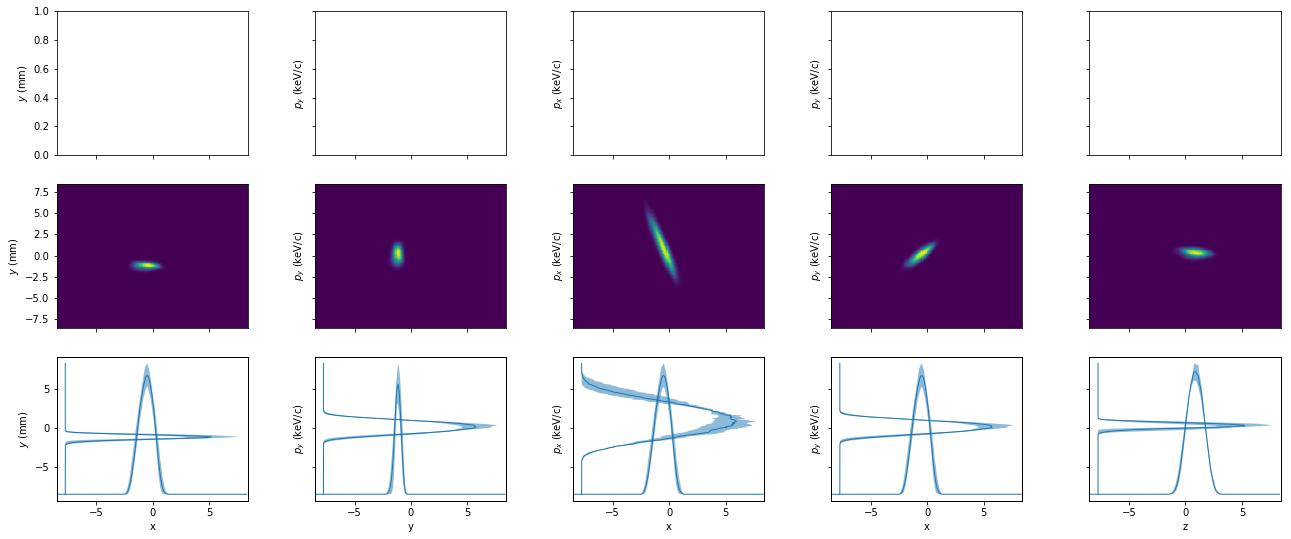

In [6]:
from visualization import add_image, add_projection, add_image_projection
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.axes import SubplotBase
pairs = [["x","y"],["y","py"],["x","px"],["x","py"],["z","pz"]]

fig,ax = plt.subplots(3,len(pairs), sharex="col",sharey="row")
fig.subplots_adjust(wspace=0.35, right=0.975, top=0.975)
fig.set_size_inches(20,8)
    
plot_bins = bins/2
#plot_bins = plot_bins * 1e3

vmax = None
linewidth=1.0
for g, pair in enumerate(pairs):
    i = g
    
    pb = [plot_bins]*2
    scale = 1e3
    #if pair == ["z","pz"]:
    #    plot_bins = bins*10
    #    scale = 1e6
    
    #print(np.max(gt_image))
    _, pred_image = add_image(ax[1][i], *pair, pred_initial_beams, pb,
                           scale_axis=scale,vmax=vmax)

    if pair[-1]=="y":
        for a in ax[:,i]:
            a.set_ylabel("$y$ (mm)")
    elif pair[-1]=="py":
        for a in ax[:,i]:
            a.set_ylabel("$p_y$ (keV/c)")
    elif pair[-1]=="px":
        for a in ax[:,i]:
            a.set_ylabel("$p_x$ (keV/c)")

    # x projections
    #max_dens = 250
    axa = ax[2][i].twinx()
    add_projection(axa, pair[0], pred_initial_beams, pb[0], x_scale=scale, y_scale=1)
    #axa.set_ylim(0,max_dens)
    axa.set_yticks([])
    
    # y projections
    axb = ax[2][i].twiny()
    add_projection(axb, pair[1], pred_initial_beams, pb[1],axis="y", x_scale=scale, y_scale=1)
    #axb.set_xlim(0,max_dens)
    axb.set_xticks([])
    
    for ele in [axa,axb]:
        for line in ele.get_lines():
            line.set(linewidth=linewidth)    
        ele.get_lines()[0].set(zorder=0)
    ax[-1][i].set_xlabel(pair[0])

# set rasterization for pcolor
for k in range(ax.shape[-1]):
    try:
        ax[0,k].collections[0].set_rasterized(True)
        ax[1,k].collections[0].set_rasterized(True)
    except IndexError:
        pass





print(pred_initial_beams[0].z.std())
print(pred_initial_beams[0].pz.std())

# set ticks for lower x-axis
#for a in ax[-1]:
#    a.set_xticks([-20,0,20])
    
#fig.tight_layout()


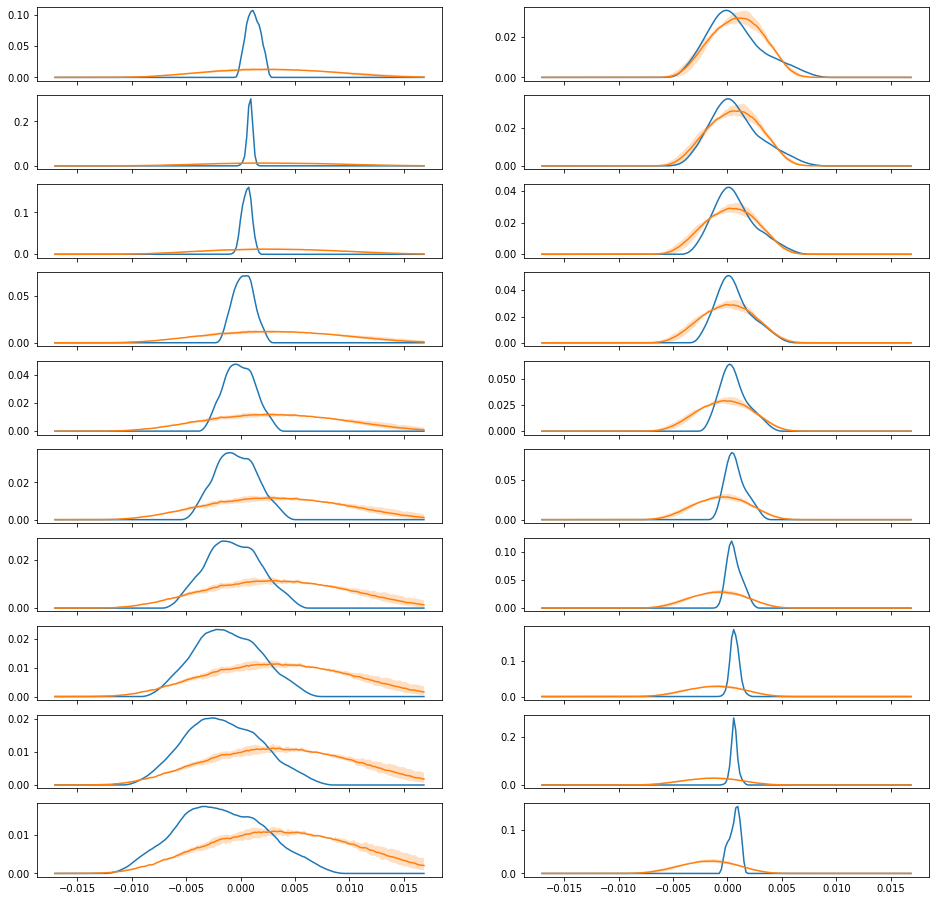

In [7]:
# compare projections
from visualization import compare_image_projections

fig = compare_image_projections(xx[0].T[0], test_im, test_pred)
fig.set_size_inches(16,16)

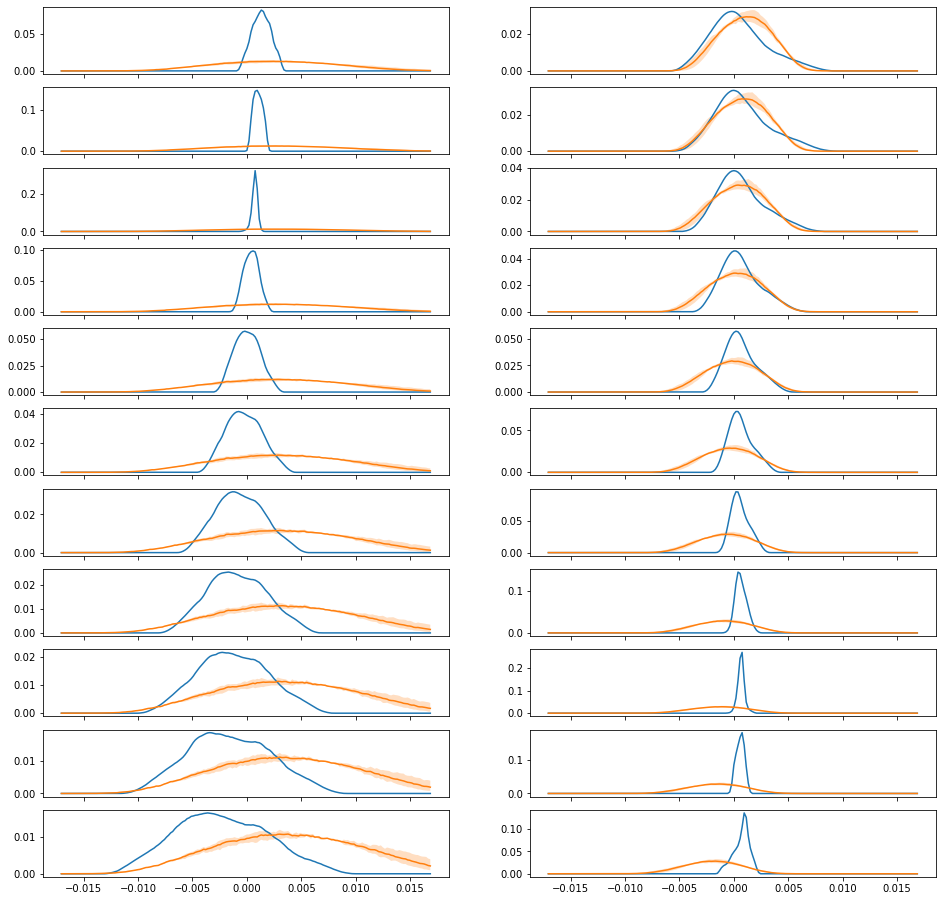

In [8]:
# compare projections
from visualization import compare_image_projections

fig = compare_image_projections(xx[0].T[0], train_im, train_pred)
fig.set_size_inches(16,16)

<AxesSubplot:>

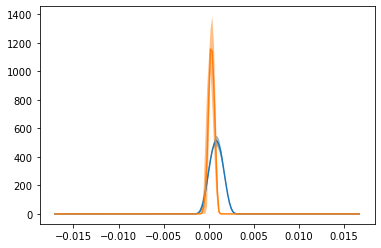

In [9]:
# plot reconstructed beam dist
from visualization import add_projection
beams = [ele.beam_generator() for ele in ensemble]

fig,ax = plt.subplots()
#add_projection(ax, "x", beams, xx[0].T[0])
#add_projection(ax, "y", beams, xx[0].T[0])
#add_projection(ax, "px", beams, xx[0].T[0])
#add_projection(ax, "py", beams, xx[0].T[0])
add_projection(ax, "z", beams, xx[0].T[0])
add_projection(ax, "pz", beams, xx[0].T[0])

In [10]:
# plot results from initial_ensemble
# get initial set of estimators
initial_estimators = []
for _ in range(200):
    initial_estimators.append(ensemble._make_estimator())

initial_estimators = torch.nn.ModuleList(initial_estimators)
initial_estimators.load_state_dict(torch.load("initial_ensemble.pt"))

RuntimeError: Error(s) in loading state_dict for ModuleList:
	Missing key(s) in state_dict: "0.beam_generator.transformer.stack.0.weight", "0.beam_generator.transformer.stack.0.bias", "0.beam_generator.transformer.stack.2.weight", "0.beam_generator.transformer.stack.2.bias", "0.beam_generator.transformer.stack.5.weight", "0.beam_generator.transformer.stack.5.bias", "0.beam_generator.transformer.stack.8.weight", "0.beam_generator.transformer.stack.8.bias", "0.beam_generator.transformer.stack.11.weight", "0.beam_generator.transformer.stack.11.bias", "0.beam_generator.transformer.stack.14.weight", "0.beam_generator.transformer.stack.14.bias", "1.beam_generator.transformer.stack.0.weight", "1.beam_generator.transformer.stack.0.bias", "1.beam_generator.transformer.stack.2.weight", "1.beam_generator.transformer.stack.2.bias", "1.beam_generator.transformer.stack.5.weight", "1.beam_generator.transformer.stack.5.bias", "1.beam_generator.transformer.stack.8.weight", "1.beam_generator.transformer.stack.8.bias", "1.beam_generator.transformer.stack.11.weight", "1.beam_generator.transformer.stack.11.bias", "1.beam_generator.transformer.stack.14.weight", "1.beam_generator.transformer.stack.14.bias", "2.beam_generator.transformer.stack.0.weight", "2.beam_generator.transformer.stack.0.bias", "2.beam_generator.transformer.stack.2.weight", "2.beam_generator.transformer.stack.2.bias", "2.beam_generator.transformer.stack.5.weight", "2.beam_generator.transformer.stack.5.bias", "2.beam_generator.transformer.stack.8.weight", "2.beam_generator.transformer.stack.8.bias", "2.beam_generator.transformer.stack.11.weight", "2.beam_generator.transformer.stack.11.bias", "2.beam_generator.transformer.stack.14.weight", "2.beam_generator.transformer.stack.14.bias", "3.beam_generator.transformer.stack.0.weight", "3.beam_generator.transformer.stack.0.bias", "3.beam_generator.transformer.stack.2.weight", "3.beam_generator.transformer.stack.2.bias", "3.beam_generator.transformer.stack.5.weight", "3.beam_generator.transformer.stack.5.bias", "3.beam_generator.transformer.stack.8.weight", "3.beam_generator.transformer.stack.8.bias", "3.beam_generator.transformer.stack.11.weight", "3.beam_generator.transformer.stack.11.bias", "3.beam_generator.transformer.stack.14.weight", "3.beam_generator.transformer.stack.14.bias", "4.beam_generator.transformer.stack.0.weight", "4.beam_generator.transformer.stack.0.bias", "4.beam_generator.transformer.stack.2.weight", "4.beam_generator.transformer.stack.2.bias", "4.beam_generator.transformer.stack.5.weight", "4.beam_generator.transformer.stack.5.bias", "4.beam_generator.transformer.stack.8.weight", "4.beam_generator.transformer.stack.8.bias", "4.beam_generator.transformer.stack.11.weight", "4.beam_generator.transformer.stack.11.bias", "4.beam_generator.transformer.stack.14.weight", "4.beam_generator.transformer.stack.14.bias", "5.beam_generator.transformer.stack.0.weight", "5.beam_generator.transformer.stack.0.bias", "5.beam_generator.transformer.stack.2.weight", "5.beam_generator.transformer.stack.2.bias", "5.beam_generator.transformer.stack.5.weight", "5.beam_generator.transformer.stack.5.bias", "5.beam_generator.transformer.stack.8.weight", "5.beam_generator.transformer.stack.8.bias", "5.beam_generator.transformer.stack.11.weight", "5.beam_generator.transformer.stack.11.bias", "5.beam_generator.transformer.stack.14.weight", "5.beam_generator.transformer.stack.14.bias", "6.beam_generator.transformer.stack.0.weight", "6.beam_generator.transformer.stack.0.bias", "6.beam_generator.transformer.stack.2.weight", "6.beam_generator.transformer.stack.2.bias", "6.beam_generator.transformer.stack.5.weight", "6.beam_generator.transformer.stack.5.bias", "6.beam_generator.transformer.stack.8.weight", "6.beam_generator.transformer.stack.8.bias", "6.beam_generator.transformer.stack.11.weight", "6.beam_generator.transformer.stack.11.bias", "6.beam_generator.transformer.stack.14.weight", "6.beam_generator.transformer.stack.14.bias", "7.beam_generator.transformer.stack.0.weight", "7.beam_generator.transformer.stack.0.bias", "7.beam_generator.transformer.stack.2.weight", "7.beam_generator.transformer.stack.2.bias", "7.beam_generator.transformer.stack.5.weight", "7.beam_generator.transformer.stack.5.bias", "7.beam_generator.transformer.stack.8.weight", "7.beam_generator.transformer.stack.8.bias", "7.beam_generator.transformer.stack.11.weight", "7.beam_generator.transformer.stack.11.bias", "7.beam_generator.transformer.stack.14.weight", "7.beam_generator.transformer.stack.14.bias", "8.beam_generator.transformer.stack.0.weight", "8.beam_generator.transformer.stack.0.bias", "8.beam_generator.transformer.stack.2.weight", "8.beam_generator.transformer.stack.2.bias", "8.beam_generator.transformer.stack.5.weight", "8.beam_generator.transformer.stack.5.bias", "8.beam_generator.transformer.stack.8.weight", "8.beam_generator.transformer.stack.8.bias", "8.beam_generator.transformer.stack.11.weight", "8.beam_generator.transformer.stack.11.bias", "8.beam_generator.transformer.stack.14.weight", "8.beam_generator.transformer.stack.14.bias", "9.beam_generator.transformer.stack.0.weight", "9.beam_generator.transformer.stack.0.bias", "9.beam_generator.transformer.stack.2.weight", "9.beam_generator.transformer.stack.2.bias", "9.beam_generator.transformer.stack.5.weight", "9.beam_generator.transformer.stack.5.bias", "9.beam_generator.transformer.stack.8.weight", "9.beam_generator.transformer.stack.8.bias", "9.beam_generator.transformer.stack.11.weight", "9.beam_generator.transformer.stack.11.bias", "9.beam_generator.transformer.stack.14.weight", "9.beam_generator.transformer.stack.14.bias", "10.beam_generator.transformer.stack.0.weight", "10.beam_generator.transformer.stack.0.bias", "10.beam_generator.transformer.stack.2.weight", "10.beam_generator.transformer.stack.2.bias", "10.beam_generator.transformer.stack.5.weight", "10.beam_generator.transformer.stack.5.bias", "10.beam_generator.transformer.stack.8.weight", "10.beam_generator.transformer.stack.8.bias", "10.beam_generator.transformer.stack.11.weight", "10.beam_generator.transformer.stack.11.bias", "10.beam_generator.transformer.stack.14.weight", "10.beam_generator.transformer.stack.14.bias", "11.beam_generator.transformer.stack.0.weight", "11.beam_generator.transformer.stack.0.bias", "11.beam_generator.transformer.stack.2.weight", "11.beam_generator.transformer.stack.2.bias", "11.beam_generator.transformer.stack.5.weight", "11.beam_generator.transformer.stack.5.bias", "11.beam_generator.transformer.stack.8.weight", "11.beam_generator.transformer.stack.8.bias", "11.beam_generator.transformer.stack.11.weight", "11.beam_generator.transformer.stack.11.bias", "11.beam_generator.transformer.stack.14.weight", "11.beam_generator.transformer.stack.14.bias", "12.beam_generator.transformer.stack.0.weight", "12.beam_generator.transformer.stack.0.bias", "12.beam_generator.transformer.stack.2.weight", "12.beam_generator.transformer.stack.2.bias", "12.beam_generator.transformer.stack.5.weight", "12.beam_generator.transformer.stack.5.bias", "12.beam_generator.transformer.stack.8.weight", "12.beam_generator.transformer.stack.8.bias", "12.beam_generator.transformer.stack.11.weight", "12.beam_generator.transformer.stack.11.bias", "12.beam_generator.transformer.stack.14.weight", "12.beam_generator.transformer.stack.14.bias", "13.beam_generator.transformer.stack.0.weight", "13.beam_generator.transformer.stack.0.bias", "13.beam_generator.transformer.stack.2.weight", "13.beam_generator.transformer.stack.2.bias", "13.beam_generator.transformer.stack.5.weight", "13.beam_generator.transformer.stack.5.bias", "13.beam_generator.transformer.stack.8.weight", "13.beam_generator.transformer.stack.8.bias", "13.beam_generator.transformer.stack.11.weight", "13.beam_generator.transformer.stack.11.bias", "13.beam_generator.transformer.stack.14.weight", "13.beam_generator.transformer.stack.14.bias", "14.beam_generator.transformer.stack.0.weight", "14.beam_generator.transformer.stack.0.bias", "14.beam_generator.transformer.stack.2.weight", "14.beam_generator.transformer.stack.2.bias", "14.beam_generator.transformer.stack.5.weight", "14.beam_generator.transformer.stack.5.bias", "14.beam_generator.transformer.stack.8.weight", "14.beam_generator.transformer.stack.8.bias", "14.beam_generator.transformer.stack.11.weight", "14.beam_generator.transformer.stack.11.bias", "14.beam_generator.transformer.stack.14.weight", "14.beam_generator.transformer.stack.14.bias", "15.beam_generator.transformer.stack.0.weight", "15.beam_generator.transformer.stack.0.bias", "15.beam_generator.transformer.stack.2.weight", "15.beam_generator.transformer.stack.2.bias", "15.beam_generator.transformer.stack.5.weight", "15.beam_generator.transformer.stack.5.bias", "15.beam_generator.transformer.stack.8.weight", "15.beam_generator.transformer.stack.8.bias", "15.beam_generator.transformer.stack.11.weight", "15.beam_generator.transformer.stack.11.bias", "15.beam_generator.transformer.stack.14.weight", "15.beam_generator.transformer.stack.14.bias", "16.beam_generator.transformer.stack.0.weight", "16.beam_generator.transformer.stack.0.bias", "16.beam_generator.transformer.stack.2.weight", "16.beam_generator.transformer.stack.2.bias", "16.beam_generator.transformer.stack.5.weight", "16.beam_generator.transformer.stack.5.bias", "16.beam_generator.transformer.stack.8.weight", "16.beam_generator.transformer.stack.8.bias", "16.beam_generator.transformer.stack.11.weight", "16.beam_generator.transformer.stack.11.bias", "16.beam_generator.transformer.stack.14.weight", "16.beam_generator.transformer.stack.14.bias", "17.beam_generator.transformer.stack.0.weight", "17.beam_generator.transformer.stack.0.bias", "17.beam_generator.transformer.stack.2.weight", "17.beam_generator.transformer.stack.2.bias", "17.beam_generator.transformer.stack.5.weight", "17.beam_generator.transformer.stack.5.bias", "17.beam_generator.transformer.stack.8.weight", "17.beam_generator.transformer.stack.8.bias", "17.beam_generator.transformer.stack.11.weight", "17.beam_generator.transformer.stack.11.bias", "17.beam_generator.transformer.stack.14.weight", "17.beam_generator.transformer.stack.14.bias", "18.beam_generator.transformer.stack.0.weight", "18.beam_generator.transformer.stack.0.bias", "18.beam_generator.transformer.stack.2.weight", "18.beam_generator.transformer.stack.2.bias", "18.beam_generator.transformer.stack.5.weight", "18.beam_generator.transformer.stack.5.bias", "18.beam_generator.transformer.stack.8.weight", "18.beam_generator.transformer.stack.8.bias", "18.beam_generator.transformer.stack.11.weight", "18.beam_generator.transformer.stack.11.bias", "18.beam_generator.transformer.stack.14.weight", "18.beam_generator.transformer.stack.14.bias", "19.beam_generator.transformer.stack.0.weight", "19.beam_generator.transformer.stack.0.bias", "19.beam_generator.transformer.stack.2.weight", "19.beam_generator.transformer.stack.2.bias", "19.beam_generator.transformer.stack.5.weight", "19.beam_generator.transformer.stack.5.bias", "19.beam_generator.transformer.stack.8.weight", "19.beam_generator.transformer.stack.8.bias", "19.beam_generator.transformer.stack.11.weight", "19.beam_generator.transformer.stack.11.bias", "19.beam_generator.transformer.stack.14.weight", "19.beam_generator.transformer.stack.14.bias", "20.beam_generator.transformer.stack.0.weight", "20.beam_generator.transformer.stack.0.bias", "20.beam_generator.transformer.stack.2.weight", "20.beam_generator.transformer.stack.2.bias", "20.beam_generator.transformer.stack.5.weight", "20.beam_generator.transformer.stack.5.bias", "20.beam_generator.transformer.stack.8.weight", "20.beam_generator.transformer.stack.8.bias", "20.beam_generator.transformer.stack.11.weight", "20.beam_generator.transformer.stack.11.bias", "20.beam_generator.transformer.stack.14.weight", "20.beam_generator.transformer.stack.14.bias", "21.beam_generator.transformer.stack.0.weight", "21.beam_generator.transformer.stack.0.bias", "21.beam_generator.transformer.stack.2.weight", "21.beam_generator.transformer.stack.2.bias", "21.beam_generator.transformer.stack.5.weight", "21.beam_generator.transformer.stack.5.bias", "21.beam_generator.transformer.stack.8.weight", "21.beam_generator.transformer.stack.8.bias", "21.beam_generator.transformer.stack.11.weight", "21.beam_generator.transformer.stack.11.bias", "21.beam_generator.transformer.stack.14.weight", "21.beam_generator.transformer.stack.14.bias", "22.beam_generator.transformer.stack.0.weight", "22.beam_generator.transformer.stack.0.bias", "22.beam_generator.transformer.stack.2.weight", "22.beam_generator.transformer.stack.2.bias", "22.beam_generator.transformer.stack.5.weight", "22.beam_generator.transformer.stack.5.bias", "22.beam_generator.transformer.stack.8.weight", "22.beam_generator.transformer.stack.8.bias", "22.beam_generator.transformer.stack.11.weight", "22.beam_generator.transformer.stack.11.bias", "22.beam_generator.transformer.stack.14.weight", "22.beam_generator.transformer.stack.14.bias", "23.beam_generator.transformer.stack.0.weight", "23.beam_generator.transformer.stack.0.bias", "23.beam_generator.transformer.stack.2.weight", "23.beam_generator.transformer.stack.2.bias", "23.beam_generator.transformer.stack.5.weight", "23.beam_generator.transformer.stack.5.bias", "23.beam_generator.transformer.stack.8.weight", "23.beam_generator.transformer.stack.8.bias", "23.beam_generator.transformer.stack.11.weight", "23.beam_generator.transformer.stack.11.bias", "23.beam_generator.transformer.stack.14.weight", "23.beam_generator.transformer.stack.14.bias", "24.beam_generator.transformer.stack.0.weight", "24.beam_generator.transformer.stack.0.bias", "24.beam_generator.transformer.stack.2.weight", "24.beam_generator.transformer.stack.2.bias", "24.beam_generator.transformer.stack.5.weight", "24.beam_generator.transformer.stack.5.bias", "24.beam_generator.transformer.stack.8.weight", "24.beam_generator.transformer.stack.8.bias", "24.beam_generator.transformer.stack.11.weight", "24.beam_generator.transformer.stack.11.bias", "24.beam_generator.transformer.stack.14.weight", "24.beam_generator.transformer.stack.14.bias", "25.beam_generator.transformer.stack.0.weight", "25.beam_generator.transformer.stack.0.bias", "25.beam_generator.transformer.stack.2.weight", "25.beam_generator.transformer.stack.2.bias", "25.beam_generator.transformer.stack.5.weight", "25.beam_generator.transformer.stack.5.bias", "25.beam_generator.transformer.stack.8.weight", "25.beam_generator.transformer.stack.8.bias", "25.beam_generator.transformer.stack.11.weight", "25.beam_generator.transformer.stack.11.bias", "25.beam_generator.transformer.stack.14.weight", "25.beam_generator.transformer.stack.14.bias", "26.beam_generator.transformer.stack.0.weight", "26.beam_generator.transformer.stack.0.bias", "26.beam_generator.transformer.stack.2.weight", "26.beam_generator.transformer.stack.2.bias", "26.beam_generator.transformer.stack.5.weight", "26.beam_generator.transformer.stack.5.bias", "26.beam_generator.transformer.stack.8.weight", "26.beam_generator.transformer.stack.8.bias", "26.beam_generator.transformer.stack.11.weight", "26.beam_generator.transformer.stack.11.bias", "26.beam_generator.transformer.stack.14.weight", "26.beam_generator.transformer.stack.14.bias", "27.beam_generator.transformer.stack.0.weight", "27.beam_generator.transformer.stack.0.bias", "27.beam_generator.transformer.stack.2.weight", "27.beam_generator.transformer.stack.2.bias", "27.beam_generator.transformer.stack.5.weight", "27.beam_generator.transformer.stack.5.bias", "27.beam_generator.transformer.stack.8.weight", "27.beam_generator.transformer.stack.8.bias", "27.beam_generator.transformer.stack.11.weight", "27.beam_generator.transformer.stack.11.bias", "27.beam_generator.transformer.stack.14.weight", "27.beam_generator.transformer.stack.14.bias", "28.beam_generator.transformer.stack.0.weight", "28.beam_generator.transformer.stack.0.bias", "28.beam_generator.transformer.stack.2.weight", "28.beam_generator.transformer.stack.2.bias", "28.beam_generator.transformer.stack.5.weight", "28.beam_generator.transformer.stack.5.bias", "28.beam_generator.transformer.stack.8.weight", "28.beam_generator.transformer.stack.8.bias", "28.beam_generator.transformer.stack.11.weight", "28.beam_generator.transformer.stack.11.bias", "28.beam_generator.transformer.stack.14.weight", "28.beam_generator.transformer.stack.14.bias", "29.beam_generator.transformer.stack.0.weight", "29.beam_generator.transformer.stack.0.bias", "29.beam_generator.transformer.stack.2.weight", "29.beam_generator.transformer.stack.2.bias", "29.beam_generator.transformer.stack.5.weight", "29.beam_generator.transformer.stack.5.bias", "29.beam_generator.transformer.stack.8.weight", "29.beam_generator.transformer.stack.8.bias", "29.beam_generator.transformer.stack.11.weight", "29.beam_generator.transformer.stack.11.bias", "29.beam_generator.transformer.stack.14.weight", "29.beam_generator.transformer.stack.14.bias", "30.beam_generator.transformer.stack.0.weight", "30.beam_generator.transformer.stack.0.bias", "30.beam_generator.transformer.stack.2.weight", "30.beam_generator.transformer.stack.2.bias", "30.beam_generator.transformer.stack.5.weight", "30.beam_generator.transformer.stack.5.bias", "30.beam_generator.transformer.stack.8.weight", "30.beam_generator.transformer.stack.8.bias", "30.beam_generator.transformer.stack.11.weight", "30.beam_generator.transformer.stack.11.bias", "30.beam_generator.transformer.stack.14.weight", "30.beam_generator.transformer.stack.14.bias", "31.beam_generator.transformer.stack.0.weight", "31.beam_generator.transformer.stack.0.bias", "31.beam_generator.transformer.stack.2.weight", "31.beam_generator.transformer.stack.2.bias", "31.beam_generator.transformer.stack.5.weight", "31.beam_generator.transformer.stack.5.bias", "31.beam_generator.transformer.stack.8.weight", "31.beam_generator.transformer.stack.8.bias", "31.beam_generator.transformer.stack.11.weight", "31.beam_generator.transformer.stack.11.bias", "31.beam_generator.transformer.stack.14.weight", "31.beam_generator.transformer.stack.14.bias", "32.beam_generator.transformer.stack.0.weight", "32.beam_generator.transformer.stack.0.bias", "32.beam_generator.transformer.stack.2.weight", "32.beam_generator.transformer.stack.2.bias", "32.beam_generator.transformer.stack.5.weight", "32.beam_generator.transformer.stack.5.bias", "32.beam_generator.transformer.stack.8.weight", "32.beam_generator.transformer.stack.8.bias", "32.beam_generator.transformer.stack.11.weight", "32.beam_generator.transformer.stack.11.bias", "32.beam_generator.transformer.stack.14.weight", "32.beam_generator.transformer.stack.14.bias", "33.beam_generator.transformer.stack.0.weight", "33.beam_generator.transformer.stack.0.bias", "33.beam_generator.transformer.stack.2.weight", "33.beam_generator.transformer.stack.2.bias", "33.beam_generator.transformer.stack.5.weight", "33.beam_generator.transformer.stack.5.bias", "33.beam_generator.transformer.stack.8.weight", "33.beam_generator.transformer.stack.8.bias", "33.beam_generator.transformer.stack.11.weight", "33.beam_generator.transformer.stack.11.bias", "33.beam_generator.transformer.stack.14.weight", "33.beam_generator.transformer.stack.14.bias", "34.beam_generator.transformer.stack.0.weight", "34.beam_generator.transformer.stack.0.bias", "34.beam_generator.transformer.stack.2.weight", "34.beam_generator.transformer.stack.2.bias", "34.beam_generator.transformer.stack.5.weight", "34.beam_generator.transformer.stack.5.bias", "34.beam_generator.transformer.stack.8.weight", "34.beam_generator.transformer.stack.8.bias", "34.beam_generator.transformer.stack.11.weight", "34.beam_generator.transformer.stack.11.bias", "34.beam_generator.transformer.stack.14.weight", "34.beam_generator.transformer.stack.14.bias", "35.beam_generator.transformer.stack.0.weight", "35.beam_generator.transformer.stack.0.bias", "35.beam_generator.transformer.stack.2.weight", "35.beam_generator.transformer.stack.2.bias", "35.beam_generator.transformer.stack.5.weight", "35.beam_generator.transformer.stack.5.bias", "35.beam_generator.transformer.stack.8.weight", "35.beam_generator.transformer.stack.8.bias", "35.beam_generator.transformer.stack.11.weight", "35.beam_generator.transformer.stack.11.bias", "35.beam_generator.transformer.stack.14.weight", "35.beam_generator.transformer.stack.14.bias", "36.beam_generator.transformer.stack.0.weight", "36.beam_generator.transformer.stack.0.bias", "36.beam_generator.transformer.stack.2.weight", "36.beam_generator.transformer.stack.2.bias", "36.beam_generator.transformer.stack.5.weight", "36.beam_generator.transformer.stack.5.bias", "36.beam_generator.transformer.stack.8.weight", "36.beam_generator.transformer.stack.8.bias", "36.beam_generator.transformer.stack.11.weight", "36.beam_generator.transformer.stack.11.bias", "36.beam_generator.transformer.stack.14.weight", "36.beam_generator.transformer.stack.14.bias", "37.beam_generator.transformer.stack.0.weight", "37.beam_generator.transformer.stack.0.bias", "37.beam_generator.transformer.stack.2.weight", "37.beam_generator.transformer.stack.2.bias", "37.beam_generator.transformer.stack.5.weight", "37.beam_generator.transformer.stack.5.bias", "37.beam_generator.transformer.stack.8.weight", "37.beam_generator.transformer.stack.8.bias", "37.beam_generator.transformer.stack.11.weight", "37.beam_generator.transformer.stack.11.bias", "37.beam_generator.transformer.stack.14.weight", "37.beam_generator.transformer.stack.14.bias", "38.beam_generator.transformer.stack.0.weight", "38.beam_generator.transformer.stack.0.bias", "38.beam_generator.transformer.stack.2.weight", "38.beam_generator.transformer.stack.2.bias", "38.beam_generator.transformer.stack.5.weight", "38.beam_generator.transformer.stack.5.bias", "38.beam_generator.transformer.stack.8.weight", "38.beam_generator.transformer.stack.8.bias", "38.beam_generator.transformer.stack.11.weight", "38.beam_generator.transformer.stack.11.bias", "38.beam_generator.transformer.stack.14.weight", "38.beam_generator.transformer.stack.14.bias", "39.beam_generator.transformer.stack.0.weight", "39.beam_generator.transformer.stack.0.bias", "39.beam_generator.transformer.stack.2.weight", "39.beam_generator.transformer.stack.2.bias", "39.beam_generator.transformer.stack.5.weight", "39.beam_generator.transformer.stack.5.bias", "39.beam_generator.transformer.stack.8.weight", "39.beam_generator.transformer.stack.8.bias", "39.beam_generator.transformer.stack.11.weight", "39.beam_generator.transformer.stack.11.bias", "39.beam_generator.transformer.stack.14.weight", "39.beam_generator.transformer.stack.14.bias", "40.beam_generator.transformer.stack.0.weight", "40.beam_generator.transformer.stack.0.bias", "40.beam_generator.transformer.stack.2.weight", "40.beam_generator.transformer.stack.2.bias", "40.beam_generator.transformer.stack.5.weight", "40.beam_generator.transformer.stack.5.bias", "40.beam_generator.transformer.stack.8.weight", "40.beam_generator.transformer.stack.8.bias", "40.beam_generator.transformer.stack.11.weight", "40.beam_generator.transformer.stack.11.bias", "40.beam_generator.transformer.stack.14.weight", "40.beam_generator.transformer.stack.14.bias", "41.beam_generator.transformer.stack.0.weight", "41.beam_generator.transformer.stack.0.bias", "41.beam_generator.transformer.stack.2.weight", "41.beam_generator.transformer.stack.2.bias", "41.beam_generator.transformer.stack.5.weight", "41.beam_generator.transformer.stack.5.bias", "41.beam_generator.transformer.stack.8.weight", "41.beam_generator.transformer.stack.8.bias", "41.beam_generator.transformer.stack.11.weight", "41.beam_generator.transformer.stack.11.bias", "41.beam_generator.transformer.stack.14.weight", "41.beam_generator.transformer.stack.14.bias", "42.beam_generator.transformer.stack.0.weight", "42.beam_generator.transformer.stack.0.bias", "42.beam_generator.transformer.stack.2.weight", "42.beam_generator.transformer.stack.2.bias", "42.beam_generator.transformer.stack.5.weight", "42.beam_generator.transformer.stack.5.bias", "42.beam_generator.transformer.stack.8.weight", "42.beam_generator.transformer.stack.8.bias", "42.beam_generator.transformer.stack.11.weight", "42.beam_generator.transformer.stack.11.bias", "42.beam_generator.transformer.stack.14.weight", "42.beam_generator.transformer.stack.14.bias", "43.beam_generator.transformer.stack.0.weight", "43.beam_generator.transformer.stack.0.bias", "43.beam_generator.transformer.stack.2.weight", "43.beam_generator.transformer.stack.2.bias", "43.beam_generator.transformer.stack.5.weight", "43.beam_generator.transformer.stack.5.bias", "43.beam_generator.transformer.stack.8.weight", "43.beam_generator.transformer.stack.8.bias", "43.beam_generator.transformer.stack.11.weight", "43.beam_generator.transformer.stack.11.bias", "43.beam_generator.transformer.stack.14.weight", "43.beam_generator.transformer.stack.14.bias", "44.beam_generator.transformer.stack.0.weight", "44.beam_generator.transformer.stack.0.bias", "44.beam_generator.transformer.stack.2.weight", "44.beam_generator.transformer.stack.2.bias", "44.beam_generator.transformer.stack.5.weight", "44.beam_generator.transformer.stack.5.bias", "44.beam_generator.transformer.stack.8.weight", "44.beam_generator.transformer.stack.8.bias", "44.beam_generator.transformer.stack.11.weight", "44.beam_generator.transformer.stack.11.bias", "44.beam_generator.transformer.stack.14.weight", "44.beam_generator.transformer.stack.14.bias", "45.beam_generator.transformer.stack.0.weight", "45.beam_generator.transformer.stack.0.bias", "45.beam_generator.transformer.stack.2.weight", "45.beam_generator.transformer.stack.2.bias", "45.beam_generator.transformer.stack.5.weight", "45.beam_generator.transformer.stack.5.bias", "45.beam_generator.transformer.stack.8.weight", "45.beam_generator.transformer.stack.8.bias", "45.beam_generator.transformer.stack.11.weight", "45.beam_generator.transformer.stack.11.bias", "45.beam_generator.transformer.stack.14.weight", "45.beam_generator.transformer.stack.14.bias", "46.beam_generator.transformer.stack.0.weight", "46.beam_generator.transformer.stack.0.bias", "46.beam_generator.transformer.stack.2.weight", "46.beam_generator.transformer.stack.2.bias", "46.beam_generator.transformer.stack.5.weight", "46.beam_generator.transformer.stack.5.bias", "46.beam_generator.transformer.stack.8.weight", "46.beam_generator.transformer.stack.8.bias", "46.beam_generator.transformer.stack.11.weight", "46.beam_generator.transformer.stack.11.bias", "46.beam_generator.transformer.stack.14.weight", "46.beam_generator.transformer.stack.14.bias", "47.beam_generator.transformer.stack.0.weight", "47.beam_generator.transformer.stack.0.bias", "47.beam_generator.transformer.stack.2.weight", "47.beam_generator.transformer.stack.2.bias", "47.beam_generator.transformer.stack.5.weight", "47.beam_generator.transformer.stack.5.bias", "47.beam_generator.transformer.stack.8.weight", "47.beam_generator.transformer.stack.8.bias", "47.beam_generator.transformer.stack.11.weight", "47.beam_generator.transformer.stack.11.bias", "47.beam_generator.transformer.stack.14.weight", "47.beam_generator.transformer.stack.14.bias", "48.beam_generator.transformer.stack.0.weight", "48.beam_generator.transformer.stack.0.bias", "48.beam_generator.transformer.stack.2.weight", "48.beam_generator.transformer.stack.2.bias", "48.beam_generator.transformer.stack.5.weight", "48.beam_generator.transformer.stack.5.bias", "48.beam_generator.transformer.stack.8.weight", "48.beam_generator.transformer.stack.8.bias", "48.beam_generator.transformer.stack.11.weight", "48.beam_generator.transformer.stack.11.bias", "48.beam_generator.transformer.stack.14.weight", "48.beam_generator.transformer.stack.14.bias", "49.beam_generator.transformer.stack.0.weight", "49.beam_generator.transformer.stack.0.bias", "49.beam_generator.transformer.stack.2.weight", "49.beam_generator.transformer.stack.2.bias", "49.beam_generator.transformer.stack.5.weight", "49.beam_generator.transformer.stack.5.bias", "49.beam_generator.transformer.stack.8.weight", "49.beam_generator.transformer.stack.8.bias", "49.beam_generator.transformer.stack.11.weight", "49.beam_generator.transformer.stack.11.bias", "49.beam_generator.transformer.stack.14.weight", "49.beam_generator.transformer.stack.14.bias", "50.beam_generator.transformer.stack.0.weight", "50.beam_generator.transformer.stack.0.bias", "50.beam_generator.transformer.stack.2.weight", "50.beam_generator.transformer.stack.2.bias", "50.beam_generator.transformer.stack.5.weight", "50.beam_generator.transformer.stack.5.bias", "50.beam_generator.transformer.stack.8.weight", "50.beam_generator.transformer.stack.8.bias", "50.beam_generator.transformer.stack.11.weight", "50.beam_generator.transformer.stack.11.bias", "50.beam_generator.transformer.stack.14.weight", "50.beam_generator.transformer.stack.14.bias", "51.beam_generator.transformer.stack.0.weight", "51.beam_generator.transformer.stack.0.bias", "51.beam_generator.transformer.stack.2.weight", "51.beam_generator.transformer.stack.2.bias", "51.beam_generator.transformer.stack.5.weight", "51.beam_generator.transformer.stack.5.bias", "51.beam_generator.transformer.stack.8.weight", "51.beam_generator.transformer.stack.8.bias", "51.beam_generator.transformer.stack.11.weight", "51.beam_generator.transformer.stack.11.bias", "51.beam_generator.transformer.stack.14.weight", "51.beam_generator.transformer.stack.14.bias", "52.beam_generator.transformer.stack.0.weight", "52.beam_generator.transformer.stack.0.bias", "52.beam_generator.transformer.stack.2.weight", "52.beam_generator.transformer.stack.2.bias", "52.beam_generator.transformer.stack.5.weight", "52.beam_generator.transformer.stack.5.bias", "52.beam_generator.transformer.stack.8.weight", "52.beam_generator.transformer.stack.8.bias", "52.beam_generator.transformer.stack.11.weight", "52.beam_generator.transformer.stack.11.bias", "52.beam_generator.transformer.stack.14.weight", "52.beam_generator.transformer.stack.14.bias", "53.beam_generator.transformer.stack.0.weight", "53.beam_generator.transformer.stack.0.bias", "53.beam_generator.transformer.stack.2.weight", "53.beam_generator.transformer.stack.2.bias", "53.beam_generator.transformer.stack.5.weight", "53.beam_generator.transformer.stack.5.bias", "53.beam_generator.transformer.stack.8.weight", "53.beam_generator.transformer.stack.8.bias", "53.beam_generator.transformer.stack.11.weight", "53.beam_generator.transformer.stack.11.bias", "53.beam_generator.transformer.stack.14.weight", "53.beam_generator.transformer.stack.14.bias", "54.beam_generator.transformer.stack.0.weight", "54.beam_generator.transformer.stack.0.bias", "54.beam_generator.transformer.stack.2.weight", "54.beam_generator.transformer.stack.2.bias", "54.beam_generator.transformer.stack.5.weight", "54.beam_generator.transformer.stack.5.bias", "54.beam_generator.transformer.stack.8.weight", "54.beam_generator.transformer.stack.8.bias", "54.beam_generator.transformer.stack.11.weight", "54.beam_generator.transformer.stack.11.bias", "54.beam_generator.transformer.stack.14.weight", "54.beam_generator.transformer.stack.14.bias", "55.beam_generator.transformer.stack.0.weight", "55.beam_generator.transformer.stack.0.bias", "55.beam_generator.transformer.stack.2.weight", "55.beam_generator.transformer.stack.2.bias", "55.beam_generator.transformer.stack.5.weight", "55.beam_generator.transformer.stack.5.bias", "55.beam_generator.transformer.stack.8.weight", "55.beam_generator.transformer.stack.8.bias", "55.beam_generator.transformer.stack.11.weight", "55.beam_generator.transformer.stack.11.bias", "55.beam_generator.transformer.stack.14.weight", "55.beam_generator.transformer.stack.14.bias", "56.beam_generator.transformer.stack.0.weight", "56.beam_generator.transformer.stack.0.bias", "56.beam_generator.transformer.stack.2.weight", "56.beam_generator.transformer.stack.2.bias", "56.beam_generator.transformer.stack.5.weight", "56.beam_generator.transformer.stack.5.bias", "56.beam_generator.transformer.stack.8.weight", "56.beam_generator.transformer.stack.8.bias", "56.beam_generator.transformer.stack.11.weight", "56.beam_generator.transformer.stack.11.bias", "56.beam_generator.transformer.stack.14.weight", "56.beam_generator.transformer.stack.14.bias", "57.beam_generator.transformer.stack.0.weight", "57.beam_generator.transformer.stack.0.bias", "57.beam_generator.transformer.stack.2.weight", "57.beam_generator.transformer.stack.2.bias", "57.beam_generator.transformer.stack.5.weight", "57.beam_generator.transformer.stack.5.bias", "57.beam_generator.transformer.stack.8.weight", "57.beam_generator.transformer.stack.8.bias", "57.beam_generator.transformer.stack.11.weight", "57.beam_generator.transformer.stack.11.bias", "57.beam_generator.transformer.stack.14.weight", "57.beam_generator.transformer.stack.14.bias", "58.beam_generator.transformer.stack.0.weight", "58.beam_generator.transformer.stack.0.bias", "58.beam_generator.transformer.stack.2.weight", "58.beam_generator.transformer.stack.2.bias", "58.beam_generator.transformer.stack.5.weight", "58.beam_generator.transformer.stack.5.bias", "58.beam_generator.transformer.stack.8.weight", "58.beam_generator.transformer.stack.8.bias", "58.beam_generator.transformer.stack.11.weight", "58.beam_generator.transformer.stack.11.bias", "58.beam_generator.transformer.stack.14.weight", "58.beam_generator.transformer.stack.14.bias", "59.beam_generator.transformer.stack.0.weight", "59.beam_generator.transformer.stack.0.bias", "59.beam_generator.transformer.stack.2.weight", "59.beam_generator.transformer.stack.2.bias", "59.beam_generator.transformer.stack.5.weight", "59.beam_generator.transformer.stack.5.bias", "59.beam_generator.transformer.stack.8.weight", "59.beam_generator.transformer.stack.8.bias", "59.beam_generator.transformer.stack.11.weight", "59.beam_generator.transformer.stack.11.bias", "59.beam_generator.transformer.stack.14.weight", "59.beam_generator.transformer.stack.14.bias", "60.beam_generator.transformer.stack.0.weight", "60.beam_generator.transformer.stack.0.bias", "60.beam_generator.transformer.stack.2.weight", "60.beam_generator.transformer.stack.2.bias", "60.beam_generator.transformer.stack.5.weight", "60.beam_generator.transformer.stack.5.bias", "60.beam_generator.transformer.stack.8.weight", "60.beam_generator.transformer.stack.8.bias", "60.beam_generator.transformer.stack.11.weight", "60.beam_generator.transformer.stack.11.bias", "60.beam_generator.transformer.stack.14.weight", "60.beam_generator.transformer.stack.14.bias", "61.beam_generator.transformer.stack.0.weight", "61.beam_generator.transformer.stack.0.bias", "61.beam_generator.transformer.stack.2.weight", "61.beam_generator.transformer.stack.2.bias", "61.beam_generator.transformer.stack.5.weight", "61.beam_generator.transformer.stack.5.bias", "61.beam_generator.transformer.stack.8.weight", "61.beam_generator.transformer.stack.8.bias", "61.beam_generator.transformer.stack.11.weight", "61.beam_generator.transformer.stack.11.bias", "61.beam_generator.transformer.stack.14.weight", "61.beam_generator.transformer.stack.14.bias", "62.beam_generator.transformer.stack.0.weight", "62.beam_generator.transformer.stack.0.bias", "62.beam_generator.transformer.stack.2.weight", "62.beam_generator.transformer.stack.2.bias", "62.beam_generator.transformer.stack.5.weight", "62.beam_generator.transformer.stack.5.bias", "62.beam_generator.transformer.stack.8.weight", "62.beam_generator.transformer.stack.8.bias", "62.beam_generator.transformer.stack.11.weight", "62.beam_generator.transformer.stack.11.bias", "62.beam_generator.transformer.stack.14.weight", "62.beam_generator.transformer.stack.14.bias", "63.beam_generator.transformer.stack.0.weight", "63.beam_generator.transformer.stack.0.bias", "63.beam_generator.transformer.stack.2.weight", "63.beam_generator.transformer.stack.2.bias", "63.beam_generator.transformer.stack.5.weight", "63.beam_generator.transformer.stack.5.bias", "63.beam_generator.transformer.stack.8.weight", "63.beam_generator.transformer.stack.8.bias", "63.beam_generator.transformer.stack.11.weight", "63.beam_generator.transformer.stack.11.bias", "63.beam_generator.transformer.stack.14.weight", "63.beam_generator.transformer.stack.14.bias", "64.beam_generator.transformer.stack.0.weight", "64.beam_generator.transformer.stack.0.bias", "64.beam_generator.transformer.stack.2.weight", "64.beam_generator.transformer.stack.2.bias", "64.beam_generator.transformer.stack.5.weight", "64.beam_generator.transformer.stack.5.bias", "64.beam_generator.transformer.stack.8.weight", "64.beam_generator.transformer.stack.8.bias", "64.beam_generator.transformer.stack.11.weight", "64.beam_generator.transformer.stack.11.bias", "64.beam_generator.transformer.stack.14.weight", "64.beam_generator.transformer.stack.14.bias", "65.beam_generator.transformer.stack.0.weight", "65.beam_generator.transformer.stack.0.bias", "65.beam_generator.transformer.stack.2.weight", "65.beam_generator.transformer.stack.2.bias", "65.beam_generator.transformer.stack.5.weight", "65.beam_generator.transformer.stack.5.bias", "65.beam_generator.transformer.stack.8.weight", "65.beam_generator.transformer.stack.8.bias", "65.beam_generator.transformer.stack.11.weight", "65.beam_generator.transformer.stack.11.bias", "65.beam_generator.transformer.stack.14.weight", "65.beam_generator.transformer.stack.14.bias", "66.beam_generator.transformer.stack.0.weight", "66.beam_generator.transformer.stack.0.bias", "66.beam_generator.transformer.stack.2.weight", "66.beam_generator.transformer.stack.2.bias", "66.beam_generator.transformer.stack.5.weight", "66.beam_generator.transformer.stack.5.bias", "66.beam_generator.transformer.stack.8.weight", "66.beam_generator.transformer.stack.8.bias", "66.beam_generator.transformer.stack.11.weight", "66.beam_generator.transformer.stack.11.bias", "66.beam_generator.transformer.stack.14.weight", "66.beam_generator.transformer.stack.14.bias", "67.beam_generator.transformer.stack.0.weight", "67.beam_generator.transformer.stack.0.bias", "67.beam_generator.transformer.stack.2.weight", "67.beam_generator.transformer.stack.2.bias", "67.beam_generator.transformer.stack.5.weight", "67.beam_generator.transformer.stack.5.bias", "67.beam_generator.transformer.stack.8.weight", "67.beam_generator.transformer.stack.8.bias", "67.beam_generator.transformer.stack.11.weight", "67.beam_generator.transformer.stack.11.bias", "67.beam_generator.transformer.stack.14.weight", "67.beam_generator.transformer.stack.14.bias", "68.beam_generator.transformer.stack.0.weight", "68.beam_generator.transformer.stack.0.bias", "68.beam_generator.transformer.stack.2.weight", "68.beam_generator.transformer.stack.2.bias", "68.beam_generator.transformer.stack.5.weight", "68.beam_generator.transformer.stack.5.bias", "68.beam_generator.transformer.stack.8.weight", "68.beam_generator.transformer.stack.8.bias", "68.beam_generator.transformer.stack.11.weight", "68.beam_generator.transformer.stack.11.bias", "68.beam_generator.transformer.stack.14.weight", "68.beam_generator.transformer.stack.14.bias", "69.beam_generator.transformer.stack.0.weight", "69.beam_generator.transformer.stack.0.bias", "69.beam_generator.transformer.stack.2.weight", "69.beam_generator.transformer.stack.2.bias", "69.beam_generator.transformer.stack.5.weight", "69.beam_generator.transformer.stack.5.bias", "69.beam_generator.transformer.stack.8.weight", "69.beam_generator.transformer.stack.8.bias", "69.beam_generator.transformer.stack.11.weight", "69.beam_generator.transformer.stack.11.bias", "69.beam_generator.transformer.stack.14.weight", "69.beam_generator.transformer.stack.14.bias", "70.beam_generator.transformer.stack.0.weight", "70.beam_generator.transformer.stack.0.bias", "70.beam_generator.transformer.stack.2.weight", "70.beam_generator.transformer.stack.2.bias", "70.beam_generator.transformer.stack.5.weight", "70.beam_generator.transformer.stack.5.bias", "70.beam_generator.transformer.stack.8.weight", "70.beam_generator.transformer.stack.8.bias", "70.beam_generator.transformer.stack.11.weight", "70.beam_generator.transformer.stack.11.bias", "70.beam_generator.transformer.stack.14.weight", "70.beam_generator.transformer.stack.14.bias", "71.beam_generator.transformer.stack.0.weight", "71.beam_generator.transformer.stack.0.bias", "71.beam_generator.transformer.stack.2.weight", "71.beam_generator.transformer.stack.2.bias", "71.beam_generator.transformer.stack.5.weight", "71.beam_generator.transformer.stack.5.bias", "71.beam_generator.transformer.stack.8.weight", "71.beam_generator.transformer.stack.8.bias", "71.beam_generator.transformer.stack.11.weight", "71.beam_generator.transformer.stack.11.bias", "71.beam_generator.transformer.stack.14.weight", "71.beam_generator.transformer.stack.14.bias", "72.beam_generator.transformer.stack.0.weight", "72.beam_generator.transformer.stack.0.bias", "72.beam_generator.transformer.stack.2.weight", "72.beam_generator.transformer.stack.2.bias", "72.beam_generator.transformer.stack.5.weight", "72.beam_generator.transformer.stack.5.bias", "72.beam_generator.transformer.stack.8.weight", "72.beam_generator.transformer.stack.8.bias", "72.beam_generator.transformer.stack.11.weight", "72.beam_generator.transformer.stack.11.bias", "72.beam_generator.transformer.stack.14.weight", "72.beam_generator.transformer.stack.14.bias", "73.beam_generator.transformer.stack.0.weight", "73.beam_generator.transformer.stack.0.bias", "73.beam_generator.transformer.stack.2.weight", "73.beam_generator.transformer.stack.2.bias", "73.beam_generator.transformer.stack.5.weight", "73.beam_generator.transformer.stack.5.bias", "73.beam_generator.transformer.stack.8.weight", "73.beam_generator.transformer.stack.8.bias", "73.beam_generator.transformer.stack.11.weight", "73.beam_generator.transformer.stack.11.bias", "73.beam_generator.transformer.stack.14.weight", "73.beam_generator.transformer.stack.14.bias", "74.beam_generator.transformer.stack.0.weight", "74.beam_generator.transformer.stack.0.bias", "74.beam_generator.transformer.stack.2.weight", "74.beam_generator.transformer.stack.2.bias", "74.beam_generator.transformer.stack.5.weight", "74.beam_generator.transformer.stack.5.bias", "74.beam_generator.transformer.stack.8.weight", "74.beam_generator.transformer.stack.8.bias", "74.beam_generator.transformer.stack.11.weight", "74.beam_generator.transformer.stack.11.bias", "74.beam_generator.transformer.stack.14.weight", "74.beam_generator.transformer.stack.14.bias", "75.beam_generator.transformer.stack.0.weight", "75.beam_generator.transformer.stack.0.bias", "75.beam_generator.transformer.stack.2.weight", "75.beam_generator.transformer.stack.2.bias", "75.beam_generator.transformer.stack.5.weight", "75.beam_generator.transformer.stack.5.bias", "75.beam_generator.transformer.stack.8.weight", "75.beam_generator.transformer.stack.8.bias", "75.beam_generator.transformer.stack.11.weight", "75.beam_generator.transformer.stack.11.bias", "75.beam_generator.transformer.stack.14.weight", "75.beam_generator.transformer.stack.14.bias", "76.beam_generator.transformer.stack.0.weight", "76.beam_generator.transformer.stack.0.bias", "76.beam_generator.transformer.stack.2.weight", "76.beam_generator.transformer.stack.2.bias", "76.beam_generator.transformer.stack.5.weight", "76.beam_generator.transformer.stack.5.bias", "76.beam_generator.transformer.stack.8.weight", "76.beam_generator.transformer.stack.8.bias", "76.beam_generator.transformer.stack.11.weight", "76.beam_generator.transformer.stack.11.bias", "76.beam_generator.transformer.stack.14.weight", "76.beam_generator.transformer.stack.14.bias", "77.beam_generator.transformer.stack.0.weight", "77.beam_generator.transformer.stack.0.bias", "77.beam_generator.transformer.stack.2.weight", "77.beam_generator.transformer.stack.2.bias", "77.beam_generator.transformer.stack.5.weight", "77.beam_generator.transformer.stack.5.bias", "77.beam_generator.transformer.stack.8.weight", "77.beam_generator.transformer.stack.8.bias", "77.beam_generator.transformer.stack.11.weight", "77.beam_generator.transformer.stack.11.bias", "77.beam_generator.transformer.stack.14.weight", "77.beam_generator.transformer.stack.14.bias", "78.beam_generator.transformer.stack.0.weight", "78.beam_generator.transformer.stack.0.bias", "78.beam_generator.transformer.stack.2.weight", "78.beam_generator.transformer.stack.2.bias", "78.beam_generator.transformer.stack.5.weight", "78.beam_generator.transformer.stack.5.bias", "78.beam_generator.transformer.stack.8.weight", "78.beam_generator.transformer.stack.8.bias", "78.beam_generator.transformer.stack.11.weight", "78.beam_generator.transformer.stack.11.bias", "78.beam_generator.transformer.stack.14.weight", "78.beam_generator.transformer.stack.14.bias", "79.beam_generator.transformer.stack.0.weight", "79.beam_generator.transformer.stack.0.bias", "79.beam_generator.transformer.stack.2.weight", "79.beam_generator.transformer.stack.2.bias", "79.beam_generator.transformer.stack.5.weight", "79.beam_generator.transformer.stack.5.bias", "79.beam_generator.transformer.stack.8.weight", "79.beam_generator.transformer.stack.8.bias", "79.beam_generator.transformer.stack.11.weight", "79.beam_generator.transformer.stack.11.bias", "79.beam_generator.transformer.stack.14.weight", "79.beam_generator.transformer.stack.14.bias", "80.beam_generator.transformer.stack.0.weight", "80.beam_generator.transformer.stack.0.bias", "80.beam_generator.transformer.stack.2.weight", "80.beam_generator.transformer.stack.2.bias", "80.beam_generator.transformer.stack.5.weight", "80.beam_generator.transformer.stack.5.bias", "80.beam_generator.transformer.stack.8.weight", "80.beam_generator.transformer.stack.8.bias", "80.beam_generator.transformer.stack.11.weight", "80.beam_generator.transformer.stack.11.bias", "80.beam_generator.transformer.stack.14.weight", "80.beam_generator.transformer.stack.14.bias", "81.beam_generator.transformer.stack.0.weight", "81.beam_generator.transformer.stack.0.bias", "81.beam_generator.transformer.stack.2.weight", "81.beam_generator.transformer.stack.2.bias", "81.beam_generator.transformer.stack.5.weight", "81.beam_generator.transformer.stack.5.bias", "81.beam_generator.transformer.stack.8.weight", "81.beam_generator.transformer.stack.8.bias", "81.beam_generator.transformer.stack.11.weight", "81.beam_generator.transformer.stack.11.bias", "81.beam_generator.transformer.stack.14.weight", "81.beam_generator.transformer.stack.14.bias", "82.beam_generator.transformer.stack.0.weight", "82.beam_generator.transformer.stack.0.bias", "82.beam_generator.transformer.stack.2.weight", "82.beam_generator.transformer.stack.2.bias", "82.beam_generator.transformer.stack.5.weight", "82.beam_generator.transformer.stack.5.bias", "82.beam_generator.transformer.stack.8.weight", "82.beam_generator.transformer.stack.8.bias", "82.beam_generator.transformer.stack.11.weight", "82.beam_generator.transformer.stack.11.bias", "82.beam_generator.transformer.stack.14.weight", "82.beam_generator.transformer.stack.14.bias", "83.beam_generator.transformer.stack.0.weight", "83.beam_generator.transformer.stack.0.bias", "83.beam_generator.transformer.stack.2.weight", "83.beam_generator.transformer.stack.2.bias", "83.beam_generator.transformer.stack.5.weight", "83.beam_generator.transformer.stack.5.bias", "83.beam_generator.transformer.stack.8.weight", "83.beam_generator.transformer.stack.8.bias", "83.beam_generator.transformer.stack.11.weight", "83.beam_generator.transformer.stack.11.bias", "83.beam_generator.transformer.stack.14.weight", "83.beam_generator.transformer.stack.14.bias", "84.beam_generator.transformer.stack.0.weight", "84.beam_generator.transformer.stack.0.bias", "84.beam_generator.transformer.stack.2.weight", "84.beam_generator.transformer.stack.2.bias", "84.beam_generator.transformer.stack.5.weight", "84.beam_generator.transformer.stack.5.bias", "84.beam_generator.transformer.stack.8.weight", "84.beam_generator.transformer.stack.8.bias", "84.beam_generator.transformer.stack.11.weight", "84.beam_generator.transformer.stack.11.bias", "84.beam_generator.transformer.stack.14.weight", "84.beam_generator.transformer.stack.14.bias", "85.beam_generator.transformer.stack.0.weight", "85.beam_generator.transformer.stack.0.bias", "85.beam_generator.transformer.stack.2.weight", "85.beam_generator.transformer.stack.2.bias", "85.beam_generator.transformer.stack.5.weight", "85.beam_generator.transformer.stack.5.bias", "85.beam_generator.transformer.stack.8.weight", "85.beam_generator.transformer.stack.8.bias", "85.beam_generator.transformer.stack.11.weight", "85.beam_generator.transformer.stack.11.bias", "85.beam_generator.transformer.stack.14.weight", "85.beam_generator.transformer.stack.14.bias", "86.beam_generator.transformer.stack.0.weight", "86.beam_generator.transformer.stack.0.bias", "86.beam_generator.transformer.stack.2.weight", "86.beam_generator.transformer.stack.2.bias", "86.beam_generator.transformer.stack.5.weight", "86.beam_generator.transformer.stack.5.bias", "86.beam_generator.transformer.stack.8.weight", "86.beam_generator.transformer.stack.8.bias", "86.beam_generator.transformer.stack.11.weight", "86.beam_generator.transformer.stack.11.bias", "86.beam_generator.transformer.stack.14.weight", "86.beam_generator.transformer.stack.14.bias", "87.beam_generator.transformer.stack.0.weight", "87.beam_generator.transformer.stack.0.bias", "87.beam_generator.transformer.stack.2.weight", "87.beam_generator.transformer.stack.2.bias", "87.beam_generator.transformer.stack.5.weight", "87.beam_generator.transformer.stack.5.bias", "87.beam_generator.transformer.stack.8.weight", "87.beam_generator.transformer.stack.8.bias", "87.beam_generator.transformer.stack.11.weight", "87.beam_generator.transformer.stack.11.bias", "87.beam_generator.transformer.stack.14.weight", "87.beam_generator.transformer.stack.14.bias", "88.beam_generator.transformer.stack.0.weight", "88.beam_generator.transformer.stack.0.bias", "88.beam_generator.transformer.stack.2.weight", "88.beam_generator.transformer.stack.2.bias", "88.beam_generator.transformer.stack.5.weight", "88.beam_generator.transformer.stack.5.bias", "88.beam_generator.transformer.stack.8.weight", "88.beam_generator.transformer.stack.8.bias", "88.beam_generator.transformer.stack.11.weight", "88.beam_generator.transformer.stack.11.bias", "88.beam_generator.transformer.stack.14.weight", "88.beam_generator.transformer.stack.14.bias", "89.beam_generator.transformer.stack.0.weight", "89.beam_generator.transformer.stack.0.bias", "89.beam_generator.transformer.stack.2.weight", "89.beam_generator.transformer.stack.2.bias", "89.beam_generator.transformer.stack.5.weight", "89.beam_generator.transformer.stack.5.bias", "89.beam_generator.transformer.stack.8.weight", "89.beam_generator.transformer.stack.8.bias", "89.beam_generator.transformer.stack.11.weight", "89.beam_generator.transformer.stack.11.bias", "89.beam_generator.transformer.stack.14.weight", "89.beam_generator.transformer.stack.14.bias", "90.beam_generator.transformer.stack.0.weight", "90.beam_generator.transformer.stack.0.bias", "90.beam_generator.transformer.stack.2.weight", "90.beam_generator.transformer.stack.2.bias", "90.beam_generator.transformer.stack.5.weight", "90.beam_generator.transformer.stack.5.bias", "90.beam_generator.transformer.stack.8.weight", "90.beam_generator.transformer.stack.8.bias", "90.beam_generator.transformer.stack.11.weight", "90.beam_generator.transformer.stack.11.bias", "90.beam_generator.transformer.stack.14.weight", "90.beam_generator.transformer.stack.14.bias", "91.beam_generator.transformer.stack.0.weight", "91.beam_generator.transformer.stack.0.bias", "91.beam_generator.transformer.stack.2.weight", "91.beam_generator.transformer.stack.2.bias", "91.beam_generator.transformer.stack.5.weight", "91.beam_generator.transformer.stack.5.bias", "91.beam_generator.transformer.stack.8.weight", "91.beam_generator.transformer.stack.8.bias", "91.beam_generator.transformer.stack.11.weight", "91.beam_generator.transformer.stack.11.bias", "91.beam_generator.transformer.stack.14.weight", "91.beam_generator.transformer.stack.14.bias", "92.beam_generator.transformer.stack.0.weight", "92.beam_generator.transformer.stack.0.bias", "92.beam_generator.transformer.stack.2.weight", "92.beam_generator.transformer.stack.2.bias", "92.beam_generator.transformer.stack.5.weight", "92.beam_generator.transformer.stack.5.bias", "92.beam_generator.transformer.stack.8.weight", "92.beam_generator.transformer.stack.8.bias", "92.beam_generator.transformer.stack.11.weight", "92.beam_generator.transformer.stack.11.bias", "92.beam_generator.transformer.stack.14.weight", "92.beam_generator.transformer.stack.14.bias", "93.beam_generator.transformer.stack.0.weight", "93.beam_generator.transformer.stack.0.bias", "93.beam_generator.transformer.stack.2.weight", "93.beam_generator.transformer.stack.2.bias", "93.beam_generator.transformer.stack.5.weight", "93.beam_generator.transformer.stack.5.bias", "93.beam_generator.transformer.stack.8.weight", "93.beam_generator.transformer.stack.8.bias", "93.beam_generator.transformer.stack.11.weight", "93.beam_generator.transformer.stack.11.bias", "93.beam_generator.transformer.stack.14.weight", "93.beam_generator.transformer.stack.14.bias", "94.beam_generator.transformer.stack.0.weight", "94.beam_generator.transformer.stack.0.bias", "94.beam_generator.transformer.stack.2.weight", "94.beam_generator.transformer.stack.2.bias", "94.beam_generator.transformer.stack.5.weight", "94.beam_generator.transformer.stack.5.bias", "94.beam_generator.transformer.stack.8.weight", "94.beam_generator.transformer.stack.8.bias", "94.beam_generator.transformer.stack.11.weight", "94.beam_generator.transformer.stack.11.bias", "94.beam_generator.transformer.stack.14.weight", "94.beam_generator.transformer.stack.14.bias", "95.beam_generator.transformer.stack.0.weight", "95.beam_generator.transformer.stack.0.bias", "95.beam_generator.transformer.stack.2.weight", "95.beam_generator.transformer.stack.2.bias", "95.beam_generator.transformer.stack.5.weight", "95.beam_generator.transformer.stack.5.bias", "95.beam_generator.transformer.stack.8.weight", "95.beam_generator.transformer.stack.8.bias", "95.beam_generator.transformer.stack.11.weight", "95.beam_generator.transformer.stack.11.bias", "95.beam_generator.transformer.stack.14.weight", "95.beam_generator.transformer.stack.14.bias", "96.beam_generator.transformer.stack.0.weight", "96.beam_generator.transformer.stack.0.bias", "96.beam_generator.transformer.stack.2.weight", "96.beam_generator.transformer.stack.2.bias", "96.beam_generator.transformer.stack.5.weight", "96.beam_generator.transformer.stack.5.bias", "96.beam_generator.transformer.stack.8.weight", "96.beam_generator.transformer.stack.8.bias", "96.beam_generator.transformer.stack.11.weight", "96.beam_generator.transformer.stack.11.bias", "96.beam_generator.transformer.stack.14.weight", "96.beam_generator.transformer.stack.14.bias", "97.beam_generator.transformer.stack.0.weight", "97.beam_generator.transformer.stack.0.bias", "97.beam_generator.transformer.stack.2.weight", "97.beam_generator.transformer.stack.2.bias", "97.beam_generator.transformer.stack.5.weight", "97.beam_generator.transformer.stack.5.bias", "97.beam_generator.transformer.stack.8.weight", "97.beam_generator.transformer.stack.8.bias", "97.beam_generator.transformer.stack.11.weight", "97.beam_generator.transformer.stack.11.bias", "97.beam_generator.transformer.stack.14.weight", "97.beam_generator.transformer.stack.14.bias", "98.beam_generator.transformer.stack.0.weight", "98.beam_generator.transformer.stack.0.bias", "98.beam_generator.transformer.stack.2.weight", "98.beam_generator.transformer.stack.2.bias", "98.beam_generator.transformer.stack.5.weight", "98.beam_generator.transformer.stack.5.bias", "98.beam_generator.transformer.stack.8.weight", "98.beam_generator.transformer.stack.8.bias", "98.beam_generator.transformer.stack.11.weight", "98.beam_generator.transformer.stack.11.bias", "98.beam_generator.transformer.stack.14.weight", "98.beam_generator.transformer.stack.14.bias", "99.beam_generator.transformer.stack.0.weight", "99.beam_generator.transformer.stack.0.bias", "99.beam_generator.transformer.stack.2.weight", "99.beam_generator.transformer.stack.2.bias", "99.beam_generator.transformer.stack.5.weight", "99.beam_generator.transformer.stack.5.bias", "99.beam_generator.transformer.stack.8.weight", "99.beam_generator.transformer.stack.8.bias", "99.beam_generator.transformer.stack.11.weight", "99.beam_generator.transformer.stack.11.bias", "99.beam_generator.transformer.stack.14.weight", "99.beam_generator.transformer.stack.14.bias", "100.beam_generator.transformer.stack.0.weight", "100.beam_generator.transformer.stack.0.bias", "100.beam_generator.transformer.stack.2.weight", "100.beam_generator.transformer.stack.2.bias", "100.beam_generator.transformer.stack.5.weight", "100.beam_generator.transformer.stack.5.bias", "100.beam_generator.transformer.stack.8.weight", "100.beam_generator.transformer.stack.8.bias", "100.beam_generator.transformer.stack.11.weight", "100.beam_generator.transformer.stack.11.bias", "100.beam_generator.transformer.stack.14.weight", "100.beam_generator.transformer.stack.14.bias", "101.beam_generator.transformer.stack.0.weight", "101.beam_generator.transformer.stack.0.bias", "101.beam_generator.transformer.stack.2.weight", "101.beam_generator.transformer.stack.2.bias", "101.beam_generator.transformer.stack.5.weight", "101.beam_generator.transformer.stack.5.bias", "101.beam_generator.transformer.stack.8.weight", "101.beam_generator.transformer.stack.8.bias", "101.beam_generator.transformer.stack.11.weight", "101.beam_generator.transformer.stack.11.bias", "101.beam_generator.transformer.stack.14.weight", "101.beam_generator.transformer.stack.14.bias", "102.beam_generator.transformer.stack.0.weight", "102.beam_generator.transformer.stack.0.bias", "102.beam_generator.transformer.stack.2.weight", "102.beam_generator.transformer.stack.2.bias", "102.beam_generator.transformer.stack.5.weight", "102.beam_generator.transformer.stack.5.bias", "102.beam_generator.transformer.stack.8.weight", "102.beam_generator.transformer.stack.8.bias", "102.beam_generator.transformer.stack.11.weight", "102.beam_generator.transformer.stack.11.bias", "102.beam_generator.transformer.stack.14.weight", "102.beam_generator.transformer.stack.14.bias", "103.beam_generator.transformer.stack.0.weight", "103.beam_generator.transformer.stack.0.bias", "103.beam_generator.transformer.stack.2.weight", "103.beam_generator.transformer.stack.2.bias", "103.beam_generator.transformer.stack.5.weight", "103.beam_generator.transformer.stack.5.bias", "103.beam_generator.transformer.stack.8.weight", "103.beam_generator.transformer.stack.8.bias", "103.beam_generator.transformer.stack.11.weight", "103.beam_generator.transformer.stack.11.bias", "103.beam_generator.transformer.stack.14.weight", "103.beam_generator.transformer.stack.14.bias", "104.beam_generator.transformer.stack.0.weight", "104.beam_generator.transformer.stack.0.bias", "104.beam_generator.transformer.stack.2.weight", "104.beam_generator.transformer.stack.2.bias", "104.beam_generator.transformer.stack.5.weight", "104.beam_generator.transformer.stack.5.bias", "104.beam_generator.transformer.stack.8.weight", "104.beam_generator.transformer.stack.8.bias", "104.beam_generator.transformer.stack.11.weight", "104.beam_generator.transformer.stack.11.bias", "104.beam_generator.transformer.stack.14.weight", "104.beam_generator.transformer.stack.14.bias", "105.beam_generator.transformer.stack.0.weight", "105.beam_generator.transformer.stack.0.bias", "105.beam_generator.transformer.stack.2.weight", "105.beam_generator.transformer.stack.2.bias", "105.beam_generator.transformer.stack.5.weight", "105.beam_generator.transformer.stack.5.bias", "105.beam_generator.transformer.stack.8.weight", "105.beam_generator.transformer.stack.8.bias", "105.beam_generator.transformer.stack.11.weight", "105.beam_generator.transformer.stack.11.bias", "105.beam_generator.transformer.stack.14.weight", "105.beam_generator.transformer.stack.14.bias", "106.beam_generator.transformer.stack.0.weight", "106.beam_generator.transformer.stack.0.bias", "106.beam_generator.transformer.stack.2.weight", "106.beam_generator.transformer.stack.2.bias", "106.beam_generator.transformer.stack.5.weight", "106.beam_generator.transformer.stack.5.bias", "106.beam_generator.transformer.stack.8.weight", "106.beam_generator.transformer.stack.8.bias", "106.beam_generator.transformer.stack.11.weight", "106.beam_generator.transformer.stack.11.bias", "106.beam_generator.transformer.stack.14.weight", "106.beam_generator.transformer.stack.14.bias", "107.beam_generator.transformer.stack.0.weight", "107.beam_generator.transformer.stack.0.bias", "107.beam_generator.transformer.stack.2.weight", "107.beam_generator.transformer.stack.2.bias", "107.beam_generator.transformer.stack.5.weight", "107.beam_generator.transformer.stack.5.bias", "107.beam_generator.transformer.stack.8.weight", "107.beam_generator.transformer.stack.8.bias", "107.beam_generator.transformer.stack.11.weight", "107.beam_generator.transformer.stack.11.bias", "107.beam_generator.transformer.stack.14.weight", "107.beam_generator.transformer.stack.14.bias", "108.beam_generator.transformer.stack.0.weight", "108.beam_generator.transformer.stack.0.bias", "108.beam_generator.transformer.stack.2.weight", "108.beam_generator.transformer.stack.2.bias", "108.beam_generator.transformer.stack.5.weight", "108.beam_generator.transformer.stack.5.bias", "108.beam_generator.transformer.stack.8.weight", "108.beam_generator.transformer.stack.8.bias", "108.beam_generator.transformer.stack.11.weight", "108.beam_generator.transformer.stack.11.bias", "108.beam_generator.transformer.stack.14.weight", "108.beam_generator.transformer.stack.14.bias", "109.beam_generator.transformer.stack.0.weight", "109.beam_generator.transformer.stack.0.bias", "109.beam_generator.transformer.stack.2.weight", "109.beam_generator.transformer.stack.2.bias", "109.beam_generator.transformer.stack.5.weight", "109.beam_generator.transformer.stack.5.bias", "109.beam_generator.transformer.stack.8.weight", "109.beam_generator.transformer.stack.8.bias", "109.beam_generator.transformer.stack.11.weight", "109.beam_generator.transformer.stack.11.bias", "109.beam_generator.transformer.stack.14.weight", "109.beam_generator.transformer.stack.14.bias", "110.beam_generator.transformer.stack.0.weight", "110.beam_generator.transformer.stack.0.bias", "110.beam_generator.transformer.stack.2.weight", "110.beam_generator.transformer.stack.2.bias", "110.beam_generator.transformer.stack.5.weight", "110.beam_generator.transformer.stack.5.bias", "110.beam_generator.transformer.stack.8.weight", "110.beam_generator.transformer.stack.8.bias", "110.beam_generator.transformer.stack.11.weight", "110.beam_generator.transformer.stack.11.bias", "110.beam_generator.transformer.stack.14.weight", "110.beam_generator.transformer.stack.14.bias", "111.beam_generator.transformer.stack.0.weight", "111.beam_generator.transformer.stack.0.bias", "111.beam_generator.transformer.stack.2.weight", "111.beam_generator.transformer.stack.2.bias", "111.beam_generator.transformer.stack.5.weight", "111.beam_generator.transformer.stack.5.bias", "111.beam_generator.transformer.stack.8.weight", "111.beam_generator.transformer.stack.8.bias", "111.beam_generator.transformer.stack.11.weight", "111.beam_generator.transformer.stack.11.bias", "111.beam_generator.transformer.stack.14.weight", "111.beam_generator.transformer.stack.14.bias", "112.beam_generator.transformer.stack.0.weight", "112.beam_generator.transformer.stack.0.bias", "112.beam_generator.transformer.stack.2.weight", "112.beam_generator.transformer.stack.2.bias", "112.beam_generator.transformer.stack.5.weight", "112.beam_generator.transformer.stack.5.bias", "112.beam_generator.transformer.stack.8.weight", "112.beam_generator.transformer.stack.8.bias", "112.beam_generator.transformer.stack.11.weight", "112.beam_generator.transformer.stack.11.bias", "112.beam_generator.transformer.stack.14.weight", "112.beam_generator.transformer.stack.14.bias", "113.beam_generator.transformer.stack.0.weight", "113.beam_generator.transformer.stack.0.bias", "113.beam_generator.transformer.stack.2.weight", "113.beam_generator.transformer.stack.2.bias", "113.beam_generator.transformer.stack.5.weight", "113.beam_generator.transformer.stack.5.bias", "113.beam_generator.transformer.stack.8.weight", "113.beam_generator.transformer.stack.8.bias", "113.beam_generator.transformer.stack.11.weight", "113.beam_generator.transformer.stack.11.bias", "113.beam_generator.transformer.stack.14.weight", "113.beam_generator.transformer.stack.14.bias", "114.beam_generator.transformer.stack.0.weight", "114.beam_generator.transformer.stack.0.bias", "114.beam_generator.transformer.stack.2.weight", "114.beam_generator.transformer.stack.2.bias", "114.beam_generator.transformer.stack.5.weight", "114.beam_generator.transformer.stack.5.bias", "114.beam_generator.transformer.stack.8.weight", "114.beam_generator.transformer.stack.8.bias", "114.beam_generator.transformer.stack.11.weight", "114.beam_generator.transformer.stack.11.bias", "114.beam_generator.transformer.stack.14.weight", "114.beam_generator.transformer.stack.14.bias", "115.beam_generator.transformer.stack.0.weight", "115.beam_generator.transformer.stack.0.bias", "115.beam_generator.transformer.stack.2.weight", "115.beam_generator.transformer.stack.2.bias", "115.beam_generator.transformer.stack.5.weight", "115.beam_generator.transformer.stack.5.bias", "115.beam_generator.transformer.stack.8.weight", "115.beam_generator.transformer.stack.8.bias", "115.beam_generator.transformer.stack.11.weight", "115.beam_generator.transformer.stack.11.bias", "115.beam_generator.transformer.stack.14.weight", "115.beam_generator.transformer.stack.14.bias", "116.beam_generator.transformer.stack.0.weight", "116.beam_generator.transformer.stack.0.bias", "116.beam_generator.transformer.stack.2.weight", "116.beam_generator.transformer.stack.2.bias", "116.beam_generator.transformer.stack.5.weight", "116.beam_generator.transformer.stack.5.bias", "116.beam_generator.transformer.stack.8.weight", "116.beam_generator.transformer.stack.8.bias", "116.beam_generator.transformer.stack.11.weight", "116.beam_generator.transformer.stack.11.bias", "116.beam_generator.transformer.stack.14.weight", "116.beam_generator.transformer.stack.14.bias", "117.beam_generator.transformer.stack.0.weight", "117.beam_generator.transformer.stack.0.bias", "117.beam_generator.transformer.stack.2.weight", "117.beam_generator.transformer.stack.2.bias", "117.beam_generator.transformer.stack.5.weight", "117.beam_generator.transformer.stack.5.bias", "117.beam_generator.transformer.stack.8.weight", "117.beam_generator.transformer.stack.8.bias", "117.beam_generator.transformer.stack.11.weight", "117.beam_generator.transformer.stack.11.bias", "117.beam_generator.transformer.stack.14.weight", "117.beam_generator.transformer.stack.14.bias", "118.beam_generator.transformer.stack.0.weight", "118.beam_generator.transformer.stack.0.bias", "118.beam_generator.transformer.stack.2.weight", "118.beam_generator.transformer.stack.2.bias", "118.beam_generator.transformer.stack.5.weight", "118.beam_generator.transformer.stack.5.bias", "118.beam_generator.transformer.stack.8.weight", "118.beam_generator.transformer.stack.8.bias", "118.beam_generator.transformer.stack.11.weight", "118.beam_generator.transformer.stack.11.bias", "118.beam_generator.transformer.stack.14.weight", "118.beam_generator.transformer.stack.14.bias", "119.beam_generator.transformer.stack.0.weight", "119.beam_generator.transformer.stack.0.bias", "119.beam_generator.transformer.stack.2.weight", "119.beam_generator.transformer.stack.2.bias", "119.beam_generator.transformer.stack.5.weight", "119.beam_generator.transformer.stack.5.bias", "119.beam_generator.transformer.stack.8.weight", "119.beam_generator.transformer.stack.8.bias", "119.beam_generator.transformer.stack.11.weight", "119.beam_generator.transformer.stack.11.bias", "119.beam_generator.transformer.stack.14.weight", "119.beam_generator.transformer.stack.14.bias", "120.beam_generator.transformer.stack.0.weight", "120.beam_generator.transformer.stack.0.bias", "120.beam_generator.transformer.stack.2.weight", "120.beam_generator.transformer.stack.2.bias", "120.beam_generator.transformer.stack.5.weight", "120.beam_generator.transformer.stack.5.bias", "120.beam_generator.transformer.stack.8.weight", "120.beam_generator.transformer.stack.8.bias", "120.beam_generator.transformer.stack.11.weight", "120.beam_generator.transformer.stack.11.bias", "120.beam_generator.transformer.stack.14.weight", "120.beam_generator.transformer.stack.14.bias", "121.beam_generator.transformer.stack.0.weight", "121.beam_generator.transformer.stack.0.bias", "121.beam_generator.transformer.stack.2.weight", "121.beam_generator.transformer.stack.2.bias", "121.beam_generator.transformer.stack.5.weight", "121.beam_generator.transformer.stack.5.bias", "121.beam_generator.transformer.stack.8.weight", "121.beam_generator.transformer.stack.8.bias", "121.beam_generator.transformer.stack.11.weight", "121.beam_generator.transformer.stack.11.bias", "121.beam_generator.transformer.stack.14.weight", "121.beam_generator.transformer.stack.14.bias", "122.beam_generator.transformer.stack.0.weight", "122.beam_generator.transformer.stack.0.bias", "122.beam_generator.transformer.stack.2.weight", "122.beam_generator.transformer.stack.2.bias", "122.beam_generator.transformer.stack.5.weight", "122.beam_generator.transformer.stack.5.bias", "122.beam_generator.transformer.stack.8.weight", "122.beam_generator.transformer.stack.8.bias", "122.beam_generator.transformer.stack.11.weight", "122.beam_generator.transformer.stack.11.bias", "122.beam_generator.transformer.stack.14.weight", "122.beam_generator.transformer.stack.14.bias", "123.beam_generator.transformer.stack.0.weight", "123.beam_generator.transformer.stack.0.bias", "123.beam_generator.transformer.stack.2.weight", "123.beam_generator.transformer.stack.2.bias", "123.beam_generator.transformer.stack.5.weight", "123.beam_generator.transformer.stack.5.bias", "123.beam_generator.transformer.stack.8.weight", "123.beam_generator.transformer.stack.8.bias", "123.beam_generator.transformer.stack.11.weight", "123.beam_generator.transformer.stack.11.bias", "123.beam_generator.transformer.stack.14.weight", "123.beam_generator.transformer.stack.14.bias", "124.beam_generator.transformer.stack.0.weight", "124.beam_generator.transformer.stack.0.bias", "124.beam_generator.transformer.stack.2.weight", "124.beam_generator.transformer.stack.2.bias", "124.beam_generator.transformer.stack.5.weight", "124.beam_generator.transformer.stack.5.bias", "124.beam_generator.transformer.stack.8.weight", "124.beam_generator.transformer.stack.8.bias", "124.beam_generator.transformer.stack.11.weight", "124.beam_generator.transformer.stack.11.bias", "124.beam_generator.transformer.stack.14.weight", "124.beam_generator.transformer.stack.14.bias", "125.beam_generator.transformer.stack.0.weight", "125.beam_generator.transformer.stack.0.bias", "125.beam_generator.transformer.stack.2.weight", "125.beam_generator.transformer.stack.2.bias", "125.beam_generator.transformer.stack.5.weight", "125.beam_generator.transformer.stack.5.bias", "125.beam_generator.transformer.stack.8.weight", "125.beam_generator.transformer.stack.8.bias", "125.beam_generator.transformer.stack.11.weight", "125.beam_generator.transformer.stack.11.bias", "125.beam_generator.transformer.stack.14.weight", "125.beam_generator.transformer.stack.14.bias", "126.beam_generator.transformer.stack.0.weight", "126.beam_generator.transformer.stack.0.bias", "126.beam_generator.transformer.stack.2.weight", "126.beam_generator.transformer.stack.2.bias", "126.beam_generator.transformer.stack.5.weight", "126.beam_generator.transformer.stack.5.bias", "126.beam_generator.transformer.stack.8.weight", "126.beam_generator.transformer.stack.8.bias", "126.beam_generator.transformer.stack.11.weight", "126.beam_generator.transformer.stack.11.bias", "126.beam_generator.transformer.stack.14.weight", "126.beam_generator.transformer.stack.14.bias", "127.beam_generator.transformer.stack.0.weight", "127.beam_generator.transformer.stack.0.bias", "127.beam_generator.transformer.stack.2.weight", "127.beam_generator.transformer.stack.2.bias", "127.beam_generator.transformer.stack.5.weight", "127.beam_generator.transformer.stack.5.bias", "127.beam_generator.transformer.stack.8.weight", "127.beam_generator.transformer.stack.8.bias", "127.beam_generator.transformer.stack.11.weight", "127.beam_generator.transformer.stack.11.bias", "127.beam_generator.transformer.stack.14.weight", "127.beam_generator.transformer.stack.14.bias", "128.beam_generator.transformer.stack.0.weight", "128.beam_generator.transformer.stack.0.bias", "128.beam_generator.transformer.stack.2.weight", "128.beam_generator.transformer.stack.2.bias", "128.beam_generator.transformer.stack.5.weight", "128.beam_generator.transformer.stack.5.bias", "128.beam_generator.transformer.stack.8.weight", "128.beam_generator.transformer.stack.8.bias", "128.beam_generator.transformer.stack.11.weight", "128.beam_generator.transformer.stack.11.bias", "128.beam_generator.transformer.stack.14.weight", "128.beam_generator.transformer.stack.14.bias", "129.beam_generator.transformer.stack.0.weight", "129.beam_generator.transformer.stack.0.bias", "129.beam_generator.transformer.stack.2.weight", "129.beam_generator.transformer.stack.2.bias", "129.beam_generator.transformer.stack.5.weight", "129.beam_generator.transformer.stack.5.bias", "129.beam_generator.transformer.stack.8.weight", "129.beam_generator.transformer.stack.8.bias", "129.beam_generator.transformer.stack.11.weight", "129.beam_generator.transformer.stack.11.bias", "129.beam_generator.transformer.stack.14.weight", "129.beam_generator.transformer.stack.14.bias", "130.beam_generator.transformer.stack.0.weight", "130.beam_generator.transformer.stack.0.bias", "130.beam_generator.transformer.stack.2.weight", "130.beam_generator.transformer.stack.2.bias", "130.beam_generator.transformer.stack.5.weight", "130.beam_generator.transformer.stack.5.bias", "130.beam_generator.transformer.stack.8.weight", "130.beam_generator.transformer.stack.8.bias", "130.beam_generator.transformer.stack.11.weight", "130.beam_generator.transformer.stack.11.bias", "130.beam_generator.transformer.stack.14.weight", "130.beam_generator.transformer.stack.14.bias", "131.beam_generator.transformer.stack.0.weight", "131.beam_generator.transformer.stack.0.bias", "131.beam_generator.transformer.stack.2.weight", "131.beam_generator.transformer.stack.2.bias", "131.beam_generator.transformer.stack.5.weight", "131.beam_generator.transformer.stack.5.bias", "131.beam_generator.transformer.stack.8.weight", "131.beam_generator.transformer.stack.8.bias", "131.beam_generator.transformer.stack.11.weight", "131.beam_generator.transformer.stack.11.bias", "131.beam_generator.transformer.stack.14.weight", "131.beam_generator.transformer.stack.14.bias", "132.beam_generator.transformer.stack.0.weight", "132.beam_generator.transformer.stack.0.bias", "132.beam_generator.transformer.stack.2.weight", "132.beam_generator.transformer.stack.2.bias", "132.beam_generator.transformer.stack.5.weight", "132.beam_generator.transformer.stack.5.bias", "132.beam_generator.transformer.stack.8.weight", "132.beam_generator.transformer.stack.8.bias", "132.beam_generator.transformer.stack.11.weight", "132.beam_generator.transformer.stack.11.bias", "132.beam_generator.transformer.stack.14.weight", "132.beam_generator.transformer.stack.14.bias", "133.beam_generator.transformer.stack.0.weight", "133.beam_generator.transformer.stack.0.bias", "133.beam_generator.transformer.stack.2.weight", "133.beam_generator.transformer.stack.2.bias", "133.beam_generator.transformer.stack.5.weight", "133.beam_generator.transformer.stack.5.bias", "133.beam_generator.transformer.stack.8.weight", "133.beam_generator.transformer.stack.8.bias", "133.beam_generator.transformer.stack.11.weight", "133.beam_generator.transformer.stack.11.bias", "133.beam_generator.transformer.stack.14.weight", "133.beam_generator.transformer.stack.14.bias", "134.beam_generator.transformer.stack.0.weight", "134.beam_generator.transformer.stack.0.bias", "134.beam_generator.transformer.stack.2.weight", "134.beam_generator.transformer.stack.2.bias", "134.beam_generator.transformer.stack.5.weight", "134.beam_generator.transformer.stack.5.bias", "134.beam_generator.transformer.stack.8.weight", "134.beam_generator.transformer.stack.8.bias", "134.beam_generator.transformer.stack.11.weight", "134.beam_generator.transformer.stack.11.bias", "134.beam_generator.transformer.stack.14.weight", "134.beam_generator.transformer.stack.14.bias", "135.beam_generator.transformer.stack.0.weight", "135.beam_generator.transformer.stack.0.bias", "135.beam_generator.transformer.stack.2.weight", "135.beam_generator.transformer.stack.2.bias", "135.beam_generator.transformer.stack.5.weight", "135.beam_generator.transformer.stack.5.bias", "135.beam_generator.transformer.stack.8.weight", "135.beam_generator.transformer.stack.8.bias", "135.beam_generator.transformer.stack.11.weight", "135.beam_generator.transformer.stack.11.bias", "135.beam_generator.transformer.stack.14.weight", "135.beam_generator.transformer.stack.14.bias", "136.beam_generator.transformer.stack.0.weight", "136.beam_generator.transformer.stack.0.bias", "136.beam_generator.transformer.stack.2.weight", "136.beam_generator.transformer.stack.2.bias", "136.beam_generator.transformer.stack.5.weight", "136.beam_generator.transformer.stack.5.bias", "136.beam_generator.transformer.stack.8.weight", "136.beam_generator.transformer.stack.8.bias", "136.beam_generator.transformer.stack.11.weight", "136.beam_generator.transformer.stack.11.bias", "136.beam_generator.transformer.stack.14.weight", "136.beam_generator.transformer.stack.14.bias", "137.beam_generator.transformer.stack.0.weight", "137.beam_generator.transformer.stack.0.bias", "137.beam_generator.transformer.stack.2.weight", "137.beam_generator.transformer.stack.2.bias", "137.beam_generator.transformer.stack.5.weight", "137.beam_generator.transformer.stack.5.bias", "137.beam_generator.transformer.stack.8.weight", "137.beam_generator.transformer.stack.8.bias", "137.beam_generator.transformer.stack.11.weight", "137.beam_generator.transformer.stack.11.bias", "137.beam_generator.transformer.stack.14.weight", "137.beam_generator.transformer.stack.14.bias", "138.beam_generator.transformer.stack.0.weight", "138.beam_generator.transformer.stack.0.bias", "138.beam_generator.transformer.stack.2.weight", "138.beam_generator.transformer.stack.2.bias", "138.beam_generator.transformer.stack.5.weight", "138.beam_generator.transformer.stack.5.bias", "138.beam_generator.transformer.stack.8.weight", "138.beam_generator.transformer.stack.8.bias", "138.beam_generator.transformer.stack.11.weight", "138.beam_generator.transformer.stack.11.bias", "138.beam_generator.transformer.stack.14.weight", "138.beam_generator.transformer.stack.14.bias", "139.beam_generator.transformer.stack.0.weight", "139.beam_generator.transformer.stack.0.bias", "139.beam_generator.transformer.stack.2.weight", "139.beam_generator.transformer.stack.2.bias", "139.beam_generator.transformer.stack.5.weight", "139.beam_generator.transformer.stack.5.bias", "139.beam_generator.transformer.stack.8.weight", "139.beam_generator.transformer.stack.8.bias", "139.beam_generator.transformer.stack.11.weight", "139.beam_generator.transformer.stack.11.bias", "139.beam_generator.transformer.stack.14.weight", "139.beam_generator.transformer.stack.14.bias", "140.beam_generator.transformer.stack.0.weight", "140.beam_generator.transformer.stack.0.bias", "140.beam_generator.transformer.stack.2.weight", "140.beam_generator.transformer.stack.2.bias", "140.beam_generator.transformer.stack.5.weight", "140.beam_generator.transformer.stack.5.bias", "140.beam_generator.transformer.stack.8.weight", "140.beam_generator.transformer.stack.8.bias", "140.beam_generator.transformer.stack.11.weight", "140.beam_generator.transformer.stack.11.bias", "140.beam_generator.transformer.stack.14.weight", "140.beam_generator.transformer.stack.14.bias", "141.beam_generator.transformer.stack.0.weight", "141.beam_generator.transformer.stack.0.bias", "141.beam_generator.transformer.stack.2.weight", "141.beam_generator.transformer.stack.2.bias", "141.beam_generator.transformer.stack.5.weight", "141.beam_generator.transformer.stack.5.bias", "141.beam_generator.transformer.stack.8.weight", "141.beam_generator.transformer.stack.8.bias", "141.beam_generator.transformer.stack.11.weight", "141.beam_generator.transformer.stack.11.bias", "141.beam_generator.transformer.stack.14.weight", "141.beam_generator.transformer.stack.14.bias", "142.beam_generator.transformer.stack.0.weight", "142.beam_generator.transformer.stack.0.bias", "142.beam_generator.transformer.stack.2.weight", "142.beam_generator.transformer.stack.2.bias", "142.beam_generator.transformer.stack.5.weight", "142.beam_generator.transformer.stack.5.bias", "142.beam_generator.transformer.stack.8.weight", "142.beam_generator.transformer.stack.8.bias", "142.beam_generator.transformer.stack.11.weight", "142.beam_generator.transformer.stack.11.bias", "142.beam_generator.transformer.stack.14.weight", "142.beam_generator.transformer.stack.14.bias", "143.beam_generator.transformer.stack.0.weight", "143.beam_generator.transformer.stack.0.bias", "143.beam_generator.transformer.stack.2.weight", "143.beam_generator.transformer.stack.2.bias", "143.beam_generator.transformer.stack.5.weight", "143.beam_generator.transformer.stack.5.bias", "143.beam_generator.transformer.stack.8.weight", "143.beam_generator.transformer.stack.8.bias", "143.beam_generator.transformer.stack.11.weight", "143.beam_generator.transformer.stack.11.bias", "143.beam_generator.transformer.stack.14.weight", "143.beam_generator.transformer.stack.14.bias", "144.beam_generator.transformer.stack.0.weight", "144.beam_generator.transformer.stack.0.bias", "144.beam_generator.transformer.stack.2.weight", "144.beam_generator.transformer.stack.2.bias", "144.beam_generator.transformer.stack.5.weight", "144.beam_generator.transformer.stack.5.bias", "144.beam_generator.transformer.stack.8.weight", "144.beam_generator.transformer.stack.8.bias", "144.beam_generator.transformer.stack.11.weight", "144.beam_generator.transformer.stack.11.bias", "144.beam_generator.transformer.stack.14.weight", "144.beam_generator.transformer.stack.14.bias", "145.beam_generator.transformer.stack.0.weight", "145.beam_generator.transformer.stack.0.bias", "145.beam_generator.transformer.stack.2.weight", "145.beam_generator.transformer.stack.2.bias", "145.beam_generator.transformer.stack.5.weight", "145.beam_generator.transformer.stack.5.bias", "145.beam_generator.transformer.stack.8.weight", "145.beam_generator.transformer.stack.8.bias", "145.beam_generator.transformer.stack.11.weight", "145.beam_generator.transformer.stack.11.bias", "145.beam_generator.transformer.stack.14.weight", "145.beam_generator.transformer.stack.14.bias", "146.beam_generator.transformer.stack.0.weight", "146.beam_generator.transformer.stack.0.bias", "146.beam_generator.transformer.stack.2.weight", "146.beam_generator.transformer.stack.2.bias", "146.beam_generator.transformer.stack.5.weight", "146.beam_generator.transformer.stack.5.bias", "146.beam_generator.transformer.stack.8.weight", "146.beam_generator.transformer.stack.8.bias", "146.beam_generator.transformer.stack.11.weight", "146.beam_generator.transformer.stack.11.bias", "146.beam_generator.transformer.stack.14.weight", "146.beam_generator.transformer.stack.14.bias", "147.beam_generator.transformer.stack.0.weight", "147.beam_generator.transformer.stack.0.bias", "147.beam_generator.transformer.stack.2.weight", "147.beam_generator.transformer.stack.2.bias", "147.beam_generator.transformer.stack.5.weight", "147.beam_generator.transformer.stack.5.bias", "147.beam_generator.transformer.stack.8.weight", "147.beam_generator.transformer.stack.8.bias", "147.beam_generator.transformer.stack.11.weight", "147.beam_generator.transformer.stack.11.bias", "147.beam_generator.transformer.stack.14.weight", "147.beam_generator.transformer.stack.14.bias", "148.beam_generator.transformer.stack.0.weight", "148.beam_generator.transformer.stack.0.bias", "148.beam_generator.transformer.stack.2.weight", "148.beam_generator.transformer.stack.2.bias", "148.beam_generator.transformer.stack.5.weight", "148.beam_generator.transformer.stack.5.bias", "148.beam_generator.transformer.stack.8.weight", "148.beam_generator.transformer.stack.8.bias", "148.beam_generator.transformer.stack.11.weight", "148.beam_generator.transformer.stack.11.bias", "148.beam_generator.transformer.stack.14.weight", "148.beam_generator.transformer.stack.14.bias", "149.beam_generator.transformer.stack.0.weight", "149.beam_generator.transformer.stack.0.bias", "149.beam_generator.transformer.stack.2.weight", "149.beam_generator.transformer.stack.2.bias", "149.beam_generator.transformer.stack.5.weight", "149.beam_generator.transformer.stack.5.bias", "149.beam_generator.transformer.stack.8.weight", "149.beam_generator.transformer.stack.8.bias", "149.beam_generator.transformer.stack.11.weight", "149.beam_generator.transformer.stack.11.bias", "149.beam_generator.transformer.stack.14.weight", "149.beam_generator.transformer.stack.14.bias", "150.beam_generator.transformer.stack.0.weight", "150.beam_generator.transformer.stack.0.bias", "150.beam_generator.transformer.stack.2.weight", "150.beam_generator.transformer.stack.2.bias", "150.beam_generator.transformer.stack.5.weight", "150.beam_generator.transformer.stack.5.bias", "150.beam_generator.transformer.stack.8.weight", "150.beam_generator.transformer.stack.8.bias", "150.beam_generator.transformer.stack.11.weight", "150.beam_generator.transformer.stack.11.bias", "150.beam_generator.transformer.stack.14.weight", "150.beam_generator.transformer.stack.14.bias", "151.beam_generator.transformer.stack.0.weight", "151.beam_generator.transformer.stack.0.bias", "151.beam_generator.transformer.stack.2.weight", "151.beam_generator.transformer.stack.2.bias", "151.beam_generator.transformer.stack.5.weight", "151.beam_generator.transformer.stack.5.bias", "151.beam_generator.transformer.stack.8.weight", "151.beam_generator.transformer.stack.8.bias", "151.beam_generator.transformer.stack.11.weight", "151.beam_generator.transformer.stack.11.bias", "151.beam_generator.transformer.stack.14.weight", "151.beam_generator.transformer.stack.14.bias", "152.beam_generator.transformer.stack.0.weight", "152.beam_generator.transformer.stack.0.bias", "152.beam_generator.transformer.stack.2.weight", "152.beam_generator.transformer.stack.2.bias", "152.beam_generator.transformer.stack.5.weight", "152.beam_generator.transformer.stack.5.bias", "152.beam_generator.transformer.stack.8.weight", "152.beam_generator.transformer.stack.8.bias", "152.beam_generator.transformer.stack.11.weight", "152.beam_generator.transformer.stack.11.bias", "152.beam_generator.transformer.stack.14.weight", "152.beam_generator.transformer.stack.14.bias", "153.beam_generator.transformer.stack.0.weight", "153.beam_generator.transformer.stack.0.bias", "153.beam_generator.transformer.stack.2.weight", "153.beam_generator.transformer.stack.2.bias", "153.beam_generator.transformer.stack.5.weight", "153.beam_generator.transformer.stack.5.bias", "153.beam_generator.transformer.stack.8.weight", "153.beam_generator.transformer.stack.8.bias", "153.beam_generator.transformer.stack.11.weight", "153.beam_generator.transformer.stack.11.bias", "153.beam_generator.transformer.stack.14.weight", "153.beam_generator.transformer.stack.14.bias", "154.beam_generator.transformer.stack.0.weight", "154.beam_generator.transformer.stack.0.bias", "154.beam_generator.transformer.stack.2.weight", "154.beam_generator.transformer.stack.2.bias", "154.beam_generator.transformer.stack.5.weight", "154.beam_generator.transformer.stack.5.bias", "154.beam_generator.transformer.stack.8.weight", "154.beam_generator.transformer.stack.8.bias", "154.beam_generator.transformer.stack.11.weight", "154.beam_generator.transformer.stack.11.bias", "154.beam_generator.transformer.stack.14.weight", "154.beam_generator.transformer.stack.14.bias", "155.beam_generator.transformer.stack.0.weight", "155.beam_generator.transformer.stack.0.bias", "155.beam_generator.transformer.stack.2.weight", "155.beam_generator.transformer.stack.2.bias", "155.beam_generator.transformer.stack.5.weight", "155.beam_generator.transformer.stack.5.bias", "155.beam_generator.transformer.stack.8.weight", "155.beam_generator.transformer.stack.8.bias", "155.beam_generator.transformer.stack.11.weight", "155.beam_generator.transformer.stack.11.bias", "155.beam_generator.transformer.stack.14.weight", "155.beam_generator.transformer.stack.14.bias", "156.beam_generator.transformer.stack.0.weight", "156.beam_generator.transformer.stack.0.bias", "156.beam_generator.transformer.stack.2.weight", "156.beam_generator.transformer.stack.2.bias", "156.beam_generator.transformer.stack.5.weight", "156.beam_generator.transformer.stack.5.bias", "156.beam_generator.transformer.stack.8.weight", "156.beam_generator.transformer.stack.8.bias", "156.beam_generator.transformer.stack.11.weight", "156.beam_generator.transformer.stack.11.bias", "156.beam_generator.transformer.stack.14.weight", "156.beam_generator.transformer.stack.14.bias", "157.beam_generator.transformer.stack.0.weight", "157.beam_generator.transformer.stack.0.bias", "157.beam_generator.transformer.stack.2.weight", "157.beam_generator.transformer.stack.2.bias", "157.beam_generator.transformer.stack.5.weight", "157.beam_generator.transformer.stack.5.bias", "157.beam_generator.transformer.stack.8.weight", "157.beam_generator.transformer.stack.8.bias", "157.beam_generator.transformer.stack.11.weight", "157.beam_generator.transformer.stack.11.bias", "157.beam_generator.transformer.stack.14.weight", "157.beam_generator.transformer.stack.14.bias", "158.beam_generator.transformer.stack.0.weight", "158.beam_generator.transformer.stack.0.bias", "158.beam_generator.transformer.stack.2.weight", "158.beam_generator.transformer.stack.2.bias", "158.beam_generator.transformer.stack.5.weight", "158.beam_generator.transformer.stack.5.bias", "158.beam_generator.transformer.stack.8.weight", "158.beam_generator.transformer.stack.8.bias", "158.beam_generator.transformer.stack.11.weight", "158.beam_generator.transformer.stack.11.bias", "158.beam_generator.transformer.stack.14.weight", "158.beam_generator.transformer.stack.14.bias", "159.beam_generator.transformer.stack.0.weight", "159.beam_generator.transformer.stack.0.bias", "159.beam_generator.transformer.stack.2.weight", "159.beam_generator.transformer.stack.2.bias", "159.beam_generator.transformer.stack.5.weight", "159.beam_generator.transformer.stack.5.bias", "159.beam_generator.transformer.stack.8.weight", "159.beam_generator.transformer.stack.8.bias", "159.beam_generator.transformer.stack.11.weight", "159.beam_generator.transformer.stack.11.bias", "159.beam_generator.transformer.stack.14.weight", "159.beam_generator.transformer.stack.14.bias", "160.beam_generator.transformer.stack.0.weight", "160.beam_generator.transformer.stack.0.bias", "160.beam_generator.transformer.stack.2.weight", "160.beam_generator.transformer.stack.2.bias", "160.beam_generator.transformer.stack.5.weight", "160.beam_generator.transformer.stack.5.bias", "160.beam_generator.transformer.stack.8.weight", "160.beam_generator.transformer.stack.8.bias", "160.beam_generator.transformer.stack.11.weight", "160.beam_generator.transformer.stack.11.bias", "160.beam_generator.transformer.stack.14.weight", "160.beam_generator.transformer.stack.14.bias", "161.beam_generator.transformer.stack.0.weight", "161.beam_generator.transformer.stack.0.bias", "161.beam_generator.transformer.stack.2.weight", "161.beam_generator.transformer.stack.2.bias", "161.beam_generator.transformer.stack.5.weight", "161.beam_generator.transformer.stack.5.bias", "161.beam_generator.transformer.stack.8.weight", "161.beam_generator.transformer.stack.8.bias", "161.beam_generator.transformer.stack.11.weight", "161.beam_generator.transformer.stack.11.bias", "161.beam_generator.transformer.stack.14.weight", "161.beam_generator.transformer.stack.14.bias", "162.beam_generator.transformer.stack.0.weight", "162.beam_generator.transformer.stack.0.bias", "162.beam_generator.transformer.stack.2.weight", "162.beam_generator.transformer.stack.2.bias", "162.beam_generator.transformer.stack.5.weight", "162.beam_generator.transformer.stack.5.bias", "162.beam_generator.transformer.stack.8.weight", "162.beam_generator.transformer.stack.8.bias", "162.beam_generator.transformer.stack.11.weight", "162.beam_generator.transformer.stack.11.bias", "162.beam_generator.transformer.stack.14.weight", "162.beam_generator.transformer.stack.14.bias", "163.beam_generator.transformer.stack.0.weight", "163.beam_generator.transformer.stack.0.bias", "163.beam_generator.transformer.stack.2.weight", "163.beam_generator.transformer.stack.2.bias", "163.beam_generator.transformer.stack.5.weight", "163.beam_generator.transformer.stack.5.bias", "163.beam_generator.transformer.stack.8.weight", "163.beam_generator.transformer.stack.8.bias", "163.beam_generator.transformer.stack.11.weight", "163.beam_generator.transformer.stack.11.bias", "163.beam_generator.transformer.stack.14.weight", "163.beam_generator.transformer.stack.14.bias", "164.beam_generator.transformer.stack.0.weight", "164.beam_generator.transformer.stack.0.bias", "164.beam_generator.transformer.stack.2.weight", "164.beam_generator.transformer.stack.2.bias", "164.beam_generator.transformer.stack.5.weight", "164.beam_generator.transformer.stack.5.bias", "164.beam_generator.transformer.stack.8.weight", "164.beam_generator.transformer.stack.8.bias", "164.beam_generator.transformer.stack.11.weight", "164.beam_generator.transformer.stack.11.bias", "164.beam_generator.transformer.stack.14.weight", "164.beam_generator.transformer.stack.14.bias", "165.beam_generator.transformer.stack.0.weight", "165.beam_generator.transformer.stack.0.bias", "165.beam_generator.transformer.stack.2.weight", "165.beam_generator.transformer.stack.2.bias", "165.beam_generator.transformer.stack.5.weight", "165.beam_generator.transformer.stack.5.bias", "165.beam_generator.transformer.stack.8.weight", "165.beam_generator.transformer.stack.8.bias", "165.beam_generator.transformer.stack.11.weight", "165.beam_generator.transformer.stack.11.bias", "165.beam_generator.transformer.stack.14.weight", "165.beam_generator.transformer.stack.14.bias", "166.beam_generator.transformer.stack.0.weight", "166.beam_generator.transformer.stack.0.bias", "166.beam_generator.transformer.stack.2.weight", "166.beam_generator.transformer.stack.2.bias", "166.beam_generator.transformer.stack.5.weight", "166.beam_generator.transformer.stack.5.bias", "166.beam_generator.transformer.stack.8.weight", "166.beam_generator.transformer.stack.8.bias", "166.beam_generator.transformer.stack.11.weight", "166.beam_generator.transformer.stack.11.bias", "166.beam_generator.transformer.stack.14.weight", "166.beam_generator.transformer.stack.14.bias", "167.beam_generator.transformer.stack.0.weight", "167.beam_generator.transformer.stack.0.bias", "167.beam_generator.transformer.stack.2.weight", "167.beam_generator.transformer.stack.2.bias", "167.beam_generator.transformer.stack.5.weight", "167.beam_generator.transformer.stack.5.bias", "167.beam_generator.transformer.stack.8.weight", "167.beam_generator.transformer.stack.8.bias", "167.beam_generator.transformer.stack.11.weight", "167.beam_generator.transformer.stack.11.bias", "167.beam_generator.transformer.stack.14.weight", "167.beam_generator.transformer.stack.14.bias", "168.beam_generator.transformer.stack.0.weight", "168.beam_generator.transformer.stack.0.bias", "168.beam_generator.transformer.stack.2.weight", "168.beam_generator.transformer.stack.2.bias", "168.beam_generator.transformer.stack.5.weight", "168.beam_generator.transformer.stack.5.bias", "168.beam_generator.transformer.stack.8.weight", "168.beam_generator.transformer.stack.8.bias", "168.beam_generator.transformer.stack.11.weight", "168.beam_generator.transformer.stack.11.bias", "168.beam_generator.transformer.stack.14.weight", "168.beam_generator.transformer.stack.14.bias", "169.beam_generator.transformer.stack.0.weight", "169.beam_generator.transformer.stack.0.bias", "169.beam_generator.transformer.stack.2.weight", "169.beam_generator.transformer.stack.2.bias", "169.beam_generator.transformer.stack.5.weight", "169.beam_generator.transformer.stack.5.bias", "169.beam_generator.transformer.stack.8.weight", "169.beam_generator.transformer.stack.8.bias", "169.beam_generator.transformer.stack.11.weight", "169.beam_generator.transformer.stack.11.bias", "169.beam_generator.transformer.stack.14.weight", "169.beam_generator.transformer.stack.14.bias", "170.beam_generator.transformer.stack.0.weight", "170.beam_generator.transformer.stack.0.bias", "170.beam_generator.transformer.stack.2.weight", "170.beam_generator.transformer.stack.2.bias", "170.beam_generator.transformer.stack.5.weight", "170.beam_generator.transformer.stack.5.bias", "170.beam_generator.transformer.stack.8.weight", "170.beam_generator.transformer.stack.8.bias", "170.beam_generator.transformer.stack.11.weight", "170.beam_generator.transformer.stack.11.bias", "170.beam_generator.transformer.stack.14.weight", "170.beam_generator.transformer.stack.14.bias", "171.beam_generator.transformer.stack.0.weight", "171.beam_generator.transformer.stack.0.bias", "171.beam_generator.transformer.stack.2.weight", "171.beam_generator.transformer.stack.2.bias", "171.beam_generator.transformer.stack.5.weight", "171.beam_generator.transformer.stack.5.bias", "171.beam_generator.transformer.stack.8.weight", "171.beam_generator.transformer.stack.8.bias", "171.beam_generator.transformer.stack.11.weight", "171.beam_generator.transformer.stack.11.bias", "171.beam_generator.transformer.stack.14.weight", "171.beam_generator.transformer.stack.14.bias", "172.beam_generator.transformer.stack.0.weight", "172.beam_generator.transformer.stack.0.bias", "172.beam_generator.transformer.stack.2.weight", "172.beam_generator.transformer.stack.2.bias", "172.beam_generator.transformer.stack.5.weight", "172.beam_generator.transformer.stack.5.bias", "172.beam_generator.transformer.stack.8.weight", "172.beam_generator.transformer.stack.8.bias", "172.beam_generator.transformer.stack.11.weight", "172.beam_generator.transformer.stack.11.bias", "172.beam_generator.transformer.stack.14.weight", "172.beam_generator.transformer.stack.14.bias", "173.beam_generator.transformer.stack.0.weight", "173.beam_generator.transformer.stack.0.bias", "173.beam_generator.transformer.stack.2.weight", "173.beam_generator.transformer.stack.2.bias", "173.beam_generator.transformer.stack.5.weight", "173.beam_generator.transformer.stack.5.bias", "173.beam_generator.transformer.stack.8.weight", "173.beam_generator.transformer.stack.8.bias", "173.beam_generator.transformer.stack.11.weight", "173.beam_generator.transformer.stack.11.bias", "173.beam_generator.transformer.stack.14.weight", "173.beam_generator.transformer.stack.14.bias", "174.beam_generator.transformer.stack.0.weight", "174.beam_generator.transformer.stack.0.bias", "174.beam_generator.transformer.stack.2.weight", "174.beam_generator.transformer.stack.2.bias", "174.beam_generator.transformer.stack.5.weight", "174.beam_generator.transformer.stack.5.bias", "174.beam_generator.transformer.stack.8.weight", "174.beam_generator.transformer.stack.8.bias", "174.beam_generator.transformer.stack.11.weight", "174.beam_generator.transformer.stack.11.bias", "174.beam_generator.transformer.stack.14.weight", "174.beam_generator.transformer.stack.14.bias", "175.beam_generator.transformer.stack.0.weight", "175.beam_generator.transformer.stack.0.bias", "175.beam_generator.transformer.stack.2.weight", "175.beam_generator.transformer.stack.2.bias", "175.beam_generator.transformer.stack.5.weight", "175.beam_generator.transformer.stack.5.bias", "175.beam_generator.transformer.stack.8.weight", "175.beam_generator.transformer.stack.8.bias", "175.beam_generator.transformer.stack.11.weight", "175.beam_generator.transformer.stack.11.bias", "175.beam_generator.transformer.stack.14.weight", "175.beam_generator.transformer.stack.14.bias", "176.beam_generator.transformer.stack.0.weight", "176.beam_generator.transformer.stack.0.bias", "176.beam_generator.transformer.stack.2.weight", "176.beam_generator.transformer.stack.2.bias", "176.beam_generator.transformer.stack.5.weight", "176.beam_generator.transformer.stack.5.bias", "176.beam_generator.transformer.stack.8.weight", "176.beam_generator.transformer.stack.8.bias", "176.beam_generator.transformer.stack.11.weight", "176.beam_generator.transformer.stack.11.bias", "176.beam_generator.transformer.stack.14.weight", "176.beam_generator.transformer.stack.14.bias", "177.beam_generator.transformer.stack.0.weight", "177.beam_generator.transformer.stack.0.bias", "177.beam_generator.transformer.stack.2.weight", "177.beam_generator.transformer.stack.2.bias", "177.beam_generator.transformer.stack.5.weight", "177.beam_generator.transformer.stack.5.bias", "177.beam_generator.transformer.stack.8.weight", "177.beam_generator.transformer.stack.8.bias", "177.beam_generator.transformer.stack.11.weight", "177.beam_generator.transformer.stack.11.bias", "177.beam_generator.transformer.stack.14.weight", "177.beam_generator.transformer.stack.14.bias", "178.beam_generator.transformer.stack.0.weight", "178.beam_generator.transformer.stack.0.bias", "178.beam_generator.transformer.stack.2.weight", "178.beam_generator.transformer.stack.2.bias", "178.beam_generator.transformer.stack.5.weight", "178.beam_generator.transformer.stack.5.bias", "178.beam_generator.transformer.stack.8.weight", "178.beam_generator.transformer.stack.8.bias", "178.beam_generator.transformer.stack.11.weight", "178.beam_generator.transformer.stack.11.bias", "178.beam_generator.transformer.stack.14.weight", "178.beam_generator.transformer.stack.14.bias", "179.beam_generator.transformer.stack.0.weight", "179.beam_generator.transformer.stack.0.bias", "179.beam_generator.transformer.stack.2.weight", "179.beam_generator.transformer.stack.2.bias", "179.beam_generator.transformer.stack.5.weight", "179.beam_generator.transformer.stack.5.bias", "179.beam_generator.transformer.stack.8.weight", "179.beam_generator.transformer.stack.8.bias", "179.beam_generator.transformer.stack.11.weight", "179.beam_generator.transformer.stack.11.bias", "179.beam_generator.transformer.stack.14.weight", "179.beam_generator.transformer.stack.14.bias", "180.beam_generator.transformer.stack.0.weight", "180.beam_generator.transformer.stack.0.bias", "180.beam_generator.transformer.stack.2.weight", "180.beam_generator.transformer.stack.2.bias", "180.beam_generator.transformer.stack.5.weight", "180.beam_generator.transformer.stack.5.bias", "180.beam_generator.transformer.stack.8.weight", "180.beam_generator.transformer.stack.8.bias", "180.beam_generator.transformer.stack.11.weight", "180.beam_generator.transformer.stack.11.bias", "180.beam_generator.transformer.stack.14.weight", "180.beam_generator.transformer.stack.14.bias", "181.beam_generator.transformer.stack.0.weight", "181.beam_generator.transformer.stack.0.bias", "181.beam_generator.transformer.stack.2.weight", "181.beam_generator.transformer.stack.2.bias", "181.beam_generator.transformer.stack.5.weight", "181.beam_generator.transformer.stack.5.bias", "181.beam_generator.transformer.stack.8.weight", "181.beam_generator.transformer.stack.8.bias", "181.beam_generator.transformer.stack.11.weight", "181.beam_generator.transformer.stack.11.bias", "181.beam_generator.transformer.stack.14.weight", "181.beam_generator.transformer.stack.14.bias", "182.beam_generator.transformer.stack.0.weight", "182.beam_generator.transformer.stack.0.bias", "182.beam_generator.transformer.stack.2.weight", "182.beam_generator.transformer.stack.2.bias", "182.beam_generator.transformer.stack.5.weight", "182.beam_generator.transformer.stack.5.bias", "182.beam_generator.transformer.stack.8.weight", "182.beam_generator.transformer.stack.8.bias", "182.beam_generator.transformer.stack.11.weight", "182.beam_generator.transformer.stack.11.bias", "182.beam_generator.transformer.stack.14.weight", "182.beam_generator.transformer.stack.14.bias", "183.beam_generator.transformer.stack.0.weight", "183.beam_generator.transformer.stack.0.bias", "183.beam_generator.transformer.stack.2.weight", "183.beam_generator.transformer.stack.2.bias", "183.beam_generator.transformer.stack.5.weight", "183.beam_generator.transformer.stack.5.bias", "183.beam_generator.transformer.stack.8.weight", "183.beam_generator.transformer.stack.8.bias", "183.beam_generator.transformer.stack.11.weight", "183.beam_generator.transformer.stack.11.bias", "183.beam_generator.transformer.stack.14.weight", "183.beam_generator.transformer.stack.14.bias", "184.beam_generator.transformer.stack.0.weight", "184.beam_generator.transformer.stack.0.bias", "184.beam_generator.transformer.stack.2.weight", "184.beam_generator.transformer.stack.2.bias", "184.beam_generator.transformer.stack.5.weight", "184.beam_generator.transformer.stack.5.bias", "184.beam_generator.transformer.stack.8.weight", "184.beam_generator.transformer.stack.8.bias", "184.beam_generator.transformer.stack.11.weight", "184.beam_generator.transformer.stack.11.bias", "184.beam_generator.transformer.stack.14.weight", "184.beam_generator.transformer.stack.14.bias", "185.beam_generator.transformer.stack.0.weight", "185.beam_generator.transformer.stack.0.bias", "185.beam_generator.transformer.stack.2.weight", "185.beam_generator.transformer.stack.2.bias", "185.beam_generator.transformer.stack.5.weight", "185.beam_generator.transformer.stack.5.bias", "185.beam_generator.transformer.stack.8.weight", "185.beam_generator.transformer.stack.8.bias", "185.beam_generator.transformer.stack.11.weight", "185.beam_generator.transformer.stack.11.bias", "185.beam_generator.transformer.stack.14.weight", "185.beam_generator.transformer.stack.14.bias", "186.beam_generator.transformer.stack.0.weight", "186.beam_generator.transformer.stack.0.bias", "186.beam_generator.transformer.stack.2.weight", "186.beam_generator.transformer.stack.2.bias", "186.beam_generator.transformer.stack.5.weight", "186.beam_generator.transformer.stack.5.bias", "186.beam_generator.transformer.stack.8.weight", "186.beam_generator.transformer.stack.8.bias", "186.beam_generator.transformer.stack.11.weight", "186.beam_generator.transformer.stack.11.bias", "186.beam_generator.transformer.stack.14.weight", "186.beam_generator.transformer.stack.14.bias", "187.beam_generator.transformer.stack.0.weight", "187.beam_generator.transformer.stack.0.bias", "187.beam_generator.transformer.stack.2.weight", "187.beam_generator.transformer.stack.2.bias", "187.beam_generator.transformer.stack.5.weight", "187.beam_generator.transformer.stack.5.bias", "187.beam_generator.transformer.stack.8.weight", "187.beam_generator.transformer.stack.8.bias", "187.beam_generator.transformer.stack.11.weight", "187.beam_generator.transformer.stack.11.bias", "187.beam_generator.transformer.stack.14.weight", "187.beam_generator.transformer.stack.14.bias", "188.beam_generator.transformer.stack.0.weight", "188.beam_generator.transformer.stack.0.bias", "188.beam_generator.transformer.stack.2.weight", "188.beam_generator.transformer.stack.2.bias", "188.beam_generator.transformer.stack.5.weight", "188.beam_generator.transformer.stack.5.bias", "188.beam_generator.transformer.stack.8.weight", "188.beam_generator.transformer.stack.8.bias", "188.beam_generator.transformer.stack.11.weight", "188.beam_generator.transformer.stack.11.bias", "188.beam_generator.transformer.stack.14.weight", "188.beam_generator.transformer.stack.14.bias", "189.beam_generator.transformer.stack.0.weight", "189.beam_generator.transformer.stack.0.bias", "189.beam_generator.transformer.stack.2.weight", "189.beam_generator.transformer.stack.2.bias", "189.beam_generator.transformer.stack.5.weight", "189.beam_generator.transformer.stack.5.bias", "189.beam_generator.transformer.stack.8.weight", "189.beam_generator.transformer.stack.8.bias", "189.beam_generator.transformer.stack.11.weight", "189.beam_generator.transformer.stack.11.bias", "189.beam_generator.transformer.stack.14.weight", "189.beam_generator.transformer.stack.14.bias", "190.beam_generator.transformer.stack.0.weight", "190.beam_generator.transformer.stack.0.bias", "190.beam_generator.transformer.stack.2.weight", "190.beam_generator.transformer.stack.2.bias", "190.beam_generator.transformer.stack.5.weight", "190.beam_generator.transformer.stack.5.bias", "190.beam_generator.transformer.stack.8.weight", "190.beam_generator.transformer.stack.8.bias", "190.beam_generator.transformer.stack.11.weight", "190.beam_generator.transformer.stack.11.bias", "190.beam_generator.transformer.stack.14.weight", "190.beam_generator.transformer.stack.14.bias", "191.beam_generator.transformer.stack.0.weight", "191.beam_generator.transformer.stack.0.bias", "191.beam_generator.transformer.stack.2.weight", "191.beam_generator.transformer.stack.2.bias", "191.beam_generator.transformer.stack.5.weight", "191.beam_generator.transformer.stack.5.bias", "191.beam_generator.transformer.stack.8.weight", "191.beam_generator.transformer.stack.8.bias", "191.beam_generator.transformer.stack.11.weight", "191.beam_generator.transformer.stack.11.bias", "191.beam_generator.transformer.stack.14.weight", "191.beam_generator.transformer.stack.14.bias", "192.beam_generator.transformer.stack.0.weight", "192.beam_generator.transformer.stack.0.bias", "192.beam_generator.transformer.stack.2.weight", "192.beam_generator.transformer.stack.2.bias", "192.beam_generator.transformer.stack.5.weight", "192.beam_generator.transformer.stack.5.bias", "192.beam_generator.transformer.stack.8.weight", "192.beam_generator.transformer.stack.8.bias", "192.beam_generator.transformer.stack.11.weight", "192.beam_generator.transformer.stack.11.bias", "192.beam_generator.transformer.stack.14.weight", "192.beam_generator.transformer.stack.14.bias", "193.beam_generator.transformer.stack.0.weight", "193.beam_generator.transformer.stack.0.bias", "193.beam_generator.transformer.stack.2.weight", "193.beam_generator.transformer.stack.2.bias", "193.beam_generator.transformer.stack.5.weight", "193.beam_generator.transformer.stack.5.bias", "193.beam_generator.transformer.stack.8.weight", "193.beam_generator.transformer.stack.8.bias", "193.beam_generator.transformer.stack.11.weight", "193.beam_generator.transformer.stack.11.bias", "193.beam_generator.transformer.stack.14.weight", "193.beam_generator.transformer.stack.14.bias", "194.beam_generator.transformer.stack.0.weight", "194.beam_generator.transformer.stack.0.bias", "194.beam_generator.transformer.stack.2.weight", "194.beam_generator.transformer.stack.2.bias", "194.beam_generator.transformer.stack.5.weight", "194.beam_generator.transformer.stack.5.bias", "194.beam_generator.transformer.stack.8.weight", "194.beam_generator.transformer.stack.8.bias", "194.beam_generator.transformer.stack.11.weight", "194.beam_generator.transformer.stack.11.bias", "194.beam_generator.transformer.stack.14.weight", "194.beam_generator.transformer.stack.14.bias", "195.beam_generator.transformer.stack.0.weight", "195.beam_generator.transformer.stack.0.bias", "195.beam_generator.transformer.stack.2.weight", "195.beam_generator.transformer.stack.2.bias", "195.beam_generator.transformer.stack.5.weight", "195.beam_generator.transformer.stack.5.bias", "195.beam_generator.transformer.stack.8.weight", "195.beam_generator.transformer.stack.8.bias", "195.beam_generator.transformer.stack.11.weight", "195.beam_generator.transformer.stack.11.bias", "195.beam_generator.transformer.stack.14.weight", "195.beam_generator.transformer.stack.14.bias", "196.beam_generator.transformer.stack.0.weight", "196.beam_generator.transformer.stack.0.bias", "196.beam_generator.transformer.stack.2.weight", "196.beam_generator.transformer.stack.2.bias", "196.beam_generator.transformer.stack.5.weight", "196.beam_generator.transformer.stack.5.bias", "196.beam_generator.transformer.stack.8.weight", "196.beam_generator.transformer.stack.8.bias", "196.beam_generator.transformer.stack.11.weight", "196.beam_generator.transformer.stack.11.bias", "196.beam_generator.transformer.stack.14.weight", "196.beam_generator.transformer.stack.14.bias", "197.beam_generator.transformer.stack.0.weight", "197.beam_generator.transformer.stack.0.bias", "197.beam_generator.transformer.stack.2.weight", "197.beam_generator.transformer.stack.2.bias", "197.beam_generator.transformer.stack.5.weight", "197.beam_generator.transformer.stack.5.bias", "197.beam_generator.transformer.stack.8.weight", "197.beam_generator.transformer.stack.8.bias", "197.beam_generator.transformer.stack.11.weight", "197.beam_generator.transformer.stack.11.bias", "197.beam_generator.transformer.stack.14.weight", "197.beam_generator.transformer.stack.14.bias", "198.beam_generator.transformer.stack.0.weight", "198.beam_generator.transformer.stack.0.bias", "198.beam_generator.transformer.stack.2.weight", "198.beam_generator.transformer.stack.2.bias", "198.beam_generator.transformer.stack.5.weight", "198.beam_generator.transformer.stack.5.bias", "198.beam_generator.transformer.stack.8.weight", "198.beam_generator.transformer.stack.8.bias", "198.beam_generator.transformer.stack.11.weight", "198.beam_generator.transformer.stack.11.bias", "198.beam_generator.transformer.stack.14.weight", "198.beam_generator.transformer.stack.14.bias", "199.beam_generator.transformer.stack.0.weight", "199.beam_generator.transformer.stack.0.bias", "199.beam_generator.transformer.stack.2.weight", "199.beam_generator.transformer.stack.2.bias", "199.beam_generator.transformer.stack.5.weight", "199.beam_generator.transformer.stack.5.bias", "199.beam_generator.transformer.stack.8.weight", "199.beam_generator.transformer.stack.8.bias", "199.beam_generator.transformer.stack.11.weight", "199.beam_generator.transformer.stack.11.bias", "199.beam_generator.transformer.stack.14.weight", "199.beam_generator.transformer.stack.14.bias". 
	Unexpected key(s) in state_dict: "0.beam_generator.transformer.linear_tanh_stack.0.weight", "0.beam_generator.transformer.linear_tanh_stack.0.bias", "0.beam_generator.transformer.linear_tanh_stack.2.weight", "0.beam_generator.transformer.linear_tanh_stack.2.bias", "0.beam_generator.transformer.linear_tanh_stack.4.weight", "0.beam_generator.transformer.linear_tanh_stack.4.bias", "0.beam_generator.transformer.linear_tanh_stack.6.weight", "0.beam_generator.transformer.linear_tanh_stack.6.bias", "1.beam_generator.transformer.linear_tanh_stack.0.weight", "1.beam_generator.transformer.linear_tanh_stack.0.bias", "1.beam_generator.transformer.linear_tanh_stack.2.weight", "1.beam_generator.transformer.linear_tanh_stack.2.bias", "1.beam_generator.transformer.linear_tanh_stack.4.weight", "1.beam_generator.transformer.linear_tanh_stack.4.bias", "1.beam_generator.transformer.linear_tanh_stack.6.weight", "1.beam_generator.transformer.linear_tanh_stack.6.bias", "2.beam_generator.transformer.linear_tanh_stack.0.weight", "2.beam_generator.transformer.linear_tanh_stack.0.bias", "2.beam_generator.transformer.linear_tanh_stack.2.weight", "2.beam_generator.transformer.linear_tanh_stack.2.bias", "2.beam_generator.transformer.linear_tanh_stack.4.weight", "2.beam_generator.transformer.linear_tanh_stack.4.bias", "2.beam_generator.transformer.linear_tanh_stack.6.weight", "2.beam_generator.transformer.linear_tanh_stack.6.bias", "3.beam_generator.transformer.linear_tanh_stack.0.weight", "3.beam_generator.transformer.linear_tanh_stack.0.bias", "3.beam_generator.transformer.linear_tanh_stack.2.weight", "3.beam_generator.transformer.linear_tanh_stack.2.bias", "3.beam_generator.transformer.linear_tanh_stack.4.weight", "3.beam_generator.transformer.linear_tanh_stack.4.bias", "3.beam_generator.transformer.linear_tanh_stack.6.weight", "3.beam_generator.transformer.linear_tanh_stack.6.bias", "4.beam_generator.transformer.linear_tanh_stack.0.weight", "4.beam_generator.transformer.linear_tanh_stack.0.bias", "4.beam_generator.transformer.linear_tanh_stack.2.weight", "4.beam_generator.transformer.linear_tanh_stack.2.bias", "4.beam_generator.transformer.linear_tanh_stack.4.weight", "4.beam_generator.transformer.linear_tanh_stack.4.bias", "4.beam_generator.transformer.linear_tanh_stack.6.weight", "4.beam_generator.transformer.linear_tanh_stack.6.bias", "5.beam_generator.transformer.linear_tanh_stack.0.weight", "5.beam_generator.transformer.linear_tanh_stack.0.bias", "5.beam_generator.transformer.linear_tanh_stack.2.weight", "5.beam_generator.transformer.linear_tanh_stack.2.bias", "5.beam_generator.transformer.linear_tanh_stack.4.weight", "5.beam_generator.transformer.linear_tanh_stack.4.bias", "5.beam_generator.transformer.linear_tanh_stack.6.weight", "5.beam_generator.transformer.linear_tanh_stack.6.bias", "6.beam_generator.transformer.linear_tanh_stack.0.weight", "6.beam_generator.transformer.linear_tanh_stack.0.bias", "6.beam_generator.transformer.linear_tanh_stack.2.weight", "6.beam_generator.transformer.linear_tanh_stack.2.bias", "6.beam_generator.transformer.linear_tanh_stack.4.weight", "6.beam_generator.transformer.linear_tanh_stack.4.bias", "6.beam_generator.transformer.linear_tanh_stack.6.weight", "6.beam_generator.transformer.linear_tanh_stack.6.bias", "7.beam_generator.transformer.linear_tanh_stack.0.weight", "7.beam_generator.transformer.linear_tanh_stack.0.bias", "7.beam_generator.transformer.linear_tanh_stack.2.weight", "7.beam_generator.transformer.linear_tanh_stack.2.bias", "7.beam_generator.transformer.linear_tanh_stack.4.weight", "7.beam_generator.transformer.linear_tanh_stack.4.bias", "7.beam_generator.transformer.linear_tanh_stack.6.weight", "7.beam_generator.transformer.linear_tanh_stack.6.bias", "8.beam_generator.transformer.linear_tanh_stack.0.weight", "8.beam_generator.transformer.linear_tanh_stack.0.bias", "8.beam_generator.transformer.linear_tanh_stack.2.weight", "8.beam_generator.transformer.linear_tanh_stack.2.bias", "8.beam_generator.transformer.linear_tanh_stack.4.weight", "8.beam_generator.transformer.linear_tanh_stack.4.bias", "8.beam_generator.transformer.linear_tanh_stack.6.weight", "8.beam_generator.transformer.linear_tanh_stack.6.bias", "9.beam_generator.transformer.linear_tanh_stack.0.weight", "9.beam_generator.transformer.linear_tanh_stack.0.bias", "9.beam_generator.transformer.linear_tanh_stack.2.weight", "9.beam_generator.transformer.linear_tanh_stack.2.bias", "9.beam_generator.transformer.linear_tanh_stack.4.weight", "9.beam_generator.transformer.linear_tanh_stack.4.bias", "9.beam_generator.transformer.linear_tanh_stack.6.weight", "9.beam_generator.transformer.linear_tanh_stack.6.bias", "10.beam_generator.transformer.linear_tanh_stack.0.weight", "10.beam_generator.transformer.linear_tanh_stack.0.bias", "10.beam_generator.transformer.linear_tanh_stack.2.weight", "10.beam_generator.transformer.linear_tanh_stack.2.bias", "10.beam_generator.transformer.linear_tanh_stack.4.weight", "10.beam_generator.transformer.linear_tanh_stack.4.bias", "10.beam_generator.transformer.linear_tanh_stack.6.weight", "10.beam_generator.transformer.linear_tanh_stack.6.bias", "11.beam_generator.transformer.linear_tanh_stack.0.weight", "11.beam_generator.transformer.linear_tanh_stack.0.bias", "11.beam_generator.transformer.linear_tanh_stack.2.weight", "11.beam_generator.transformer.linear_tanh_stack.2.bias", "11.beam_generator.transformer.linear_tanh_stack.4.weight", "11.beam_generator.transformer.linear_tanh_stack.4.bias", "11.beam_generator.transformer.linear_tanh_stack.6.weight", "11.beam_generator.transformer.linear_tanh_stack.6.bias", "12.beam_generator.transformer.linear_tanh_stack.0.weight", "12.beam_generator.transformer.linear_tanh_stack.0.bias", "12.beam_generator.transformer.linear_tanh_stack.2.weight", "12.beam_generator.transformer.linear_tanh_stack.2.bias", "12.beam_generator.transformer.linear_tanh_stack.4.weight", "12.beam_generator.transformer.linear_tanh_stack.4.bias", "12.beam_generator.transformer.linear_tanh_stack.6.weight", "12.beam_generator.transformer.linear_tanh_stack.6.bias", "13.beam_generator.transformer.linear_tanh_stack.0.weight", "13.beam_generator.transformer.linear_tanh_stack.0.bias", "13.beam_generator.transformer.linear_tanh_stack.2.weight", "13.beam_generator.transformer.linear_tanh_stack.2.bias", "13.beam_generator.transformer.linear_tanh_stack.4.weight", "13.beam_generator.transformer.linear_tanh_stack.4.bias", "13.beam_generator.transformer.linear_tanh_stack.6.weight", "13.beam_generator.transformer.linear_tanh_stack.6.bias", "14.beam_generator.transformer.linear_tanh_stack.0.weight", "14.beam_generator.transformer.linear_tanh_stack.0.bias", "14.beam_generator.transformer.linear_tanh_stack.2.weight", "14.beam_generator.transformer.linear_tanh_stack.2.bias", "14.beam_generator.transformer.linear_tanh_stack.4.weight", "14.beam_generator.transformer.linear_tanh_stack.4.bias", "14.beam_generator.transformer.linear_tanh_stack.6.weight", "14.beam_generator.transformer.linear_tanh_stack.6.bias", "15.beam_generator.transformer.linear_tanh_stack.0.weight", "15.beam_generator.transformer.linear_tanh_stack.0.bias", "15.beam_generator.transformer.linear_tanh_stack.2.weight", "15.beam_generator.transformer.linear_tanh_stack.2.bias", "15.beam_generator.transformer.linear_tanh_stack.4.weight", "15.beam_generator.transformer.linear_tanh_stack.4.bias", "15.beam_generator.transformer.linear_tanh_stack.6.weight", "15.beam_generator.transformer.linear_tanh_stack.6.bias", "16.beam_generator.transformer.linear_tanh_stack.0.weight", "16.beam_generator.transformer.linear_tanh_stack.0.bias", "16.beam_generator.transformer.linear_tanh_stack.2.weight", "16.beam_generator.transformer.linear_tanh_stack.2.bias", "16.beam_generator.transformer.linear_tanh_stack.4.weight", "16.beam_generator.transformer.linear_tanh_stack.4.bias", "16.beam_generator.transformer.linear_tanh_stack.6.weight", "16.beam_generator.transformer.linear_tanh_stack.6.bias", "17.beam_generator.transformer.linear_tanh_stack.0.weight", "17.beam_generator.transformer.linear_tanh_stack.0.bias", "17.beam_generator.transformer.linear_tanh_stack.2.weight", "17.beam_generator.transformer.linear_tanh_stack.2.bias", "17.beam_generator.transformer.linear_tanh_stack.4.weight", "17.beam_generator.transformer.linear_tanh_stack.4.bias", "17.beam_generator.transformer.linear_tanh_stack.6.weight", "17.beam_generator.transformer.linear_tanh_stack.6.bias", "18.beam_generator.transformer.linear_tanh_stack.0.weight", "18.beam_generator.transformer.linear_tanh_stack.0.bias", "18.beam_generator.transformer.linear_tanh_stack.2.weight", "18.beam_generator.transformer.linear_tanh_stack.2.bias", "18.beam_generator.transformer.linear_tanh_stack.4.weight", "18.beam_generator.transformer.linear_tanh_stack.4.bias", "18.beam_generator.transformer.linear_tanh_stack.6.weight", "18.beam_generator.transformer.linear_tanh_stack.6.bias", "19.beam_generator.transformer.linear_tanh_stack.0.weight", "19.beam_generator.transformer.linear_tanh_stack.0.bias", "19.beam_generator.transformer.linear_tanh_stack.2.weight", "19.beam_generator.transformer.linear_tanh_stack.2.bias", "19.beam_generator.transformer.linear_tanh_stack.4.weight", "19.beam_generator.transformer.linear_tanh_stack.4.bias", "19.beam_generator.transformer.linear_tanh_stack.6.weight", "19.beam_generator.transformer.linear_tanh_stack.6.bias", "20.beam_generator.transformer.linear_tanh_stack.0.weight", "20.beam_generator.transformer.linear_tanh_stack.0.bias", "20.beam_generator.transformer.linear_tanh_stack.2.weight", "20.beam_generator.transformer.linear_tanh_stack.2.bias", "20.beam_generator.transformer.linear_tanh_stack.4.weight", "20.beam_generator.transformer.linear_tanh_stack.4.bias", "20.beam_generator.transformer.linear_tanh_stack.6.weight", "20.beam_generator.transformer.linear_tanh_stack.6.bias", "21.beam_generator.transformer.linear_tanh_stack.0.weight", "21.beam_generator.transformer.linear_tanh_stack.0.bias", "21.beam_generator.transformer.linear_tanh_stack.2.weight", "21.beam_generator.transformer.linear_tanh_stack.2.bias", "21.beam_generator.transformer.linear_tanh_stack.4.weight", "21.beam_generator.transformer.linear_tanh_stack.4.bias", "21.beam_generator.transformer.linear_tanh_stack.6.weight", "21.beam_generator.transformer.linear_tanh_stack.6.bias", "22.beam_generator.transformer.linear_tanh_stack.0.weight", "22.beam_generator.transformer.linear_tanh_stack.0.bias", "22.beam_generator.transformer.linear_tanh_stack.2.weight", "22.beam_generator.transformer.linear_tanh_stack.2.bias", "22.beam_generator.transformer.linear_tanh_stack.4.weight", "22.beam_generator.transformer.linear_tanh_stack.4.bias", "22.beam_generator.transformer.linear_tanh_stack.6.weight", "22.beam_generator.transformer.linear_tanh_stack.6.bias", "23.beam_generator.transformer.linear_tanh_stack.0.weight", "23.beam_generator.transformer.linear_tanh_stack.0.bias", "23.beam_generator.transformer.linear_tanh_stack.2.weight", "23.beam_generator.transformer.linear_tanh_stack.2.bias", "23.beam_generator.transformer.linear_tanh_stack.4.weight", "23.beam_generator.transformer.linear_tanh_stack.4.bias", "23.beam_generator.transformer.linear_tanh_stack.6.weight", "23.beam_generator.transformer.linear_tanh_stack.6.bias", "24.beam_generator.transformer.linear_tanh_stack.0.weight", "24.beam_generator.transformer.linear_tanh_stack.0.bias", "24.beam_generator.transformer.linear_tanh_stack.2.weight", "24.beam_generator.transformer.linear_tanh_stack.2.bias", "24.beam_generator.transformer.linear_tanh_stack.4.weight", "24.beam_generator.transformer.linear_tanh_stack.4.bias", "24.beam_generator.transformer.linear_tanh_stack.6.weight", "24.beam_generator.transformer.linear_tanh_stack.6.bias", "25.beam_generator.transformer.linear_tanh_stack.0.weight", "25.beam_generator.transformer.linear_tanh_stack.0.bias", "25.beam_generator.transformer.linear_tanh_stack.2.weight", "25.beam_generator.transformer.linear_tanh_stack.2.bias", "25.beam_generator.transformer.linear_tanh_stack.4.weight", "25.beam_generator.transformer.linear_tanh_stack.4.bias", "25.beam_generator.transformer.linear_tanh_stack.6.weight", "25.beam_generator.transformer.linear_tanh_stack.6.bias", "26.beam_generator.transformer.linear_tanh_stack.0.weight", "26.beam_generator.transformer.linear_tanh_stack.0.bias", "26.beam_generator.transformer.linear_tanh_stack.2.weight", "26.beam_generator.transformer.linear_tanh_stack.2.bias", "26.beam_generator.transformer.linear_tanh_stack.4.weight", "26.beam_generator.transformer.linear_tanh_stack.4.bias", "26.beam_generator.transformer.linear_tanh_stack.6.weight", "26.beam_generator.transformer.linear_tanh_stack.6.bias", "27.beam_generator.transformer.linear_tanh_stack.0.weight", "27.beam_generator.transformer.linear_tanh_stack.0.bias", "27.beam_generator.transformer.linear_tanh_stack.2.weight", "27.beam_generator.transformer.linear_tanh_stack.2.bias", "27.beam_generator.transformer.linear_tanh_stack.4.weight", "27.beam_generator.transformer.linear_tanh_stack.4.bias", "27.beam_generator.transformer.linear_tanh_stack.6.weight", "27.beam_generator.transformer.linear_tanh_stack.6.bias", "28.beam_generator.transformer.linear_tanh_stack.0.weight", "28.beam_generator.transformer.linear_tanh_stack.0.bias", "28.beam_generator.transformer.linear_tanh_stack.2.weight", "28.beam_generator.transformer.linear_tanh_stack.2.bias", "28.beam_generator.transformer.linear_tanh_stack.4.weight", "28.beam_generator.transformer.linear_tanh_stack.4.bias", "28.beam_generator.transformer.linear_tanh_stack.6.weight", "28.beam_generator.transformer.linear_tanh_stack.6.bias", "29.beam_generator.transformer.linear_tanh_stack.0.weight", "29.beam_generator.transformer.linear_tanh_stack.0.bias", "29.beam_generator.transformer.linear_tanh_stack.2.weight", "29.beam_generator.transformer.linear_tanh_stack.2.bias", "29.beam_generator.transformer.linear_tanh_stack.4.weight", "29.beam_generator.transformer.linear_tanh_stack.4.bias", "29.beam_generator.transformer.linear_tanh_stack.6.weight", "29.beam_generator.transformer.linear_tanh_stack.6.bias", "30.beam_generator.transformer.linear_tanh_stack.0.weight", "30.beam_generator.transformer.linear_tanh_stack.0.bias", "30.beam_generator.transformer.linear_tanh_stack.2.weight", "30.beam_generator.transformer.linear_tanh_stack.2.bias", "30.beam_generator.transformer.linear_tanh_stack.4.weight", "30.beam_generator.transformer.linear_tanh_stack.4.bias", "30.beam_generator.transformer.linear_tanh_stack.6.weight", "30.beam_generator.transformer.linear_tanh_stack.6.bias", "31.beam_generator.transformer.linear_tanh_stack.0.weight", "31.beam_generator.transformer.linear_tanh_stack.0.bias", "31.beam_generator.transformer.linear_tanh_stack.2.weight", "31.beam_generator.transformer.linear_tanh_stack.2.bias", "31.beam_generator.transformer.linear_tanh_stack.4.weight", "31.beam_generator.transformer.linear_tanh_stack.4.bias", "31.beam_generator.transformer.linear_tanh_stack.6.weight", "31.beam_generator.transformer.linear_tanh_stack.6.bias", "32.beam_generator.transformer.linear_tanh_stack.0.weight", "32.beam_generator.transformer.linear_tanh_stack.0.bias", "32.beam_generator.transformer.linear_tanh_stack.2.weight", "32.beam_generator.transformer.linear_tanh_stack.2.bias", "32.beam_generator.transformer.linear_tanh_stack.4.weight", "32.beam_generator.transformer.linear_tanh_stack.4.bias", "32.beam_generator.transformer.linear_tanh_stack.6.weight", "32.beam_generator.transformer.linear_tanh_stack.6.bias", "33.beam_generator.transformer.linear_tanh_stack.0.weight", "33.beam_generator.transformer.linear_tanh_stack.0.bias", "33.beam_generator.transformer.linear_tanh_stack.2.weight", "33.beam_generator.transformer.linear_tanh_stack.2.bias", "33.beam_generator.transformer.linear_tanh_stack.4.weight", "33.beam_generator.transformer.linear_tanh_stack.4.bias", "33.beam_generator.transformer.linear_tanh_stack.6.weight", "33.beam_generator.transformer.linear_tanh_stack.6.bias", "34.beam_generator.transformer.linear_tanh_stack.0.weight", "34.beam_generator.transformer.linear_tanh_stack.0.bias", "34.beam_generator.transformer.linear_tanh_stack.2.weight", "34.beam_generator.transformer.linear_tanh_stack.2.bias", "34.beam_generator.transformer.linear_tanh_stack.4.weight", "34.beam_generator.transformer.linear_tanh_stack.4.bias", "34.beam_generator.transformer.linear_tanh_stack.6.weight", "34.beam_generator.transformer.linear_tanh_stack.6.bias", "35.beam_generator.transformer.linear_tanh_stack.0.weight", "35.beam_generator.transformer.linear_tanh_stack.0.bias", "35.beam_generator.transformer.linear_tanh_stack.2.weight", "35.beam_generator.transformer.linear_tanh_stack.2.bias", "35.beam_generator.transformer.linear_tanh_stack.4.weight", "35.beam_generator.transformer.linear_tanh_stack.4.bias", "35.beam_generator.transformer.linear_tanh_stack.6.weight", "35.beam_generator.transformer.linear_tanh_stack.6.bias", "36.beam_generator.transformer.linear_tanh_stack.0.weight", "36.beam_generator.transformer.linear_tanh_stack.0.bias", "36.beam_generator.transformer.linear_tanh_stack.2.weight", "36.beam_generator.transformer.linear_tanh_stack.2.bias", "36.beam_generator.transformer.linear_tanh_stack.4.weight", "36.beam_generator.transformer.linear_tanh_stack.4.bias", "36.beam_generator.transformer.linear_tanh_stack.6.weight", "36.beam_generator.transformer.linear_tanh_stack.6.bias", "37.beam_generator.transformer.linear_tanh_stack.0.weight", "37.beam_generator.transformer.linear_tanh_stack.0.bias", "37.beam_generator.transformer.linear_tanh_stack.2.weight", "37.beam_generator.transformer.linear_tanh_stack.2.bias", "37.beam_generator.transformer.linear_tanh_stack.4.weight", "37.beam_generator.transformer.linear_tanh_stack.4.bias", "37.beam_generator.transformer.linear_tanh_stack.6.weight", "37.beam_generator.transformer.linear_tanh_stack.6.bias", "38.beam_generator.transformer.linear_tanh_stack.0.weight", "38.beam_generator.transformer.linear_tanh_stack.0.bias", "38.beam_generator.transformer.linear_tanh_stack.2.weight", "38.beam_generator.transformer.linear_tanh_stack.2.bias", "38.beam_generator.transformer.linear_tanh_stack.4.weight", "38.beam_generator.transformer.linear_tanh_stack.4.bias", "38.beam_generator.transformer.linear_tanh_stack.6.weight", "38.beam_generator.transformer.linear_tanh_stack.6.bias", "39.beam_generator.transformer.linear_tanh_stack.0.weight", "39.beam_generator.transformer.linear_tanh_stack.0.bias", "39.beam_generator.transformer.linear_tanh_stack.2.weight", "39.beam_generator.transformer.linear_tanh_stack.2.bias", "39.beam_generator.transformer.linear_tanh_stack.4.weight", "39.beam_generator.transformer.linear_tanh_stack.4.bias", "39.beam_generator.transformer.linear_tanh_stack.6.weight", "39.beam_generator.transformer.linear_tanh_stack.6.bias", "40.beam_generator.transformer.linear_tanh_stack.0.weight", "40.beam_generator.transformer.linear_tanh_stack.0.bias", "40.beam_generator.transformer.linear_tanh_stack.2.weight", "40.beam_generator.transformer.linear_tanh_stack.2.bias", "40.beam_generator.transformer.linear_tanh_stack.4.weight", "40.beam_generator.transformer.linear_tanh_stack.4.bias", "40.beam_generator.transformer.linear_tanh_stack.6.weight", "40.beam_generator.transformer.linear_tanh_stack.6.bias", "41.beam_generator.transformer.linear_tanh_stack.0.weight", "41.beam_generator.transformer.linear_tanh_stack.0.bias", "41.beam_generator.transformer.linear_tanh_stack.2.weight", "41.beam_generator.transformer.linear_tanh_stack.2.bias", "41.beam_generator.transformer.linear_tanh_stack.4.weight", "41.beam_generator.transformer.linear_tanh_stack.4.bias", "41.beam_generator.transformer.linear_tanh_stack.6.weight", "41.beam_generator.transformer.linear_tanh_stack.6.bias", "42.beam_generator.transformer.linear_tanh_stack.0.weight", "42.beam_generator.transformer.linear_tanh_stack.0.bias", "42.beam_generator.transformer.linear_tanh_stack.2.weight", "42.beam_generator.transformer.linear_tanh_stack.2.bias", "42.beam_generator.transformer.linear_tanh_stack.4.weight", "42.beam_generator.transformer.linear_tanh_stack.4.bias", "42.beam_generator.transformer.linear_tanh_stack.6.weight", "42.beam_generator.transformer.linear_tanh_stack.6.bias", "43.beam_generator.transformer.linear_tanh_stack.0.weight", "43.beam_generator.transformer.linear_tanh_stack.0.bias", "43.beam_generator.transformer.linear_tanh_stack.2.weight", "43.beam_generator.transformer.linear_tanh_stack.2.bias", "43.beam_generator.transformer.linear_tanh_stack.4.weight", "43.beam_generator.transformer.linear_tanh_stack.4.bias", "43.beam_generator.transformer.linear_tanh_stack.6.weight", "43.beam_generator.transformer.linear_tanh_stack.6.bias", "44.beam_generator.transformer.linear_tanh_stack.0.weight", "44.beam_generator.transformer.linear_tanh_stack.0.bias", "44.beam_generator.transformer.linear_tanh_stack.2.weight", "44.beam_generator.transformer.linear_tanh_stack.2.bias", "44.beam_generator.transformer.linear_tanh_stack.4.weight", "44.beam_generator.transformer.linear_tanh_stack.4.bias", "44.beam_generator.transformer.linear_tanh_stack.6.weight", "44.beam_generator.transformer.linear_tanh_stack.6.bias", "45.beam_generator.transformer.linear_tanh_stack.0.weight", "45.beam_generator.transformer.linear_tanh_stack.0.bias", "45.beam_generator.transformer.linear_tanh_stack.2.weight", "45.beam_generator.transformer.linear_tanh_stack.2.bias", "45.beam_generator.transformer.linear_tanh_stack.4.weight", "45.beam_generator.transformer.linear_tanh_stack.4.bias", "45.beam_generator.transformer.linear_tanh_stack.6.weight", "45.beam_generator.transformer.linear_tanh_stack.6.bias", "46.beam_generator.transformer.linear_tanh_stack.0.weight", "46.beam_generator.transformer.linear_tanh_stack.0.bias", "46.beam_generator.transformer.linear_tanh_stack.2.weight", "46.beam_generator.transformer.linear_tanh_stack.2.bias", "46.beam_generator.transformer.linear_tanh_stack.4.weight", "46.beam_generator.transformer.linear_tanh_stack.4.bias", "46.beam_generator.transformer.linear_tanh_stack.6.weight", "46.beam_generator.transformer.linear_tanh_stack.6.bias", "47.beam_generator.transformer.linear_tanh_stack.0.weight", "47.beam_generator.transformer.linear_tanh_stack.0.bias", "47.beam_generator.transformer.linear_tanh_stack.2.weight", "47.beam_generator.transformer.linear_tanh_stack.2.bias", "47.beam_generator.transformer.linear_tanh_stack.4.weight", "47.beam_generator.transformer.linear_tanh_stack.4.bias", "47.beam_generator.transformer.linear_tanh_stack.6.weight", "47.beam_generator.transformer.linear_tanh_stack.6.bias", "48.beam_generator.transformer.linear_tanh_stack.0.weight", "48.beam_generator.transformer.linear_tanh_stack.0.bias", "48.beam_generator.transformer.linear_tanh_stack.2.weight", "48.beam_generator.transformer.linear_tanh_stack.2.bias", "48.beam_generator.transformer.linear_tanh_stack.4.weight", "48.beam_generator.transformer.linear_tanh_stack.4.bias", "48.beam_generator.transformer.linear_tanh_stack.6.weight", "48.beam_generator.transformer.linear_tanh_stack.6.bias", "49.beam_generator.transformer.linear_tanh_stack.0.weight", "49.beam_generator.transformer.linear_tanh_stack.0.bias", "49.beam_generator.transformer.linear_tanh_stack.2.weight", "49.beam_generator.transformer.linear_tanh_stack.2.bias", "49.beam_generator.transformer.linear_tanh_stack.4.weight", "49.beam_generator.transformer.linear_tanh_stack.4.bias", "49.beam_generator.transformer.linear_tanh_stack.6.weight", "49.beam_generator.transformer.linear_tanh_stack.6.bias", "50.beam_generator.transformer.linear_tanh_stack.0.weight", "50.beam_generator.transformer.linear_tanh_stack.0.bias", "50.beam_generator.transformer.linear_tanh_stack.2.weight", "50.beam_generator.transformer.linear_tanh_stack.2.bias", "50.beam_generator.transformer.linear_tanh_stack.4.weight", "50.beam_generator.transformer.linear_tanh_stack.4.bias", "50.beam_generator.transformer.linear_tanh_stack.6.weight", "50.beam_generator.transformer.linear_tanh_stack.6.bias", "51.beam_generator.transformer.linear_tanh_stack.0.weight", "51.beam_generator.transformer.linear_tanh_stack.0.bias", "51.beam_generator.transformer.linear_tanh_stack.2.weight", "51.beam_generator.transformer.linear_tanh_stack.2.bias", "51.beam_generator.transformer.linear_tanh_stack.4.weight", "51.beam_generator.transformer.linear_tanh_stack.4.bias", "51.beam_generator.transformer.linear_tanh_stack.6.weight", "51.beam_generator.transformer.linear_tanh_stack.6.bias", "52.beam_generator.transformer.linear_tanh_stack.0.weight", "52.beam_generator.transformer.linear_tanh_stack.0.bias", "52.beam_generator.transformer.linear_tanh_stack.2.weight", "52.beam_generator.transformer.linear_tanh_stack.2.bias", "52.beam_generator.transformer.linear_tanh_stack.4.weight", "52.beam_generator.transformer.linear_tanh_stack.4.bias", "52.beam_generator.transformer.linear_tanh_stack.6.weight", "52.beam_generator.transformer.linear_tanh_stack.6.bias", "53.beam_generator.transformer.linear_tanh_stack.0.weight", "53.beam_generator.transformer.linear_tanh_stack.0.bias", "53.beam_generator.transformer.linear_tanh_stack.2.weight", "53.beam_generator.transformer.linear_tanh_stack.2.bias", "53.beam_generator.transformer.linear_tanh_stack.4.weight", "53.beam_generator.transformer.linear_tanh_stack.4.bias", "53.beam_generator.transformer.linear_tanh_stack.6.weight", "53.beam_generator.transformer.linear_tanh_stack.6.bias", "54.beam_generator.transformer.linear_tanh_stack.0.weight", "54.beam_generator.transformer.linear_tanh_stack.0.bias", "54.beam_generator.transformer.linear_tanh_stack.2.weight", "54.beam_generator.transformer.linear_tanh_stack.2.bias", "54.beam_generator.transformer.linear_tanh_stack.4.weight", "54.beam_generator.transformer.linear_tanh_stack.4.bias", "54.beam_generator.transformer.linear_tanh_stack.6.weight", "54.beam_generator.transformer.linear_tanh_stack.6.bias", "55.beam_generator.transformer.linear_tanh_stack.0.weight", "55.beam_generator.transformer.linear_tanh_stack.0.bias", "55.beam_generator.transformer.linear_tanh_stack.2.weight", "55.beam_generator.transformer.linear_tanh_stack.2.bias", "55.beam_generator.transformer.linear_tanh_stack.4.weight", "55.beam_generator.transformer.linear_tanh_stack.4.bias", "55.beam_generator.transformer.linear_tanh_stack.6.weight", "55.beam_generator.transformer.linear_tanh_stack.6.bias", "56.beam_generator.transformer.linear_tanh_stack.0.weight", "56.beam_generator.transformer.linear_tanh_stack.0.bias", "56.beam_generator.transformer.linear_tanh_stack.2.weight", "56.beam_generator.transformer.linear_tanh_stack.2.bias", "56.beam_generator.transformer.linear_tanh_stack.4.weight", "56.beam_generator.transformer.linear_tanh_stack.4.bias", "56.beam_generator.transformer.linear_tanh_stack.6.weight", "56.beam_generator.transformer.linear_tanh_stack.6.bias", "57.beam_generator.transformer.linear_tanh_stack.0.weight", "57.beam_generator.transformer.linear_tanh_stack.0.bias", "57.beam_generator.transformer.linear_tanh_stack.2.weight", "57.beam_generator.transformer.linear_tanh_stack.2.bias", "57.beam_generator.transformer.linear_tanh_stack.4.weight", "57.beam_generator.transformer.linear_tanh_stack.4.bias", "57.beam_generator.transformer.linear_tanh_stack.6.weight", "57.beam_generator.transformer.linear_tanh_stack.6.bias", "58.beam_generator.transformer.linear_tanh_stack.0.weight", "58.beam_generator.transformer.linear_tanh_stack.0.bias", "58.beam_generator.transformer.linear_tanh_stack.2.weight", "58.beam_generator.transformer.linear_tanh_stack.2.bias", "58.beam_generator.transformer.linear_tanh_stack.4.weight", "58.beam_generator.transformer.linear_tanh_stack.4.bias", "58.beam_generator.transformer.linear_tanh_stack.6.weight", "58.beam_generator.transformer.linear_tanh_stack.6.bias", "59.beam_generator.transformer.linear_tanh_stack.0.weight", "59.beam_generator.transformer.linear_tanh_stack.0.bias", "59.beam_generator.transformer.linear_tanh_stack.2.weight", "59.beam_generator.transformer.linear_tanh_stack.2.bias", "59.beam_generator.transformer.linear_tanh_stack.4.weight", "59.beam_generator.transformer.linear_tanh_stack.4.bias", "59.beam_generator.transformer.linear_tanh_stack.6.weight", "59.beam_generator.transformer.linear_tanh_stack.6.bias", "60.beam_generator.transformer.linear_tanh_stack.0.weight", "60.beam_generator.transformer.linear_tanh_stack.0.bias", "60.beam_generator.transformer.linear_tanh_stack.2.weight", "60.beam_generator.transformer.linear_tanh_stack.2.bias", "60.beam_generator.transformer.linear_tanh_stack.4.weight", "60.beam_generator.transformer.linear_tanh_stack.4.bias", "60.beam_generator.transformer.linear_tanh_stack.6.weight", "60.beam_generator.transformer.linear_tanh_stack.6.bias", "61.beam_generator.transformer.linear_tanh_stack.0.weight", "61.beam_generator.transformer.linear_tanh_stack.0.bias", "61.beam_generator.transformer.linear_tanh_stack.2.weight", "61.beam_generator.transformer.linear_tanh_stack.2.bias", "61.beam_generator.transformer.linear_tanh_stack.4.weight", "61.beam_generator.transformer.linear_tanh_stack.4.bias", "61.beam_generator.transformer.linear_tanh_stack.6.weight", "61.beam_generator.transformer.linear_tanh_stack.6.bias", "62.beam_generator.transformer.linear_tanh_stack.0.weight", "62.beam_generator.transformer.linear_tanh_stack.0.bias", "62.beam_generator.transformer.linear_tanh_stack.2.weight", "62.beam_generator.transformer.linear_tanh_stack.2.bias", "62.beam_generator.transformer.linear_tanh_stack.4.weight", "62.beam_generator.transformer.linear_tanh_stack.4.bias", "62.beam_generator.transformer.linear_tanh_stack.6.weight", "62.beam_generator.transformer.linear_tanh_stack.6.bias", "63.beam_generator.transformer.linear_tanh_stack.0.weight", "63.beam_generator.transformer.linear_tanh_stack.0.bias", "63.beam_generator.transformer.linear_tanh_stack.2.weight", "63.beam_generator.transformer.linear_tanh_stack.2.bias", "63.beam_generator.transformer.linear_tanh_stack.4.weight", "63.beam_generator.transformer.linear_tanh_stack.4.bias", "63.beam_generator.transformer.linear_tanh_stack.6.weight", "63.beam_generator.transformer.linear_tanh_stack.6.bias", "64.beam_generator.transformer.linear_tanh_stack.0.weight", "64.beam_generator.transformer.linear_tanh_stack.0.bias", "64.beam_generator.transformer.linear_tanh_stack.2.weight", "64.beam_generator.transformer.linear_tanh_stack.2.bias", "64.beam_generator.transformer.linear_tanh_stack.4.weight", "64.beam_generator.transformer.linear_tanh_stack.4.bias", "64.beam_generator.transformer.linear_tanh_stack.6.weight", "64.beam_generator.transformer.linear_tanh_stack.6.bias", "65.beam_generator.transformer.linear_tanh_stack.0.weight", "65.beam_generator.transformer.linear_tanh_stack.0.bias", "65.beam_generator.transformer.linear_tanh_stack.2.weight", "65.beam_generator.transformer.linear_tanh_stack.2.bias", "65.beam_generator.transformer.linear_tanh_stack.4.weight", "65.beam_generator.transformer.linear_tanh_stack.4.bias", "65.beam_generator.transformer.linear_tanh_stack.6.weight", "65.beam_generator.transformer.linear_tanh_stack.6.bias", "66.beam_generator.transformer.linear_tanh_stack.0.weight", "66.beam_generator.transformer.linear_tanh_stack.0.bias", "66.beam_generator.transformer.linear_tanh_stack.2.weight", "66.beam_generator.transformer.linear_tanh_stack.2.bias", "66.beam_generator.transformer.linear_tanh_stack.4.weight", "66.beam_generator.transformer.linear_tanh_stack.4.bias", "66.beam_generator.transformer.linear_tanh_stack.6.weight", "66.beam_generator.transformer.linear_tanh_stack.6.bias", "67.beam_generator.transformer.linear_tanh_stack.0.weight", "67.beam_generator.transformer.linear_tanh_stack.0.bias", "67.beam_generator.transformer.linear_tanh_stack.2.weight", "67.beam_generator.transformer.linear_tanh_stack.2.bias", "67.beam_generator.transformer.linear_tanh_stack.4.weight", "67.beam_generator.transformer.linear_tanh_stack.4.bias", "67.beam_generator.transformer.linear_tanh_stack.6.weight", "67.beam_generator.transformer.linear_tanh_stack.6.bias", "68.beam_generator.transformer.linear_tanh_stack.0.weight", "68.beam_generator.transformer.linear_tanh_stack.0.bias", "68.beam_generator.transformer.linear_tanh_stack.2.weight", "68.beam_generator.transformer.linear_tanh_stack.2.bias", "68.beam_generator.transformer.linear_tanh_stack.4.weight", "68.beam_generator.transformer.linear_tanh_stack.4.bias", "68.beam_generator.transformer.linear_tanh_stack.6.weight", "68.beam_generator.transformer.linear_tanh_stack.6.bias", "69.beam_generator.transformer.linear_tanh_stack.0.weight", "69.beam_generator.transformer.linear_tanh_stack.0.bias", "69.beam_generator.transformer.linear_tanh_stack.2.weight", "69.beam_generator.transformer.linear_tanh_stack.2.bias", "69.beam_generator.transformer.linear_tanh_stack.4.weight", "69.beam_generator.transformer.linear_tanh_stack.4.bias", "69.beam_generator.transformer.linear_tanh_stack.6.weight", "69.beam_generator.transformer.linear_tanh_stack.6.bias", "70.beam_generator.transformer.linear_tanh_stack.0.weight", "70.beam_generator.transformer.linear_tanh_stack.0.bias", "70.beam_generator.transformer.linear_tanh_stack.2.weight", "70.beam_generator.transformer.linear_tanh_stack.2.bias", "70.beam_generator.transformer.linear_tanh_stack.4.weight", "70.beam_generator.transformer.linear_tanh_stack.4.bias", "70.beam_generator.transformer.linear_tanh_stack.6.weight", "70.beam_generator.transformer.linear_tanh_stack.6.bias", "71.beam_generator.transformer.linear_tanh_stack.0.weight", "71.beam_generator.transformer.linear_tanh_stack.0.bias", "71.beam_generator.transformer.linear_tanh_stack.2.weight", "71.beam_generator.transformer.linear_tanh_stack.2.bias", "71.beam_generator.transformer.linear_tanh_stack.4.weight", "71.beam_generator.transformer.linear_tanh_stack.4.bias", "71.beam_generator.transformer.linear_tanh_stack.6.weight", "71.beam_generator.transformer.linear_tanh_stack.6.bias", "72.beam_generator.transformer.linear_tanh_stack.0.weight", "72.beam_generator.transformer.linear_tanh_stack.0.bias", "72.beam_generator.transformer.linear_tanh_stack.2.weight", "72.beam_generator.transformer.linear_tanh_stack.2.bias", "72.beam_generator.transformer.linear_tanh_stack.4.weight", "72.beam_generator.transformer.linear_tanh_stack.4.bias", "72.beam_generator.transformer.linear_tanh_stack.6.weight", "72.beam_generator.transformer.linear_tanh_stack.6.bias", "73.beam_generator.transformer.linear_tanh_stack.0.weight", "73.beam_generator.transformer.linear_tanh_stack.0.bias", "73.beam_generator.transformer.linear_tanh_stack.2.weight", "73.beam_generator.transformer.linear_tanh_stack.2.bias", "73.beam_generator.transformer.linear_tanh_stack.4.weight", "73.beam_generator.transformer.linear_tanh_stack.4.bias", "73.beam_generator.transformer.linear_tanh_stack.6.weight", "73.beam_generator.transformer.linear_tanh_stack.6.bias", "74.beam_generator.transformer.linear_tanh_stack.0.weight", "74.beam_generator.transformer.linear_tanh_stack.0.bias", "74.beam_generator.transformer.linear_tanh_stack.2.weight", "74.beam_generator.transformer.linear_tanh_stack.2.bias", "74.beam_generator.transformer.linear_tanh_stack.4.weight", "74.beam_generator.transformer.linear_tanh_stack.4.bias", "74.beam_generator.transformer.linear_tanh_stack.6.weight", "74.beam_generator.transformer.linear_tanh_stack.6.bias", "75.beam_generator.transformer.linear_tanh_stack.0.weight", "75.beam_generator.transformer.linear_tanh_stack.0.bias", "75.beam_generator.transformer.linear_tanh_stack.2.weight", "75.beam_generator.transformer.linear_tanh_stack.2.bias", "75.beam_generator.transformer.linear_tanh_stack.4.weight", "75.beam_generator.transformer.linear_tanh_stack.4.bias", "75.beam_generator.transformer.linear_tanh_stack.6.weight", "75.beam_generator.transformer.linear_tanh_stack.6.bias", "76.beam_generator.transformer.linear_tanh_stack.0.weight", "76.beam_generator.transformer.linear_tanh_stack.0.bias", "76.beam_generator.transformer.linear_tanh_stack.2.weight", "76.beam_generator.transformer.linear_tanh_stack.2.bias", "76.beam_generator.transformer.linear_tanh_stack.4.weight", "76.beam_generator.transformer.linear_tanh_stack.4.bias", "76.beam_generator.transformer.linear_tanh_stack.6.weight", "76.beam_generator.transformer.linear_tanh_stack.6.bias", "77.beam_generator.transformer.linear_tanh_stack.0.weight", "77.beam_generator.transformer.linear_tanh_stack.0.bias", "77.beam_generator.transformer.linear_tanh_stack.2.weight", "77.beam_generator.transformer.linear_tanh_stack.2.bias", "77.beam_generator.transformer.linear_tanh_stack.4.weight", "77.beam_generator.transformer.linear_tanh_stack.4.bias", "77.beam_generator.transformer.linear_tanh_stack.6.weight", "77.beam_generator.transformer.linear_tanh_stack.6.bias", "78.beam_generator.transformer.linear_tanh_stack.0.weight", "78.beam_generator.transformer.linear_tanh_stack.0.bias", "78.beam_generator.transformer.linear_tanh_stack.2.weight", "78.beam_generator.transformer.linear_tanh_stack.2.bias", "78.beam_generator.transformer.linear_tanh_stack.4.weight", "78.beam_generator.transformer.linear_tanh_stack.4.bias", "78.beam_generator.transformer.linear_tanh_stack.6.weight", "78.beam_generator.transformer.linear_tanh_stack.6.bias", "79.beam_generator.transformer.linear_tanh_stack.0.weight", "79.beam_generator.transformer.linear_tanh_stack.0.bias", "79.beam_generator.transformer.linear_tanh_stack.2.weight", "79.beam_generator.transformer.linear_tanh_stack.2.bias", "79.beam_generator.transformer.linear_tanh_stack.4.weight", "79.beam_generator.transformer.linear_tanh_stack.4.bias", "79.beam_generator.transformer.linear_tanh_stack.6.weight", "79.beam_generator.transformer.linear_tanh_stack.6.bias", "80.beam_generator.transformer.linear_tanh_stack.0.weight", "80.beam_generator.transformer.linear_tanh_stack.0.bias", "80.beam_generator.transformer.linear_tanh_stack.2.weight", "80.beam_generator.transformer.linear_tanh_stack.2.bias", "80.beam_generator.transformer.linear_tanh_stack.4.weight", "80.beam_generator.transformer.linear_tanh_stack.4.bias", "80.beam_generator.transformer.linear_tanh_stack.6.weight", "80.beam_generator.transformer.linear_tanh_stack.6.bias", "81.beam_generator.transformer.linear_tanh_stack.0.weight", "81.beam_generator.transformer.linear_tanh_stack.0.bias", "81.beam_generator.transformer.linear_tanh_stack.2.weight", "81.beam_generator.transformer.linear_tanh_stack.2.bias", "81.beam_generator.transformer.linear_tanh_stack.4.weight", "81.beam_generator.transformer.linear_tanh_stack.4.bias", "81.beam_generator.transformer.linear_tanh_stack.6.weight", "81.beam_generator.transformer.linear_tanh_stack.6.bias", "82.beam_generator.transformer.linear_tanh_stack.0.weight", "82.beam_generator.transformer.linear_tanh_stack.0.bias", "82.beam_generator.transformer.linear_tanh_stack.2.weight", "82.beam_generator.transformer.linear_tanh_stack.2.bias", "82.beam_generator.transformer.linear_tanh_stack.4.weight", "82.beam_generator.transformer.linear_tanh_stack.4.bias", "82.beam_generator.transformer.linear_tanh_stack.6.weight", "82.beam_generator.transformer.linear_tanh_stack.6.bias", "83.beam_generator.transformer.linear_tanh_stack.0.weight", "83.beam_generator.transformer.linear_tanh_stack.0.bias", "83.beam_generator.transformer.linear_tanh_stack.2.weight", "83.beam_generator.transformer.linear_tanh_stack.2.bias", "83.beam_generator.transformer.linear_tanh_stack.4.weight", "83.beam_generator.transformer.linear_tanh_stack.4.bias", "83.beam_generator.transformer.linear_tanh_stack.6.weight", "83.beam_generator.transformer.linear_tanh_stack.6.bias", "84.beam_generator.transformer.linear_tanh_stack.0.weight", "84.beam_generator.transformer.linear_tanh_stack.0.bias", "84.beam_generator.transformer.linear_tanh_stack.2.weight", "84.beam_generator.transformer.linear_tanh_stack.2.bias", "84.beam_generator.transformer.linear_tanh_stack.4.weight", "84.beam_generator.transformer.linear_tanh_stack.4.bias", "84.beam_generator.transformer.linear_tanh_stack.6.weight", "84.beam_generator.transformer.linear_tanh_stack.6.bias", "85.beam_generator.transformer.linear_tanh_stack.0.weight", "85.beam_generator.transformer.linear_tanh_stack.0.bias", "85.beam_generator.transformer.linear_tanh_stack.2.weight", "85.beam_generator.transformer.linear_tanh_stack.2.bias", "85.beam_generator.transformer.linear_tanh_stack.4.weight", "85.beam_generator.transformer.linear_tanh_stack.4.bias", "85.beam_generator.transformer.linear_tanh_stack.6.weight", "85.beam_generator.transformer.linear_tanh_stack.6.bias", "86.beam_generator.transformer.linear_tanh_stack.0.weight", "86.beam_generator.transformer.linear_tanh_stack.0.bias", "86.beam_generator.transformer.linear_tanh_stack.2.weight", "86.beam_generator.transformer.linear_tanh_stack.2.bias", "86.beam_generator.transformer.linear_tanh_stack.4.weight", "86.beam_generator.transformer.linear_tanh_stack.4.bias", "86.beam_generator.transformer.linear_tanh_stack.6.weight", "86.beam_generator.transformer.linear_tanh_stack.6.bias", "87.beam_generator.transformer.linear_tanh_stack.0.weight", "87.beam_generator.transformer.linear_tanh_stack.0.bias", "87.beam_generator.transformer.linear_tanh_stack.2.weight", "87.beam_generator.transformer.linear_tanh_stack.2.bias", "87.beam_generator.transformer.linear_tanh_stack.4.weight", "87.beam_generator.transformer.linear_tanh_stack.4.bias", "87.beam_generator.transformer.linear_tanh_stack.6.weight", "87.beam_generator.transformer.linear_tanh_stack.6.bias", "88.beam_generator.transformer.linear_tanh_stack.0.weight", "88.beam_generator.transformer.linear_tanh_stack.0.bias", "88.beam_generator.transformer.linear_tanh_stack.2.weight", "88.beam_generator.transformer.linear_tanh_stack.2.bias", "88.beam_generator.transformer.linear_tanh_stack.4.weight", "88.beam_generator.transformer.linear_tanh_stack.4.bias", "88.beam_generator.transformer.linear_tanh_stack.6.weight", "88.beam_generator.transformer.linear_tanh_stack.6.bias", "89.beam_generator.transformer.linear_tanh_stack.0.weight", "89.beam_generator.transformer.linear_tanh_stack.0.bias", "89.beam_generator.transformer.linear_tanh_stack.2.weight", "89.beam_generator.transformer.linear_tanh_stack.2.bias", "89.beam_generator.transformer.linear_tanh_stack.4.weight", "89.beam_generator.transformer.linear_tanh_stack.4.bias", "89.beam_generator.transformer.linear_tanh_stack.6.weight", "89.beam_generator.transformer.linear_tanh_stack.6.bias", "90.beam_generator.transformer.linear_tanh_stack.0.weight", "90.beam_generator.transformer.linear_tanh_stack.0.bias", "90.beam_generator.transformer.linear_tanh_stack.2.weight", "90.beam_generator.transformer.linear_tanh_stack.2.bias", "90.beam_generator.transformer.linear_tanh_stack.4.weight", "90.beam_generator.transformer.linear_tanh_stack.4.bias", "90.beam_generator.transformer.linear_tanh_stack.6.weight", "90.beam_generator.transformer.linear_tanh_stack.6.bias", "91.beam_generator.transformer.linear_tanh_stack.0.weight", "91.beam_generator.transformer.linear_tanh_stack.0.bias", "91.beam_generator.transformer.linear_tanh_stack.2.weight", "91.beam_generator.transformer.linear_tanh_stack.2.bias", "91.beam_generator.transformer.linear_tanh_stack.4.weight", "91.beam_generator.transformer.linear_tanh_stack.4.bias", "91.beam_generator.transformer.linear_tanh_stack.6.weight", "91.beam_generator.transformer.linear_tanh_stack.6.bias", "92.beam_generator.transformer.linear_tanh_stack.0.weight", "92.beam_generator.transformer.linear_tanh_stack.0.bias", "92.beam_generator.transformer.linear_tanh_stack.2.weight", "92.beam_generator.transformer.linear_tanh_stack.2.bias", "92.beam_generator.transformer.linear_tanh_stack.4.weight", "92.beam_generator.transformer.linear_tanh_stack.4.bias", "92.beam_generator.transformer.linear_tanh_stack.6.weight", "92.beam_generator.transformer.linear_tanh_stack.6.bias", "93.beam_generator.transformer.linear_tanh_stack.0.weight", "93.beam_generator.transformer.linear_tanh_stack.0.bias", "93.beam_generator.transformer.linear_tanh_stack.2.weight", "93.beam_generator.transformer.linear_tanh_stack.2.bias", "93.beam_generator.transformer.linear_tanh_stack.4.weight", "93.beam_generator.transformer.linear_tanh_stack.4.bias", "93.beam_generator.transformer.linear_tanh_stack.6.weight", "93.beam_generator.transformer.linear_tanh_stack.6.bias", "94.beam_generator.transformer.linear_tanh_stack.0.weight", "94.beam_generator.transformer.linear_tanh_stack.0.bias", "94.beam_generator.transformer.linear_tanh_stack.2.weight", "94.beam_generator.transformer.linear_tanh_stack.2.bias", "94.beam_generator.transformer.linear_tanh_stack.4.weight", "94.beam_generator.transformer.linear_tanh_stack.4.bias", "94.beam_generator.transformer.linear_tanh_stack.6.weight", "94.beam_generator.transformer.linear_tanh_stack.6.bias", "95.beam_generator.transformer.linear_tanh_stack.0.weight", "95.beam_generator.transformer.linear_tanh_stack.0.bias", "95.beam_generator.transformer.linear_tanh_stack.2.weight", "95.beam_generator.transformer.linear_tanh_stack.2.bias", "95.beam_generator.transformer.linear_tanh_stack.4.weight", "95.beam_generator.transformer.linear_tanh_stack.4.bias", "95.beam_generator.transformer.linear_tanh_stack.6.weight", "95.beam_generator.transformer.linear_tanh_stack.6.bias", "96.beam_generator.transformer.linear_tanh_stack.0.weight", "96.beam_generator.transformer.linear_tanh_stack.0.bias", "96.beam_generator.transformer.linear_tanh_stack.2.weight", "96.beam_generator.transformer.linear_tanh_stack.2.bias", "96.beam_generator.transformer.linear_tanh_stack.4.weight", "96.beam_generator.transformer.linear_tanh_stack.4.bias", "96.beam_generator.transformer.linear_tanh_stack.6.weight", "96.beam_generator.transformer.linear_tanh_stack.6.bias", "97.beam_generator.transformer.linear_tanh_stack.0.weight", "97.beam_generator.transformer.linear_tanh_stack.0.bias", "97.beam_generator.transformer.linear_tanh_stack.2.weight", "97.beam_generator.transformer.linear_tanh_stack.2.bias", "97.beam_generator.transformer.linear_tanh_stack.4.weight", "97.beam_generator.transformer.linear_tanh_stack.4.bias", "97.beam_generator.transformer.linear_tanh_stack.6.weight", "97.beam_generator.transformer.linear_tanh_stack.6.bias", "98.beam_generator.transformer.linear_tanh_stack.0.weight", "98.beam_generator.transformer.linear_tanh_stack.0.bias", "98.beam_generator.transformer.linear_tanh_stack.2.weight", "98.beam_generator.transformer.linear_tanh_stack.2.bias", "98.beam_generator.transformer.linear_tanh_stack.4.weight", "98.beam_generator.transformer.linear_tanh_stack.4.bias", "98.beam_generator.transformer.linear_tanh_stack.6.weight", "98.beam_generator.transformer.linear_tanh_stack.6.bias", "99.beam_generator.transformer.linear_tanh_stack.0.weight", "99.beam_generator.transformer.linear_tanh_stack.0.bias", "99.beam_generator.transformer.linear_tanh_stack.2.weight", "99.beam_generator.transformer.linear_tanh_stack.2.bias", "99.beam_generator.transformer.linear_tanh_stack.4.weight", "99.beam_generator.transformer.linear_tanh_stack.4.bias", "99.beam_generator.transformer.linear_tanh_stack.6.weight", "99.beam_generator.transformer.linear_tanh_stack.6.bias", "100.beam_generator.transformer.linear_tanh_stack.0.weight", "100.beam_generator.transformer.linear_tanh_stack.0.bias", "100.beam_generator.transformer.linear_tanh_stack.2.weight", "100.beam_generator.transformer.linear_tanh_stack.2.bias", "100.beam_generator.transformer.linear_tanh_stack.4.weight", "100.beam_generator.transformer.linear_tanh_stack.4.bias", "100.beam_generator.transformer.linear_tanh_stack.6.weight", "100.beam_generator.transformer.linear_tanh_stack.6.bias", "101.beam_generator.transformer.linear_tanh_stack.0.weight", "101.beam_generator.transformer.linear_tanh_stack.0.bias", "101.beam_generator.transformer.linear_tanh_stack.2.weight", "101.beam_generator.transformer.linear_tanh_stack.2.bias", "101.beam_generator.transformer.linear_tanh_stack.4.weight", "101.beam_generator.transformer.linear_tanh_stack.4.bias", "101.beam_generator.transformer.linear_tanh_stack.6.weight", "101.beam_generator.transformer.linear_tanh_stack.6.bias", "102.beam_generator.transformer.linear_tanh_stack.0.weight", "102.beam_generator.transformer.linear_tanh_stack.0.bias", "102.beam_generator.transformer.linear_tanh_stack.2.weight", "102.beam_generator.transformer.linear_tanh_stack.2.bias", "102.beam_generator.transformer.linear_tanh_stack.4.weight", "102.beam_generator.transformer.linear_tanh_stack.4.bias", "102.beam_generator.transformer.linear_tanh_stack.6.weight", "102.beam_generator.transformer.linear_tanh_stack.6.bias", "103.beam_generator.transformer.linear_tanh_stack.0.weight", "103.beam_generator.transformer.linear_tanh_stack.0.bias", "103.beam_generator.transformer.linear_tanh_stack.2.weight", "103.beam_generator.transformer.linear_tanh_stack.2.bias", "103.beam_generator.transformer.linear_tanh_stack.4.weight", "103.beam_generator.transformer.linear_tanh_stack.4.bias", "103.beam_generator.transformer.linear_tanh_stack.6.weight", "103.beam_generator.transformer.linear_tanh_stack.6.bias", "104.beam_generator.transformer.linear_tanh_stack.0.weight", "104.beam_generator.transformer.linear_tanh_stack.0.bias", "104.beam_generator.transformer.linear_tanh_stack.2.weight", "104.beam_generator.transformer.linear_tanh_stack.2.bias", "104.beam_generator.transformer.linear_tanh_stack.4.weight", "104.beam_generator.transformer.linear_tanh_stack.4.bias", "104.beam_generator.transformer.linear_tanh_stack.6.weight", "104.beam_generator.transformer.linear_tanh_stack.6.bias", "105.beam_generator.transformer.linear_tanh_stack.0.weight", "105.beam_generator.transformer.linear_tanh_stack.0.bias", "105.beam_generator.transformer.linear_tanh_stack.2.weight", "105.beam_generator.transformer.linear_tanh_stack.2.bias", "105.beam_generator.transformer.linear_tanh_stack.4.weight", "105.beam_generator.transformer.linear_tanh_stack.4.bias", "105.beam_generator.transformer.linear_tanh_stack.6.weight", "105.beam_generator.transformer.linear_tanh_stack.6.bias", "106.beam_generator.transformer.linear_tanh_stack.0.weight", "106.beam_generator.transformer.linear_tanh_stack.0.bias", "106.beam_generator.transformer.linear_tanh_stack.2.weight", "106.beam_generator.transformer.linear_tanh_stack.2.bias", "106.beam_generator.transformer.linear_tanh_stack.4.weight", "106.beam_generator.transformer.linear_tanh_stack.4.bias", "106.beam_generator.transformer.linear_tanh_stack.6.weight", "106.beam_generator.transformer.linear_tanh_stack.6.bias", "107.beam_generator.transformer.linear_tanh_stack.0.weight", "107.beam_generator.transformer.linear_tanh_stack.0.bias", "107.beam_generator.transformer.linear_tanh_stack.2.weight", "107.beam_generator.transformer.linear_tanh_stack.2.bias", "107.beam_generator.transformer.linear_tanh_stack.4.weight", "107.beam_generator.transformer.linear_tanh_stack.4.bias", "107.beam_generator.transformer.linear_tanh_stack.6.weight", "107.beam_generator.transformer.linear_tanh_stack.6.bias", "108.beam_generator.transformer.linear_tanh_stack.0.weight", "108.beam_generator.transformer.linear_tanh_stack.0.bias", "108.beam_generator.transformer.linear_tanh_stack.2.weight", "108.beam_generator.transformer.linear_tanh_stack.2.bias", "108.beam_generator.transformer.linear_tanh_stack.4.weight", "108.beam_generator.transformer.linear_tanh_stack.4.bias", "108.beam_generator.transformer.linear_tanh_stack.6.weight", "108.beam_generator.transformer.linear_tanh_stack.6.bias", "109.beam_generator.transformer.linear_tanh_stack.0.weight", "109.beam_generator.transformer.linear_tanh_stack.0.bias", "109.beam_generator.transformer.linear_tanh_stack.2.weight", "109.beam_generator.transformer.linear_tanh_stack.2.bias", "109.beam_generator.transformer.linear_tanh_stack.4.weight", "109.beam_generator.transformer.linear_tanh_stack.4.bias", "109.beam_generator.transformer.linear_tanh_stack.6.weight", "109.beam_generator.transformer.linear_tanh_stack.6.bias", "110.beam_generator.transformer.linear_tanh_stack.0.weight", "110.beam_generator.transformer.linear_tanh_stack.0.bias", "110.beam_generator.transformer.linear_tanh_stack.2.weight", "110.beam_generator.transformer.linear_tanh_stack.2.bias", "110.beam_generator.transformer.linear_tanh_stack.4.weight", "110.beam_generator.transformer.linear_tanh_stack.4.bias", "110.beam_generator.transformer.linear_tanh_stack.6.weight", "110.beam_generator.transformer.linear_tanh_stack.6.bias", "111.beam_generator.transformer.linear_tanh_stack.0.weight", "111.beam_generator.transformer.linear_tanh_stack.0.bias", "111.beam_generator.transformer.linear_tanh_stack.2.weight", "111.beam_generator.transformer.linear_tanh_stack.2.bias", "111.beam_generator.transformer.linear_tanh_stack.4.weight", "111.beam_generator.transformer.linear_tanh_stack.4.bias", "111.beam_generator.transformer.linear_tanh_stack.6.weight", "111.beam_generator.transformer.linear_tanh_stack.6.bias", "112.beam_generator.transformer.linear_tanh_stack.0.weight", "112.beam_generator.transformer.linear_tanh_stack.0.bias", "112.beam_generator.transformer.linear_tanh_stack.2.weight", "112.beam_generator.transformer.linear_tanh_stack.2.bias", "112.beam_generator.transformer.linear_tanh_stack.4.weight", "112.beam_generator.transformer.linear_tanh_stack.4.bias", "112.beam_generator.transformer.linear_tanh_stack.6.weight", "112.beam_generator.transformer.linear_tanh_stack.6.bias", "113.beam_generator.transformer.linear_tanh_stack.0.weight", "113.beam_generator.transformer.linear_tanh_stack.0.bias", "113.beam_generator.transformer.linear_tanh_stack.2.weight", "113.beam_generator.transformer.linear_tanh_stack.2.bias", "113.beam_generator.transformer.linear_tanh_stack.4.weight", "113.beam_generator.transformer.linear_tanh_stack.4.bias", "113.beam_generator.transformer.linear_tanh_stack.6.weight", "113.beam_generator.transformer.linear_tanh_stack.6.bias", "114.beam_generator.transformer.linear_tanh_stack.0.weight", "114.beam_generator.transformer.linear_tanh_stack.0.bias", "114.beam_generator.transformer.linear_tanh_stack.2.weight", "114.beam_generator.transformer.linear_tanh_stack.2.bias", "114.beam_generator.transformer.linear_tanh_stack.4.weight", "114.beam_generator.transformer.linear_tanh_stack.4.bias", "114.beam_generator.transformer.linear_tanh_stack.6.weight", "114.beam_generator.transformer.linear_tanh_stack.6.bias", "115.beam_generator.transformer.linear_tanh_stack.0.weight", "115.beam_generator.transformer.linear_tanh_stack.0.bias", "115.beam_generator.transformer.linear_tanh_stack.2.weight", "115.beam_generator.transformer.linear_tanh_stack.2.bias", "115.beam_generator.transformer.linear_tanh_stack.4.weight", "115.beam_generator.transformer.linear_tanh_stack.4.bias", "115.beam_generator.transformer.linear_tanh_stack.6.weight", "115.beam_generator.transformer.linear_tanh_stack.6.bias", "116.beam_generator.transformer.linear_tanh_stack.0.weight", "116.beam_generator.transformer.linear_tanh_stack.0.bias", "116.beam_generator.transformer.linear_tanh_stack.2.weight", "116.beam_generator.transformer.linear_tanh_stack.2.bias", "116.beam_generator.transformer.linear_tanh_stack.4.weight", "116.beam_generator.transformer.linear_tanh_stack.4.bias", "116.beam_generator.transformer.linear_tanh_stack.6.weight", "116.beam_generator.transformer.linear_tanh_stack.6.bias", "117.beam_generator.transformer.linear_tanh_stack.0.weight", "117.beam_generator.transformer.linear_tanh_stack.0.bias", "117.beam_generator.transformer.linear_tanh_stack.2.weight", "117.beam_generator.transformer.linear_tanh_stack.2.bias", "117.beam_generator.transformer.linear_tanh_stack.4.weight", "117.beam_generator.transformer.linear_tanh_stack.4.bias", "117.beam_generator.transformer.linear_tanh_stack.6.weight", "117.beam_generator.transformer.linear_tanh_stack.6.bias", "118.beam_generator.transformer.linear_tanh_stack.0.weight", "118.beam_generator.transformer.linear_tanh_stack.0.bias", "118.beam_generator.transformer.linear_tanh_stack.2.weight", "118.beam_generator.transformer.linear_tanh_stack.2.bias", "118.beam_generator.transformer.linear_tanh_stack.4.weight", "118.beam_generator.transformer.linear_tanh_stack.4.bias", "118.beam_generator.transformer.linear_tanh_stack.6.weight", "118.beam_generator.transformer.linear_tanh_stack.6.bias", "119.beam_generator.transformer.linear_tanh_stack.0.weight", "119.beam_generator.transformer.linear_tanh_stack.0.bias", "119.beam_generator.transformer.linear_tanh_stack.2.weight", "119.beam_generator.transformer.linear_tanh_stack.2.bias", "119.beam_generator.transformer.linear_tanh_stack.4.weight", "119.beam_generator.transformer.linear_tanh_stack.4.bias", "119.beam_generator.transformer.linear_tanh_stack.6.weight", "119.beam_generator.transformer.linear_tanh_stack.6.bias", "120.beam_generator.transformer.linear_tanh_stack.0.weight", "120.beam_generator.transformer.linear_tanh_stack.0.bias", "120.beam_generator.transformer.linear_tanh_stack.2.weight", "120.beam_generator.transformer.linear_tanh_stack.2.bias", "120.beam_generator.transformer.linear_tanh_stack.4.weight", "120.beam_generator.transformer.linear_tanh_stack.4.bias", "120.beam_generator.transformer.linear_tanh_stack.6.weight", "120.beam_generator.transformer.linear_tanh_stack.6.bias", "121.beam_generator.transformer.linear_tanh_stack.0.weight", "121.beam_generator.transformer.linear_tanh_stack.0.bias", "121.beam_generator.transformer.linear_tanh_stack.2.weight", "121.beam_generator.transformer.linear_tanh_stack.2.bias", "121.beam_generator.transformer.linear_tanh_stack.4.weight", "121.beam_generator.transformer.linear_tanh_stack.4.bias", "121.beam_generator.transformer.linear_tanh_stack.6.weight", "121.beam_generator.transformer.linear_tanh_stack.6.bias", "122.beam_generator.transformer.linear_tanh_stack.0.weight", "122.beam_generator.transformer.linear_tanh_stack.0.bias", "122.beam_generator.transformer.linear_tanh_stack.2.weight", "122.beam_generator.transformer.linear_tanh_stack.2.bias", "122.beam_generator.transformer.linear_tanh_stack.4.weight", "122.beam_generator.transformer.linear_tanh_stack.4.bias", "122.beam_generator.transformer.linear_tanh_stack.6.weight", "122.beam_generator.transformer.linear_tanh_stack.6.bias", "123.beam_generator.transformer.linear_tanh_stack.0.weight", "123.beam_generator.transformer.linear_tanh_stack.0.bias", "123.beam_generator.transformer.linear_tanh_stack.2.weight", "123.beam_generator.transformer.linear_tanh_stack.2.bias", "123.beam_generator.transformer.linear_tanh_stack.4.weight", "123.beam_generator.transformer.linear_tanh_stack.4.bias", "123.beam_generator.transformer.linear_tanh_stack.6.weight", "123.beam_generator.transformer.linear_tanh_stack.6.bias", "124.beam_generator.transformer.linear_tanh_stack.0.weight", "124.beam_generator.transformer.linear_tanh_stack.0.bias", "124.beam_generator.transformer.linear_tanh_stack.2.weight", "124.beam_generator.transformer.linear_tanh_stack.2.bias", "124.beam_generator.transformer.linear_tanh_stack.4.weight", "124.beam_generator.transformer.linear_tanh_stack.4.bias", "124.beam_generator.transformer.linear_tanh_stack.6.weight", "124.beam_generator.transformer.linear_tanh_stack.6.bias", "125.beam_generator.transformer.linear_tanh_stack.0.weight", "125.beam_generator.transformer.linear_tanh_stack.0.bias", "125.beam_generator.transformer.linear_tanh_stack.2.weight", "125.beam_generator.transformer.linear_tanh_stack.2.bias", "125.beam_generator.transformer.linear_tanh_stack.4.weight", "125.beam_generator.transformer.linear_tanh_stack.4.bias", "125.beam_generator.transformer.linear_tanh_stack.6.weight", "125.beam_generator.transformer.linear_tanh_stack.6.bias", "126.beam_generator.transformer.linear_tanh_stack.0.weight", "126.beam_generator.transformer.linear_tanh_stack.0.bias", "126.beam_generator.transformer.linear_tanh_stack.2.weight", "126.beam_generator.transformer.linear_tanh_stack.2.bias", "126.beam_generator.transformer.linear_tanh_stack.4.weight", "126.beam_generator.transformer.linear_tanh_stack.4.bias", "126.beam_generator.transformer.linear_tanh_stack.6.weight", "126.beam_generator.transformer.linear_tanh_stack.6.bias", "127.beam_generator.transformer.linear_tanh_stack.0.weight", "127.beam_generator.transformer.linear_tanh_stack.0.bias", "127.beam_generator.transformer.linear_tanh_stack.2.weight", "127.beam_generator.transformer.linear_tanh_stack.2.bias", "127.beam_generator.transformer.linear_tanh_stack.4.weight", "127.beam_generator.transformer.linear_tanh_stack.4.bias", "127.beam_generator.transformer.linear_tanh_stack.6.weight", "127.beam_generator.transformer.linear_tanh_stack.6.bias", "128.beam_generator.transformer.linear_tanh_stack.0.weight", "128.beam_generator.transformer.linear_tanh_stack.0.bias", "128.beam_generator.transformer.linear_tanh_stack.2.weight", "128.beam_generator.transformer.linear_tanh_stack.2.bias", "128.beam_generator.transformer.linear_tanh_stack.4.weight", "128.beam_generator.transformer.linear_tanh_stack.4.bias", "128.beam_generator.transformer.linear_tanh_stack.6.weight", "128.beam_generator.transformer.linear_tanh_stack.6.bias", "129.beam_generator.transformer.linear_tanh_stack.0.weight", "129.beam_generator.transformer.linear_tanh_stack.0.bias", "129.beam_generator.transformer.linear_tanh_stack.2.weight", "129.beam_generator.transformer.linear_tanh_stack.2.bias", "129.beam_generator.transformer.linear_tanh_stack.4.weight", "129.beam_generator.transformer.linear_tanh_stack.4.bias", "129.beam_generator.transformer.linear_tanh_stack.6.weight", "129.beam_generator.transformer.linear_tanh_stack.6.bias", "130.beam_generator.transformer.linear_tanh_stack.0.weight", "130.beam_generator.transformer.linear_tanh_stack.0.bias", "130.beam_generator.transformer.linear_tanh_stack.2.weight", "130.beam_generator.transformer.linear_tanh_stack.2.bias", "130.beam_generator.transformer.linear_tanh_stack.4.weight", "130.beam_generator.transformer.linear_tanh_stack.4.bias", "130.beam_generator.transformer.linear_tanh_stack.6.weight", "130.beam_generator.transformer.linear_tanh_stack.6.bias", "131.beam_generator.transformer.linear_tanh_stack.0.weight", "131.beam_generator.transformer.linear_tanh_stack.0.bias", "131.beam_generator.transformer.linear_tanh_stack.2.weight", "131.beam_generator.transformer.linear_tanh_stack.2.bias", "131.beam_generator.transformer.linear_tanh_stack.4.weight", "131.beam_generator.transformer.linear_tanh_stack.4.bias", "131.beam_generator.transformer.linear_tanh_stack.6.weight", "131.beam_generator.transformer.linear_tanh_stack.6.bias", "132.beam_generator.transformer.linear_tanh_stack.0.weight", "132.beam_generator.transformer.linear_tanh_stack.0.bias", "132.beam_generator.transformer.linear_tanh_stack.2.weight", "132.beam_generator.transformer.linear_tanh_stack.2.bias", "132.beam_generator.transformer.linear_tanh_stack.4.weight", "132.beam_generator.transformer.linear_tanh_stack.4.bias", "132.beam_generator.transformer.linear_tanh_stack.6.weight", "132.beam_generator.transformer.linear_tanh_stack.6.bias", "133.beam_generator.transformer.linear_tanh_stack.0.weight", "133.beam_generator.transformer.linear_tanh_stack.0.bias", "133.beam_generator.transformer.linear_tanh_stack.2.weight", "133.beam_generator.transformer.linear_tanh_stack.2.bias", "133.beam_generator.transformer.linear_tanh_stack.4.weight", "133.beam_generator.transformer.linear_tanh_stack.4.bias", "133.beam_generator.transformer.linear_tanh_stack.6.weight", "133.beam_generator.transformer.linear_tanh_stack.6.bias", "134.beam_generator.transformer.linear_tanh_stack.0.weight", "134.beam_generator.transformer.linear_tanh_stack.0.bias", "134.beam_generator.transformer.linear_tanh_stack.2.weight", "134.beam_generator.transformer.linear_tanh_stack.2.bias", "134.beam_generator.transformer.linear_tanh_stack.4.weight", "134.beam_generator.transformer.linear_tanh_stack.4.bias", "134.beam_generator.transformer.linear_tanh_stack.6.weight", "134.beam_generator.transformer.linear_tanh_stack.6.bias", "135.beam_generator.transformer.linear_tanh_stack.0.weight", "135.beam_generator.transformer.linear_tanh_stack.0.bias", "135.beam_generator.transformer.linear_tanh_stack.2.weight", "135.beam_generator.transformer.linear_tanh_stack.2.bias", "135.beam_generator.transformer.linear_tanh_stack.4.weight", "135.beam_generator.transformer.linear_tanh_stack.4.bias", "135.beam_generator.transformer.linear_tanh_stack.6.weight", "135.beam_generator.transformer.linear_tanh_stack.6.bias", "136.beam_generator.transformer.linear_tanh_stack.0.weight", "136.beam_generator.transformer.linear_tanh_stack.0.bias", "136.beam_generator.transformer.linear_tanh_stack.2.weight", "136.beam_generator.transformer.linear_tanh_stack.2.bias", "136.beam_generator.transformer.linear_tanh_stack.4.weight", "136.beam_generator.transformer.linear_tanh_stack.4.bias", "136.beam_generator.transformer.linear_tanh_stack.6.weight", "136.beam_generator.transformer.linear_tanh_stack.6.bias", "137.beam_generator.transformer.linear_tanh_stack.0.weight", "137.beam_generator.transformer.linear_tanh_stack.0.bias", "137.beam_generator.transformer.linear_tanh_stack.2.weight", "137.beam_generator.transformer.linear_tanh_stack.2.bias", "137.beam_generator.transformer.linear_tanh_stack.4.weight", "137.beam_generator.transformer.linear_tanh_stack.4.bias", "137.beam_generator.transformer.linear_tanh_stack.6.weight", "137.beam_generator.transformer.linear_tanh_stack.6.bias", "138.beam_generator.transformer.linear_tanh_stack.0.weight", "138.beam_generator.transformer.linear_tanh_stack.0.bias", "138.beam_generator.transformer.linear_tanh_stack.2.weight", "138.beam_generator.transformer.linear_tanh_stack.2.bias", "138.beam_generator.transformer.linear_tanh_stack.4.weight", "138.beam_generator.transformer.linear_tanh_stack.4.bias", "138.beam_generator.transformer.linear_tanh_stack.6.weight", "138.beam_generator.transformer.linear_tanh_stack.6.bias", "139.beam_generator.transformer.linear_tanh_stack.0.weight", "139.beam_generator.transformer.linear_tanh_stack.0.bias", "139.beam_generator.transformer.linear_tanh_stack.2.weight", "139.beam_generator.transformer.linear_tanh_stack.2.bias", "139.beam_generator.transformer.linear_tanh_stack.4.weight", "139.beam_generator.transformer.linear_tanh_stack.4.bias", "139.beam_generator.transformer.linear_tanh_stack.6.weight", "139.beam_generator.transformer.linear_tanh_stack.6.bias", "140.beam_generator.transformer.linear_tanh_stack.0.weight", "140.beam_generator.transformer.linear_tanh_stack.0.bias", "140.beam_generator.transformer.linear_tanh_stack.2.weight", "140.beam_generator.transformer.linear_tanh_stack.2.bias", "140.beam_generator.transformer.linear_tanh_stack.4.weight", "140.beam_generator.transformer.linear_tanh_stack.4.bias", "140.beam_generator.transformer.linear_tanh_stack.6.weight", "140.beam_generator.transformer.linear_tanh_stack.6.bias", "141.beam_generator.transformer.linear_tanh_stack.0.weight", "141.beam_generator.transformer.linear_tanh_stack.0.bias", "141.beam_generator.transformer.linear_tanh_stack.2.weight", "141.beam_generator.transformer.linear_tanh_stack.2.bias", "141.beam_generator.transformer.linear_tanh_stack.4.weight", "141.beam_generator.transformer.linear_tanh_stack.4.bias", "141.beam_generator.transformer.linear_tanh_stack.6.weight", "141.beam_generator.transformer.linear_tanh_stack.6.bias", "142.beam_generator.transformer.linear_tanh_stack.0.weight", "142.beam_generator.transformer.linear_tanh_stack.0.bias", "142.beam_generator.transformer.linear_tanh_stack.2.weight", "142.beam_generator.transformer.linear_tanh_stack.2.bias", "142.beam_generator.transformer.linear_tanh_stack.4.weight", "142.beam_generator.transformer.linear_tanh_stack.4.bias", "142.beam_generator.transformer.linear_tanh_stack.6.weight", "142.beam_generator.transformer.linear_tanh_stack.6.bias", "143.beam_generator.transformer.linear_tanh_stack.0.weight", "143.beam_generator.transformer.linear_tanh_stack.0.bias", "143.beam_generator.transformer.linear_tanh_stack.2.weight", "143.beam_generator.transformer.linear_tanh_stack.2.bias", "143.beam_generator.transformer.linear_tanh_stack.4.weight", "143.beam_generator.transformer.linear_tanh_stack.4.bias", "143.beam_generator.transformer.linear_tanh_stack.6.weight", "143.beam_generator.transformer.linear_tanh_stack.6.bias", "144.beam_generator.transformer.linear_tanh_stack.0.weight", "144.beam_generator.transformer.linear_tanh_stack.0.bias", "144.beam_generator.transformer.linear_tanh_stack.2.weight", "144.beam_generator.transformer.linear_tanh_stack.2.bias", "144.beam_generator.transformer.linear_tanh_stack.4.weight", "144.beam_generator.transformer.linear_tanh_stack.4.bias", "144.beam_generator.transformer.linear_tanh_stack.6.weight", "144.beam_generator.transformer.linear_tanh_stack.6.bias", "145.beam_generator.transformer.linear_tanh_stack.0.weight", "145.beam_generator.transformer.linear_tanh_stack.0.bias", "145.beam_generator.transformer.linear_tanh_stack.2.weight", "145.beam_generator.transformer.linear_tanh_stack.2.bias", "145.beam_generator.transformer.linear_tanh_stack.4.weight", "145.beam_generator.transformer.linear_tanh_stack.4.bias", "145.beam_generator.transformer.linear_tanh_stack.6.weight", "145.beam_generator.transformer.linear_tanh_stack.6.bias", "146.beam_generator.transformer.linear_tanh_stack.0.weight", "146.beam_generator.transformer.linear_tanh_stack.0.bias", "146.beam_generator.transformer.linear_tanh_stack.2.weight", "146.beam_generator.transformer.linear_tanh_stack.2.bias", "146.beam_generator.transformer.linear_tanh_stack.4.weight", "146.beam_generator.transformer.linear_tanh_stack.4.bias", "146.beam_generator.transformer.linear_tanh_stack.6.weight", "146.beam_generator.transformer.linear_tanh_stack.6.bias", "147.beam_generator.transformer.linear_tanh_stack.0.weight", "147.beam_generator.transformer.linear_tanh_stack.0.bias", "147.beam_generator.transformer.linear_tanh_stack.2.weight", "147.beam_generator.transformer.linear_tanh_stack.2.bias", "147.beam_generator.transformer.linear_tanh_stack.4.weight", "147.beam_generator.transformer.linear_tanh_stack.4.bias", "147.beam_generator.transformer.linear_tanh_stack.6.weight", "147.beam_generator.transformer.linear_tanh_stack.6.bias", "148.beam_generator.transformer.linear_tanh_stack.0.weight", "148.beam_generator.transformer.linear_tanh_stack.0.bias", "148.beam_generator.transformer.linear_tanh_stack.2.weight", "148.beam_generator.transformer.linear_tanh_stack.2.bias", "148.beam_generator.transformer.linear_tanh_stack.4.weight", "148.beam_generator.transformer.linear_tanh_stack.4.bias", "148.beam_generator.transformer.linear_tanh_stack.6.weight", "148.beam_generator.transformer.linear_tanh_stack.6.bias", "149.beam_generator.transformer.linear_tanh_stack.0.weight", "149.beam_generator.transformer.linear_tanh_stack.0.bias", "149.beam_generator.transformer.linear_tanh_stack.2.weight", "149.beam_generator.transformer.linear_tanh_stack.2.bias", "149.beam_generator.transformer.linear_tanh_stack.4.weight", "149.beam_generator.transformer.linear_tanh_stack.4.bias", "149.beam_generator.transformer.linear_tanh_stack.6.weight", "149.beam_generator.transformer.linear_tanh_stack.6.bias", "150.beam_generator.transformer.linear_tanh_stack.0.weight", "150.beam_generator.transformer.linear_tanh_stack.0.bias", "150.beam_generator.transformer.linear_tanh_stack.2.weight", "150.beam_generator.transformer.linear_tanh_stack.2.bias", "150.beam_generator.transformer.linear_tanh_stack.4.weight", "150.beam_generator.transformer.linear_tanh_stack.4.bias", "150.beam_generator.transformer.linear_tanh_stack.6.weight", "150.beam_generator.transformer.linear_tanh_stack.6.bias", "151.beam_generator.transformer.linear_tanh_stack.0.weight", "151.beam_generator.transformer.linear_tanh_stack.0.bias", "151.beam_generator.transformer.linear_tanh_stack.2.weight", "151.beam_generator.transformer.linear_tanh_stack.2.bias", "151.beam_generator.transformer.linear_tanh_stack.4.weight", "151.beam_generator.transformer.linear_tanh_stack.4.bias", "151.beam_generator.transformer.linear_tanh_stack.6.weight", "151.beam_generator.transformer.linear_tanh_stack.6.bias", "152.beam_generator.transformer.linear_tanh_stack.0.weight", "152.beam_generator.transformer.linear_tanh_stack.0.bias", "152.beam_generator.transformer.linear_tanh_stack.2.weight", "152.beam_generator.transformer.linear_tanh_stack.2.bias", "152.beam_generator.transformer.linear_tanh_stack.4.weight", "152.beam_generator.transformer.linear_tanh_stack.4.bias", "152.beam_generator.transformer.linear_tanh_stack.6.weight", "152.beam_generator.transformer.linear_tanh_stack.6.bias", "153.beam_generator.transformer.linear_tanh_stack.0.weight", "153.beam_generator.transformer.linear_tanh_stack.0.bias", "153.beam_generator.transformer.linear_tanh_stack.2.weight", "153.beam_generator.transformer.linear_tanh_stack.2.bias", "153.beam_generator.transformer.linear_tanh_stack.4.weight", "153.beam_generator.transformer.linear_tanh_stack.4.bias", "153.beam_generator.transformer.linear_tanh_stack.6.weight", "153.beam_generator.transformer.linear_tanh_stack.6.bias", "154.beam_generator.transformer.linear_tanh_stack.0.weight", "154.beam_generator.transformer.linear_tanh_stack.0.bias", "154.beam_generator.transformer.linear_tanh_stack.2.weight", "154.beam_generator.transformer.linear_tanh_stack.2.bias", "154.beam_generator.transformer.linear_tanh_stack.4.weight", "154.beam_generator.transformer.linear_tanh_stack.4.bias", "154.beam_generator.transformer.linear_tanh_stack.6.weight", "154.beam_generator.transformer.linear_tanh_stack.6.bias", "155.beam_generator.transformer.linear_tanh_stack.0.weight", "155.beam_generator.transformer.linear_tanh_stack.0.bias", "155.beam_generator.transformer.linear_tanh_stack.2.weight", "155.beam_generator.transformer.linear_tanh_stack.2.bias", "155.beam_generator.transformer.linear_tanh_stack.4.weight", "155.beam_generator.transformer.linear_tanh_stack.4.bias", "155.beam_generator.transformer.linear_tanh_stack.6.weight", "155.beam_generator.transformer.linear_tanh_stack.6.bias", "156.beam_generator.transformer.linear_tanh_stack.0.weight", "156.beam_generator.transformer.linear_tanh_stack.0.bias", "156.beam_generator.transformer.linear_tanh_stack.2.weight", "156.beam_generator.transformer.linear_tanh_stack.2.bias", "156.beam_generator.transformer.linear_tanh_stack.4.weight", "156.beam_generator.transformer.linear_tanh_stack.4.bias", "156.beam_generator.transformer.linear_tanh_stack.6.weight", "156.beam_generator.transformer.linear_tanh_stack.6.bias", "157.beam_generator.transformer.linear_tanh_stack.0.weight", "157.beam_generator.transformer.linear_tanh_stack.0.bias", "157.beam_generator.transformer.linear_tanh_stack.2.weight", "157.beam_generator.transformer.linear_tanh_stack.2.bias", "157.beam_generator.transformer.linear_tanh_stack.4.weight", "157.beam_generator.transformer.linear_tanh_stack.4.bias", "157.beam_generator.transformer.linear_tanh_stack.6.weight", "157.beam_generator.transformer.linear_tanh_stack.6.bias", "158.beam_generator.transformer.linear_tanh_stack.0.weight", "158.beam_generator.transformer.linear_tanh_stack.0.bias", "158.beam_generator.transformer.linear_tanh_stack.2.weight", "158.beam_generator.transformer.linear_tanh_stack.2.bias", "158.beam_generator.transformer.linear_tanh_stack.4.weight", "158.beam_generator.transformer.linear_tanh_stack.4.bias", "158.beam_generator.transformer.linear_tanh_stack.6.weight", "158.beam_generator.transformer.linear_tanh_stack.6.bias", "159.beam_generator.transformer.linear_tanh_stack.0.weight", "159.beam_generator.transformer.linear_tanh_stack.0.bias", "159.beam_generator.transformer.linear_tanh_stack.2.weight", "159.beam_generator.transformer.linear_tanh_stack.2.bias", "159.beam_generator.transformer.linear_tanh_stack.4.weight", "159.beam_generator.transformer.linear_tanh_stack.4.bias", "159.beam_generator.transformer.linear_tanh_stack.6.weight", "159.beam_generator.transformer.linear_tanh_stack.6.bias", "160.beam_generator.transformer.linear_tanh_stack.0.weight", "160.beam_generator.transformer.linear_tanh_stack.0.bias", "160.beam_generator.transformer.linear_tanh_stack.2.weight", "160.beam_generator.transformer.linear_tanh_stack.2.bias", "160.beam_generator.transformer.linear_tanh_stack.4.weight", "160.beam_generator.transformer.linear_tanh_stack.4.bias", "160.beam_generator.transformer.linear_tanh_stack.6.weight", "160.beam_generator.transformer.linear_tanh_stack.6.bias", "161.beam_generator.transformer.linear_tanh_stack.0.weight", "161.beam_generator.transformer.linear_tanh_stack.0.bias", "161.beam_generator.transformer.linear_tanh_stack.2.weight", "161.beam_generator.transformer.linear_tanh_stack.2.bias", "161.beam_generator.transformer.linear_tanh_stack.4.weight", "161.beam_generator.transformer.linear_tanh_stack.4.bias", "161.beam_generator.transformer.linear_tanh_stack.6.weight", "161.beam_generator.transformer.linear_tanh_stack.6.bias", "162.beam_generator.transformer.linear_tanh_stack.0.weight", "162.beam_generator.transformer.linear_tanh_stack.0.bias", "162.beam_generator.transformer.linear_tanh_stack.2.weight", "162.beam_generator.transformer.linear_tanh_stack.2.bias", "162.beam_generator.transformer.linear_tanh_stack.4.weight", "162.beam_generator.transformer.linear_tanh_stack.4.bias", "162.beam_generator.transformer.linear_tanh_stack.6.weight", "162.beam_generator.transformer.linear_tanh_stack.6.bias", "163.beam_generator.transformer.linear_tanh_stack.0.weight", "163.beam_generator.transformer.linear_tanh_stack.0.bias", "163.beam_generator.transformer.linear_tanh_stack.2.weight", "163.beam_generator.transformer.linear_tanh_stack.2.bias", "163.beam_generator.transformer.linear_tanh_stack.4.weight", "163.beam_generator.transformer.linear_tanh_stack.4.bias", "163.beam_generator.transformer.linear_tanh_stack.6.weight", "163.beam_generator.transformer.linear_tanh_stack.6.bias", "164.beam_generator.transformer.linear_tanh_stack.0.weight", "164.beam_generator.transformer.linear_tanh_stack.0.bias", "164.beam_generator.transformer.linear_tanh_stack.2.weight", "164.beam_generator.transformer.linear_tanh_stack.2.bias", "164.beam_generator.transformer.linear_tanh_stack.4.weight", "164.beam_generator.transformer.linear_tanh_stack.4.bias", "164.beam_generator.transformer.linear_tanh_stack.6.weight", "164.beam_generator.transformer.linear_tanh_stack.6.bias", "165.beam_generator.transformer.linear_tanh_stack.0.weight", "165.beam_generator.transformer.linear_tanh_stack.0.bias", "165.beam_generator.transformer.linear_tanh_stack.2.weight", "165.beam_generator.transformer.linear_tanh_stack.2.bias", "165.beam_generator.transformer.linear_tanh_stack.4.weight", "165.beam_generator.transformer.linear_tanh_stack.4.bias", "165.beam_generator.transformer.linear_tanh_stack.6.weight", "165.beam_generator.transformer.linear_tanh_stack.6.bias", "166.beam_generator.transformer.linear_tanh_stack.0.weight", "166.beam_generator.transformer.linear_tanh_stack.0.bias", "166.beam_generator.transformer.linear_tanh_stack.2.weight", "166.beam_generator.transformer.linear_tanh_stack.2.bias", "166.beam_generator.transformer.linear_tanh_stack.4.weight", "166.beam_generator.transformer.linear_tanh_stack.4.bias", "166.beam_generator.transformer.linear_tanh_stack.6.weight", "166.beam_generator.transformer.linear_tanh_stack.6.bias", "167.beam_generator.transformer.linear_tanh_stack.0.weight", "167.beam_generator.transformer.linear_tanh_stack.0.bias", "167.beam_generator.transformer.linear_tanh_stack.2.weight", "167.beam_generator.transformer.linear_tanh_stack.2.bias", "167.beam_generator.transformer.linear_tanh_stack.4.weight", "167.beam_generator.transformer.linear_tanh_stack.4.bias", "167.beam_generator.transformer.linear_tanh_stack.6.weight", "167.beam_generator.transformer.linear_tanh_stack.6.bias", "168.beam_generator.transformer.linear_tanh_stack.0.weight", "168.beam_generator.transformer.linear_tanh_stack.0.bias", "168.beam_generator.transformer.linear_tanh_stack.2.weight", "168.beam_generator.transformer.linear_tanh_stack.2.bias", "168.beam_generator.transformer.linear_tanh_stack.4.weight", "168.beam_generator.transformer.linear_tanh_stack.4.bias", "168.beam_generator.transformer.linear_tanh_stack.6.weight", "168.beam_generator.transformer.linear_tanh_stack.6.bias", "169.beam_generator.transformer.linear_tanh_stack.0.weight", "169.beam_generator.transformer.linear_tanh_stack.0.bias", "169.beam_generator.transformer.linear_tanh_stack.2.weight", "169.beam_generator.transformer.linear_tanh_stack.2.bias", "169.beam_generator.transformer.linear_tanh_stack.4.weight", "169.beam_generator.transformer.linear_tanh_stack.4.bias", "169.beam_generator.transformer.linear_tanh_stack.6.weight", "169.beam_generator.transformer.linear_tanh_stack.6.bias", "170.beam_generator.transformer.linear_tanh_stack.0.weight", "170.beam_generator.transformer.linear_tanh_stack.0.bias", "170.beam_generator.transformer.linear_tanh_stack.2.weight", "170.beam_generator.transformer.linear_tanh_stack.2.bias", "170.beam_generator.transformer.linear_tanh_stack.4.weight", "170.beam_generator.transformer.linear_tanh_stack.4.bias", "170.beam_generator.transformer.linear_tanh_stack.6.weight", "170.beam_generator.transformer.linear_tanh_stack.6.bias", "171.beam_generator.transformer.linear_tanh_stack.0.weight", "171.beam_generator.transformer.linear_tanh_stack.0.bias", "171.beam_generator.transformer.linear_tanh_stack.2.weight", "171.beam_generator.transformer.linear_tanh_stack.2.bias", "171.beam_generator.transformer.linear_tanh_stack.4.weight", "171.beam_generator.transformer.linear_tanh_stack.4.bias", "171.beam_generator.transformer.linear_tanh_stack.6.weight", "171.beam_generator.transformer.linear_tanh_stack.6.bias", "172.beam_generator.transformer.linear_tanh_stack.0.weight", "172.beam_generator.transformer.linear_tanh_stack.0.bias", "172.beam_generator.transformer.linear_tanh_stack.2.weight", "172.beam_generator.transformer.linear_tanh_stack.2.bias", "172.beam_generator.transformer.linear_tanh_stack.4.weight", "172.beam_generator.transformer.linear_tanh_stack.4.bias", "172.beam_generator.transformer.linear_tanh_stack.6.weight", "172.beam_generator.transformer.linear_tanh_stack.6.bias", "173.beam_generator.transformer.linear_tanh_stack.0.weight", "173.beam_generator.transformer.linear_tanh_stack.0.bias", "173.beam_generator.transformer.linear_tanh_stack.2.weight", "173.beam_generator.transformer.linear_tanh_stack.2.bias", "173.beam_generator.transformer.linear_tanh_stack.4.weight", "173.beam_generator.transformer.linear_tanh_stack.4.bias", "173.beam_generator.transformer.linear_tanh_stack.6.weight", "173.beam_generator.transformer.linear_tanh_stack.6.bias", "174.beam_generator.transformer.linear_tanh_stack.0.weight", "174.beam_generator.transformer.linear_tanh_stack.0.bias", "174.beam_generator.transformer.linear_tanh_stack.2.weight", "174.beam_generator.transformer.linear_tanh_stack.2.bias", "174.beam_generator.transformer.linear_tanh_stack.4.weight", "174.beam_generator.transformer.linear_tanh_stack.4.bias", "174.beam_generator.transformer.linear_tanh_stack.6.weight", "174.beam_generator.transformer.linear_tanh_stack.6.bias", "175.beam_generator.transformer.linear_tanh_stack.0.weight", "175.beam_generator.transformer.linear_tanh_stack.0.bias", "175.beam_generator.transformer.linear_tanh_stack.2.weight", "175.beam_generator.transformer.linear_tanh_stack.2.bias", "175.beam_generator.transformer.linear_tanh_stack.4.weight", "175.beam_generator.transformer.linear_tanh_stack.4.bias", "175.beam_generator.transformer.linear_tanh_stack.6.weight", "175.beam_generator.transformer.linear_tanh_stack.6.bias", "176.beam_generator.transformer.linear_tanh_stack.0.weight", "176.beam_generator.transformer.linear_tanh_stack.0.bias", "176.beam_generator.transformer.linear_tanh_stack.2.weight", "176.beam_generator.transformer.linear_tanh_stack.2.bias", "176.beam_generator.transformer.linear_tanh_stack.4.weight", "176.beam_generator.transformer.linear_tanh_stack.4.bias", "176.beam_generator.transformer.linear_tanh_stack.6.weight", "176.beam_generator.transformer.linear_tanh_stack.6.bias", "177.beam_generator.transformer.linear_tanh_stack.0.weight", "177.beam_generator.transformer.linear_tanh_stack.0.bias", "177.beam_generator.transformer.linear_tanh_stack.2.weight", "177.beam_generator.transformer.linear_tanh_stack.2.bias", "177.beam_generator.transformer.linear_tanh_stack.4.weight", "177.beam_generator.transformer.linear_tanh_stack.4.bias", "177.beam_generator.transformer.linear_tanh_stack.6.weight", "177.beam_generator.transformer.linear_tanh_stack.6.bias", "178.beam_generator.transformer.linear_tanh_stack.0.weight", "178.beam_generator.transformer.linear_tanh_stack.0.bias", "178.beam_generator.transformer.linear_tanh_stack.2.weight", "178.beam_generator.transformer.linear_tanh_stack.2.bias", "178.beam_generator.transformer.linear_tanh_stack.4.weight", "178.beam_generator.transformer.linear_tanh_stack.4.bias", "178.beam_generator.transformer.linear_tanh_stack.6.weight", "178.beam_generator.transformer.linear_tanh_stack.6.bias", "179.beam_generator.transformer.linear_tanh_stack.0.weight", "179.beam_generator.transformer.linear_tanh_stack.0.bias", "179.beam_generator.transformer.linear_tanh_stack.2.weight", "179.beam_generator.transformer.linear_tanh_stack.2.bias", "179.beam_generator.transformer.linear_tanh_stack.4.weight", "179.beam_generator.transformer.linear_tanh_stack.4.bias", "179.beam_generator.transformer.linear_tanh_stack.6.weight", "179.beam_generator.transformer.linear_tanh_stack.6.bias", "180.beam_generator.transformer.linear_tanh_stack.0.weight", "180.beam_generator.transformer.linear_tanh_stack.0.bias", "180.beam_generator.transformer.linear_tanh_stack.2.weight", "180.beam_generator.transformer.linear_tanh_stack.2.bias", "180.beam_generator.transformer.linear_tanh_stack.4.weight", "180.beam_generator.transformer.linear_tanh_stack.4.bias", "180.beam_generator.transformer.linear_tanh_stack.6.weight", "180.beam_generator.transformer.linear_tanh_stack.6.bias", "181.beam_generator.transformer.linear_tanh_stack.0.weight", "181.beam_generator.transformer.linear_tanh_stack.0.bias", "181.beam_generator.transformer.linear_tanh_stack.2.weight", "181.beam_generator.transformer.linear_tanh_stack.2.bias", "181.beam_generator.transformer.linear_tanh_stack.4.weight", "181.beam_generator.transformer.linear_tanh_stack.4.bias", "181.beam_generator.transformer.linear_tanh_stack.6.weight", "181.beam_generator.transformer.linear_tanh_stack.6.bias", "182.beam_generator.transformer.linear_tanh_stack.0.weight", "182.beam_generator.transformer.linear_tanh_stack.0.bias", "182.beam_generator.transformer.linear_tanh_stack.2.weight", "182.beam_generator.transformer.linear_tanh_stack.2.bias", "182.beam_generator.transformer.linear_tanh_stack.4.weight", "182.beam_generator.transformer.linear_tanh_stack.4.bias", "182.beam_generator.transformer.linear_tanh_stack.6.weight", "182.beam_generator.transformer.linear_tanh_stack.6.bias", "183.beam_generator.transformer.linear_tanh_stack.0.weight", "183.beam_generator.transformer.linear_tanh_stack.0.bias", "183.beam_generator.transformer.linear_tanh_stack.2.weight", "183.beam_generator.transformer.linear_tanh_stack.2.bias", "183.beam_generator.transformer.linear_tanh_stack.4.weight", "183.beam_generator.transformer.linear_tanh_stack.4.bias", "183.beam_generator.transformer.linear_tanh_stack.6.weight", "183.beam_generator.transformer.linear_tanh_stack.6.bias", "184.beam_generator.transformer.linear_tanh_stack.0.weight", "184.beam_generator.transformer.linear_tanh_stack.0.bias", "184.beam_generator.transformer.linear_tanh_stack.2.weight", "184.beam_generator.transformer.linear_tanh_stack.2.bias", "184.beam_generator.transformer.linear_tanh_stack.4.weight", "184.beam_generator.transformer.linear_tanh_stack.4.bias", "184.beam_generator.transformer.linear_tanh_stack.6.weight", "184.beam_generator.transformer.linear_tanh_stack.6.bias", "185.beam_generator.transformer.linear_tanh_stack.0.weight", "185.beam_generator.transformer.linear_tanh_stack.0.bias", "185.beam_generator.transformer.linear_tanh_stack.2.weight", "185.beam_generator.transformer.linear_tanh_stack.2.bias", "185.beam_generator.transformer.linear_tanh_stack.4.weight", "185.beam_generator.transformer.linear_tanh_stack.4.bias", "185.beam_generator.transformer.linear_tanh_stack.6.weight", "185.beam_generator.transformer.linear_tanh_stack.6.bias", "186.beam_generator.transformer.linear_tanh_stack.0.weight", "186.beam_generator.transformer.linear_tanh_stack.0.bias", "186.beam_generator.transformer.linear_tanh_stack.2.weight", "186.beam_generator.transformer.linear_tanh_stack.2.bias", "186.beam_generator.transformer.linear_tanh_stack.4.weight", "186.beam_generator.transformer.linear_tanh_stack.4.bias", "186.beam_generator.transformer.linear_tanh_stack.6.weight", "186.beam_generator.transformer.linear_tanh_stack.6.bias", "187.beam_generator.transformer.linear_tanh_stack.0.weight", "187.beam_generator.transformer.linear_tanh_stack.0.bias", "187.beam_generator.transformer.linear_tanh_stack.2.weight", "187.beam_generator.transformer.linear_tanh_stack.2.bias", "187.beam_generator.transformer.linear_tanh_stack.4.weight", "187.beam_generator.transformer.linear_tanh_stack.4.bias", "187.beam_generator.transformer.linear_tanh_stack.6.weight", "187.beam_generator.transformer.linear_tanh_stack.6.bias", "188.beam_generator.transformer.linear_tanh_stack.0.weight", "188.beam_generator.transformer.linear_tanh_stack.0.bias", "188.beam_generator.transformer.linear_tanh_stack.2.weight", "188.beam_generator.transformer.linear_tanh_stack.2.bias", "188.beam_generator.transformer.linear_tanh_stack.4.weight", "188.beam_generator.transformer.linear_tanh_stack.4.bias", "188.beam_generator.transformer.linear_tanh_stack.6.weight", "188.beam_generator.transformer.linear_tanh_stack.6.bias", "189.beam_generator.transformer.linear_tanh_stack.0.weight", "189.beam_generator.transformer.linear_tanh_stack.0.bias", "189.beam_generator.transformer.linear_tanh_stack.2.weight", "189.beam_generator.transformer.linear_tanh_stack.2.bias", "189.beam_generator.transformer.linear_tanh_stack.4.weight", "189.beam_generator.transformer.linear_tanh_stack.4.bias", "189.beam_generator.transformer.linear_tanh_stack.6.weight", "189.beam_generator.transformer.linear_tanh_stack.6.bias", "190.beam_generator.transformer.linear_tanh_stack.0.weight", "190.beam_generator.transformer.linear_tanh_stack.0.bias", "190.beam_generator.transformer.linear_tanh_stack.2.weight", "190.beam_generator.transformer.linear_tanh_stack.2.bias", "190.beam_generator.transformer.linear_tanh_stack.4.weight", "190.beam_generator.transformer.linear_tanh_stack.4.bias", "190.beam_generator.transformer.linear_tanh_stack.6.weight", "190.beam_generator.transformer.linear_tanh_stack.6.bias", "191.beam_generator.transformer.linear_tanh_stack.0.weight", "191.beam_generator.transformer.linear_tanh_stack.0.bias", "191.beam_generator.transformer.linear_tanh_stack.2.weight", "191.beam_generator.transformer.linear_tanh_stack.2.bias", "191.beam_generator.transformer.linear_tanh_stack.4.weight", "191.beam_generator.transformer.linear_tanh_stack.4.bias", "191.beam_generator.transformer.linear_tanh_stack.6.weight", "191.beam_generator.transformer.linear_tanh_stack.6.bias", "192.beam_generator.transformer.linear_tanh_stack.0.weight", "192.beam_generator.transformer.linear_tanh_stack.0.bias", "192.beam_generator.transformer.linear_tanh_stack.2.weight", "192.beam_generator.transformer.linear_tanh_stack.2.bias", "192.beam_generator.transformer.linear_tanh_stack.4.weight", "192.beam_generator.transformer.linear_tanh_stack.4.bias", "192.beam_generator.transformer.linear_tanh_stack.6.weight", "192.beam_generator.transformer.linear_tanh_stack.6.bias", "193.beam_generator.transformer.linear_tanh_stack.0.weight", "193.beam_generator.transformer.linear_tanh_stack.0.bias", "193.beam_generator.transformer.linear_tanh_stack.2.weight", "193.beam_generator.transformer.linear_tanh_stack.2.bias", "193.beam_generator.transformer.linear_tanh_stack.4.weight", "193.beam_generator.transformer.linear_tanh_stack.4.bias", "193.beam_generator.transformer.linear_tanh_stack.6.weight", "193.beam_generator.transformer.linear_tanh_stack.6.bias", "194.beam_generator.transformer.linear_tanh_stack.0.weight", "194.beam_generator.transformer.linear_tanh_stack.0.bias", "194.beam_generator.transformer.linear_tanh_stack.2.weight", "194.beam_generator.transformer.linear_tanh_stack.2.bias", "194.beam_generator.transformer.linear_tanh_stack.4.weight", "194.beam_generator.transformer.linear_tanh_stack.4.bias", "194.beam_generator.transformer.linear_tanh_stack.6.weight", "194.beam_generator.transformer.linear_tanh_stack.6.bias", "195.beam_generator.transformer.linear_tanh_stack.0.weight", "195.beam_generator.transformer.linear_tanh_stack.0.bias", "195.beam_generator.transformer.linear_tanh_stack.2.weight", "195.beam_generator.transformer.linear_tanh_stack.2.bias", "195.beam_generator.transformer.linear_tanh_stack.4.weight", "195.beam_generator.transformer.linear_tanh_stack.4.bias", "195.beam_generator.transformer.linear_tanh_stack.6.weight", "195.beam_generator.transformer.linear_tanh_stack.6.bias", "196.beam_generator.transformer.linear_tanh_stack.0.weight", "196.beam_generator.transformer.linear_tanh_stack.0.bias", "196.beam_generator.transformer.linear_tanh_stack.2.weight", "196.beam_generator.transformer.linear_tanh_stack.2.bias", "196.beam_generator.transformer.linear_tanh_stack.4.weight", "196.beam_generator.transformer.linear_tanh_stack.4.bias", "196.beam_generator.transformer.linear_tanh_stack.6.weight", "196.beam_generator.transformer.linear_tanh_stack.6.bias", "197.beam_generator.transformer.linear_tanh_stack.0.weight", "197.beam_generator.transformer.linear_tanh_stack.0.bias", "197.beam_generator.transformer.linear_tanh_stack.2.weight", "197.beam_generator.transformer.linear_tanh_stack.2.bias", "197.beam_generator.transformer.linear_tanh_stack.4.weight", "197.beam_generator.transformer.linear_tanh_stack.4.bias", "197.beam_generator.transformer.linear_tanh_stack.6.weight", "197.beam_generator.transformer.linear_tanh_stack.6.bias", "198.beam_generator.transformer.linear_tanh_stack.0.weight", "198.beam_generator.transformer.linear_tanh_stack.0.bias", "198.beam_generator.transformer.linear_tanh_stack.2.weight", "198.beam_generator.transformer.linear_tanh_stack.2.bias", "198.beam_generator.transformer.linear_tanh_stack.4.weight", "198.beam_generator.transformer.linear_tanh_stack.4.bias", "198.beam_generator.transformer.linear_tanh_stack.6.weight", "198.beam_generator.transformer.linear_tanh_stack.6.bias", "199.beam_generator.transformer.linear_tanh_stack.0.weight", "199.beam_generator.transformer.linear_tanh_stack.0.bias", "199.beam_generator.transformer.linear_tanh_stack.2.weight", "199.beam_generator.transformer.linear_tanh_stack.2.bias", "199.beam_generator.transformer.linear_tanh_stack.4.weight", "199.beam_generator.transformer.linear_tanh_stack.4.bias", "199.beam_generator.transformer.linear_tanh_stack.6.weight", "199.beam_generator.transformer.linear_tanh_stack.6.bias". 
	size mismatch for 0.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 1.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 2.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 3.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 4.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 5.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 6.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 7.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 8.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 9.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 10.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 11.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 12.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 13.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 14.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 15.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 16.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 17.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 18.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 19.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 20.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 21.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 22.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 23.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 24.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 25.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 26.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 27.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 28.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 29.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 30.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 31.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 32.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 33.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 34.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 35.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 36.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 37.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 38.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 39.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 40.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 41.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 42.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 43.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 44.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 45.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 46.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 47.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 48.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 49.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 50.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 51.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 52.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 53.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 54.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 55.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 56.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 57.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 58.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 59.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 60.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 61.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 62.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 63.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 64.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 65.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 66.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 67.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 68.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 69.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 70.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 71.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 72.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 73.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 74.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 75.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 76.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 77.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 78.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 79.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 80.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 81.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 82.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 83.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 84.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 85.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 86.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 87.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 88.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 89.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 90.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 91.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 92.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 93.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 94.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 95.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 96.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 97.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 98.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 99.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 100.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 101.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 102.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 103.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 104.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 105.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 106.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 107.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 108.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 109.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 110.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 111.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 112.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 113.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 114.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 115.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 116.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 117.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 118.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 119.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 120.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 121.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 122.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 123.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 124.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 125.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 126.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 127.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 128.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 129.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 130.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 131.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 132.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 133.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 134.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 135.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 136.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 137.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 138.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 139.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 140.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 141.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 142.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 143.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 144.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 145.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 146.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 147.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 148.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 149.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 150.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 151.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 152.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 153.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 154.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 155.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 156.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 157.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 158.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 159.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 160.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 161.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 162.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 163.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 164.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 165.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 166.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 167.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 168.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 169.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 170.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 171.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 172.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 173.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 174.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 175.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 176.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 177.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 178.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 179.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 180.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 181.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 182.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 183.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 184.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 185.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 186.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 187.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 188.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 189.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 190.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 191.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 192.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 193.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 194.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 195.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 196.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 197.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 198.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 199.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).

In [ ]:
# plot reconstructed beam dist
from visualization import add_projection
initial_beams = [ele.beam_generator() for ele in initial_estimators]

fig,ax = plt.subplots(3,1,sharex="all")
fig.set_size_inches(5,10)
add_projection(ax[0], "z", beams, xx[0].T[0], "_fit")
add_projection(ax[0], "z", initial_beams, xx[0].T[0], "_initial")

add_projection(ax[1], "pz", beams, xx[0].T[0], "_fit")
add_projection(ax[1], "pz", initial_beams, xx[0].T[0], "_initial")

add_projection(ax[2], "x", beams, xx[0].T[0], "_fit")
add_projection(ax[2], "x", initial_beams, xx[0].T[0], "_initial")

for ele in ax:
    ele.legend()
fig.savefig("entropy.png")